In [33]:
from valurap import path_planning
from valurap import gcode
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import time
from IPython.display import display
import IPython


import imp
imp.reload(path_planning)
imp.reload(gcode)

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('valurp.path_planning').setLevel(logging.DEBUG)

lines = gcode.reader("test.gcode")
pg = gcode.path_gen(lines)
sg = gcode.gen_segments(pg)
todo = []

for i, s in enumerate(sg):
    #print(str(s)[:100])
    if isinstance(s, gcode.do_move):
        print(i, s)
        if i != 4:
            assert s.deltas.get("X", 0) == 0
            assert s.deltas.get("Y", 0) == 0
    if isinstance(s, gcode.do_segment):
        print("segment", i, len(s.path))
        if i > 135:
            break
        elif i >= 10 and i <= 225:
            todo.append(s)

seg = np.array(todo[0].path)

Exception ignored in: <_io.FileIO name='test.gcode' mode='rb' closefd=True>


Do Home
do_home
Set current ['E0']
Set current ['E0']
Set current ['E0']
Set current ['E0']
1 do_move(deltas={'Z': 2.5, 'F': 6000.0, 'line': 20})
2 do_move(deltas={'E': 3.0, 'F': 200.0, 'line': 23})
3 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 27})
4 do_move(deltas={'X': -156.977, 'Y': 203.188, 'Z': -14.7, 'F': 3600.0, 'line': 31})
5 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 33})
segment 6 264
7 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 296})
segment 8 6
9 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 303})
segment 10 917
11 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 1221})
segment 12 11
13 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 1232})
segment 14 942
15 do_move(deltas={'X': 0.0, 'Y': 0.0, 'Z': 0.3, 'F': 600.0, 'line': 2176})
segment 16 986
17 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 3169})
segment 18 13
19 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 3182})
segment 20 947
21 do_move(deltas={'X': 0.0, 'Y': 0.0, 'Z': 0.30000000000000004, 'F': 600.0,

In [ ]:
a = 2
b = 5
c = 100
seg = [
    [0, 0, 0],
    [b, 0, 100],
    [b, 0.01, 300],
    [b, 0.02, 300],
    [b + 1, a, 300],
    [b + c, a, 200],
    [b + c, a, 0]
]

seg = np.array(seg)

In [ ]:
import numpy as np
import pandas as pd
import IPython

path, slowdowns = path_planning.make_path(seg)
IPython.display.display(path)
IPython.display.display(slowdowns)


In [ ]:
speeds = path_planning.gen_speeds(path, slowdowns)
speeds[0:1]

In [ ]:
# corner calculations

corner_errors_slowdowns, cc = path_planning.process_corner_errors(path, slowdowns)
cc
corner_errors_slowdowns[73:76]

In [ ]:
import IPython
new_slowdowns, cc = path_planning.process_corner_errors(path, corner_errors_slowdowns)
IPython.display.display(cc)
IPython.display.display(new_slowdowns)

In [ ]:
corner_space_slowdowns, cc = path_planning.process_corner_space(path, corner_errors_slowdowns)
speeds = path_planning.gen_speeds(path, corner_space_slowdowns)

IPython.display.display(cc)
IPython.display.display(corner_space_slowdowns)
IPython.display.display(speeds)

In [ ]:
plato_slowdowns = corner_space_slowdowns
for i in range(20):
    new_plato_slowdowns, stage_ok, cc, ac, dc, nc, sc = path_planning.process_plato(path, plato_slowdowns)
    plato_slowdowns = new_plato_slowdowns
    print("Result", i, len(sc[sc["slowdown"] < 0.999]))

    if stage_ok:
        break            

speeds = path_planning.gen_speeds(path, plato_slowdowns)

IPython.display.display(cc)
IPython.display.display(ac)
IPython.display.display(dc)
IPython.display.display(sc)
IPython.display.display(nc)
IPython.display.display(plato_slowdowns)
IPython.display.display(speeds)

plato2_slowdowns, stage_ok, cc1, ac1, dc1, nc1, sc1 = path_planning.process_plato(path, plato_slowdowns)
IPython.display.display(sc1)
IPython.display.display(nc1)
IPython.display.display(plato2_slowdowns)


In [34]:
######## All-in-One

t0 = time.time()
path, slowdowns = path_planning.make_path(seg)
corner_errors_slowdowns, cc = path_planning.process_corner_errors(path, slowdowns)
corner_space_slowdowns, cc = path_planning.process_corner_space(path, corner_errors_slowdowns)
plato_slowdowns = corner_space_slowdowns
for i in range(20):
    new_plato_slowdowns, stage_ok, cc, nc, sc = path_planning.process_plato(path, plato_slowdowns)
    plato_slowdowns = new_plato_slowdowns
    print("Result", i, len(sc[sc["slowdown"] < 0.999]))

    if stage_ok:
        break

final_slowdowns, stage_ok, cc1, nc1, sc1 = path_planning.process_plato(path, plato_slowdowns)
ce_slowdowns, ce1 = path_planning.process_corner_errors(path, plato_slowdowns)
cs_slowdowns, cs1 = path_planning.process_corner_space(path, plato_slowdowns)
speeds = path_planning.gen_speeds(path, plato_slowdowns)

assert stage_ok
t1 = time.time()
print("Planning time:", t1 - t0)


Result 0 807
Result 1 136
Result 2 50
Result 3 35
Result 4 16
Result 5 8
Result 6 8
Result 7 2
Result 8 0
Planning time: 1.7950708866119385


In [17]:
print("---- path ----")
display(path.iloc[0])
print("---- ce1 ----")
display(ce1.iloc[0])
print("---- cs1 ----")
display(cs1.iloc[0])
print("---- nc1 ----")
display(nc1.iloc[0])
print("---- speeds ----")
display(speeds.iloc[0])
l = len(cs1)
print("---- cs1 ----")
display(cs1.iloc[l-10:])
print("---- path ----")
display(path.iloc[l-10:])

---- path ----


x           -49.443000
y           -38.129000
v           180.000000
e         -5461.423270
src_idx       1.000000
dx          -40.683000
dy          -40.682000
l            57.533743
de           -2.870370
px           -8.760000
py            2.553000
pe        -5458.552900
pv            0.000000
pdx           0.000000
pdy           0.000000
pl            0.000000
pde           0.000000
nx          -49.513000
ny          -38.199000
ne        -5461.423270
nv          180.000000
ndx          -0.070000
ndy          -0.070000
nde           0.000000
nl            0.098995
dt            0.319632
Name: 0.0, dtype: float64

---- ce1 ----


dvx               -127.280785
dvy               -127.277656
dtx                  0.127281
dty                  0.127278
dt                   0.127281
ax               -1000.000000
ay                -999.975420
mdx                 -2.025050
mdy                 -2.025000
mvx                -63.640392
mvy                -63.638828
md                   0.000000
error_slowdown       1.000000
Name: 0.0, dtype: float64

---- cs1 ----


dvx            -127.280785
dvy            -127.277656
dtx               0.127281
dty               0.127278
dt                0.127281
cdt               0.063640
in_l              0.000000
in_dx            -0.000000
in_dy            -0.000000
pl                0.000000
in_slowdown       1.000000
out_l            11.455271
out_dx           -8.100199
out_dy           -8.100000
l                57.533743
out_slowdown      1.000000
slowdown          1.000000
Name: 0.0, dtype: float64

---- nc1 ----


n_dvx           115.510273
n_dvy           115.507434
n_dtx             0.115510
n_dty             0.115507
n_dt              0.115510
n_ax           1000.000000
n_ay            999.975420
n_dx             -8.030927
n_dy             -8.030729
n_l              11.357306
n_avail_l        46.078471
n_k               4.057166
n_real_dt         0.468644
n_real_ax       246.477486
n_real_ay       246.471427
n_dvx_in          0.000000
n_dvy_in          0.000000
n_dvx_out       115.510273
n_dvy_out       115.507434
n_dtx_in          0.000000
n_dty_in          0.000000
n_dt_in           0.000000
n_ax_in           0.000000
n_ay_in           0.000000
n_dx_in           0.000000
n_dy_in           0.000000
n_l_in            0.000000
n_avail_in       23.039236
n_dtx_out         0.115510
n_dty_out         0.115507
n_dt_out          0.115510
n_ax_out       1000.000000
n_ay_out        999.975420
n_dx_out         -8.030927
n_dy_out         -8.030729
n_l_out          11.357306
n_avail_out      11.681930
N

---- speeds ----


path            180.000000
c_in              0.000000
c_out           180.000000
out              16.645813
plato_base       16.645813
plato_delta     163.354187
plato           180.000000
c_in_x            0.000000
c_in_y            0.000000
c_out_x        -127.280785
c_out_y        -127.277656
plato_x        -127.280785
plato_y        -127.277656
out_x           -11.770512
out_y           -11.770223
max_a          1414.196182
Name: 0.0, dtype: float64

---- cs1 ----


dvx           dvy           dtx           dty  \
t                                                                   
19.339667 -8.881784e-15  7.105427e-15  8.881784e-18  7.105427e-18   
19.340767  1.012883e+00  3.951786e+00  1.012883e-03  3.951786e-03   
19.346191 -7.134501e+00 -2.783800e+01  7.134501e-03  2.783800e-02   
19.408691 -1.470203e-03  1.470018e-03  1.470203e-06  1.470018e-06   
19.409791 -4.342739e-01 -3.235136e+00  4.342739e-04  3.235136e-03   
19.412108  1.099361e+01  2.723691e+01  1.099361e-02  2.723691e-02   
19.494163 -1.776357e-15  1.776357e-15  1.776357e-18  1.776357e-18   
19.495263  3.265840e+00  1.976783e-01  3.265840e-03  1.976783e-04   
19.497362 -2.748280e+01 -9.593586e+00  2.748280e-02  9.593586e-03   
19.596561  4.494183e-13 -4.511946e-13  4.494183e-16  4.511946e-16   

                     dt           cdt          in_l         in_dx  \
t                                                                   
19.339667  8.881784e-18  4.440892e-18  7.340506e-17  5.190521e-17   
19.340767  3.951786e-03  1.975893e-03  1.669589e-03  1.180578e-03   
19.346191  2.783800e-02  1.391900e-02  3.313985e-01 -4.072894e-02   
19.408691  1.470203e-06  7.351015e-07  1.215773e-05  8.595732e-06   
19.409791  3.235136e-03  1.617568e-03  1.671508e-03  1.181934e-03   
19.412108  2.723691e-02  1.361846e-02  3.264499e-01  9.200719e-02   
19.494163  1.776357e-18  8.881784e-19  1.468983e-17 -1.038728e-17   
19.495263  3.265840e-03  1.632920e-03  1.671595e-03 -1.181996e-03   
19.497362  2.748280e-02  1.374140e-02  3.280726e-01 -3.196564e-01   
19.596561  4.511946e-16  2.255973e-16  3.756231e-15  2.656056e-15   

                  in_dy        pl  in_slowdown         out_l        out_dx  \
t                                                                            
19.339667  5.190521e-17  3.667056          1.0  7.340506e-17 -5.190521e-17   
19.340767  1.180578e-03  0.098995          1.0  6.678356e-03  8.207712e-04   
19.346191 -3.288862e-01  1.952804          1.0  8.284963e-02 -5.857617e-02   
19.408691  8.597894e-06  5.625034          1.0  1.215773e-05 -8.596813e-06   
19.409791  1.181934e-03  0.098995          1.0  6.686031e-03 -1.884402e-03   
19.412108  3.132160e-01  0.833802          1.0  8.161249e-02  5.770874e-02   
19.494163 -1.038728e-17  7.385023          1.0  1.468983e-17  1.038728e-17   
19.495263 -1.181996e-03  0.098995          1.0  6.686380e-03  6.514851e-03   
19.497362 -7.383368e-02  0.755378          1.0  8.201815e-02 -5.799559e-02   
19.596561  2.656056e-15  8.927930          1.0  3.756231e-15 -2.656056e-15   

                 out_dy         l  out_slowdown  slowdown  
t                                                          
19.339667 -5.190521e-17  0.098995           1.0       1.0  
19.340767  6.627727e-03  1.952804           1.0       1.0  
19.346191 -5.859090e-02  5.625034           1.0       1.0  
19.408691 -8.596813e-06  0.098995           1.0       1.0  
19.409791 -6.414985e-03  0.833802           1.0       1.0  
19.412108  5.770874e-02  7.385023           1.0       1.0  
19.494163  1.038728e-17  0.098995           1.0       1.0  
19.495263  1.504789e-03  0.755378           1.0       1.0  
19.497362 -5.799559e-02  8.927930           1.0       1.0  
19.596561 -2.656056e-15  0.098995           1.0       1.0

---- path ----


x       y      v           e  src_idx     dx     dy         l  \
t                                                                               
19.339667 -34.385  13.131   90.0 -5591.62291      609 -0.070 -0.070  0.098995   
19.340767 -34.145  15.069  360.0 -5591.62291      610  0.240  1.938  1.952804   
19.346191 -38.122  11.091   90.0 -5591.90355      611 -3.977 -3.978  5.625034   
19.408691 -38.192  11.021   90.0 -5591.90355      612 -0.070 -0.070  0.098995   
19.409791 -38.427  10.221  360.0 -5591.90355      613 -0.235 -0.800  0.833802   
19.412108 -33.205  15.443   90.0 -5592.27199      614  5.222  5.222  7.385023   
19.494163 -33.135  15.513   90.0 -5592.27199      615  0.070  0.070  0.098995   
19.495263 -32.399  15.683  360.0 -5592.27199      616  0.736  0.170  0.755378   
19.497362 -38.712   9.370   90.0 -5592.71740      617 -6.313 -6.313  8.927930   
19.596561 -38.782   9.300   90.0 -5592.71740      618 -0.070 -0.070  0.098995   

                de      px  ...      pde      nx      ny          ne     nv  \
t                           ...                                               
19.339667  0.00000 -34.315  ... -0.18295 -34.145  15.069 -5591.62291  360.0   
19.340767  0.00000 -34.385  ...  0.00000 -38.122  11.091 -5591.90355   90.0   
19.346191 -0.28064 -34.145  ...  0.00000 -38.192  11.021 -5591.90355   90.0   
19.408691  0.00000 -38.122  ... -0.28064 -38.427  10.221 -5591.90355  360.0   
19.409791  0.00000 -38.192  ...  0.00000 -33.205  15.443 -5592.27199   90.0   
19.412108 -0.36844 -38.427  ...  0.00000 -33.135  15.513 -5592.27199   90.0   
19.494163  0.00000 -33.205  ... -0.36844 -32.399  15.683 -5592.27199  360.0   
19.495263  0.00000 -33.135  ...  0.00000 -38.712   9.370 -5592.71740   90.0   
19.497362 -0.44541 -32.399  ...  0.00000 -38.782   9.300 -5592.71740   90.0   
19.596561  0.00000 -38.712  ... -0.44541 -38.782   9.300 -5592.71740    0.0   

             ndx    ndy      nde        nl        dt  
t                                                     
19.339667  0.240  1.938  0.00000  1.952804  0.001100  
19.340767 -3.977 -3.978 -0.28064  5.625034  0.005424  
19.346191 -0.070 -0.070  0.00000  0.098995  0.062500  
19.408691 -0.235 -0.800  0.00000  0.833802  0.001100  
19.409791  5.222  5.222 -0.36844  7.385023  0.002316  
19.412108  0.070  0.070  0.00000  0.098995  0.082056  
19.494163  0.736  0.170  0.00000  0.755378  0.001100  
19.495263 -6.313 -6.313 -0.44541  8.927930  0.002098  
19.497362 -0.070 -0.070  0.00000  0.098995  0.099199  
19.596561  0.000  0.000  0.00000  0.000000  0.001100  

[10 rows x 26 columns]

DEBUG:matplotlib.pyplot:Loaded backend nbAgg version unknown.


<IPython.core.display.Javascript object>


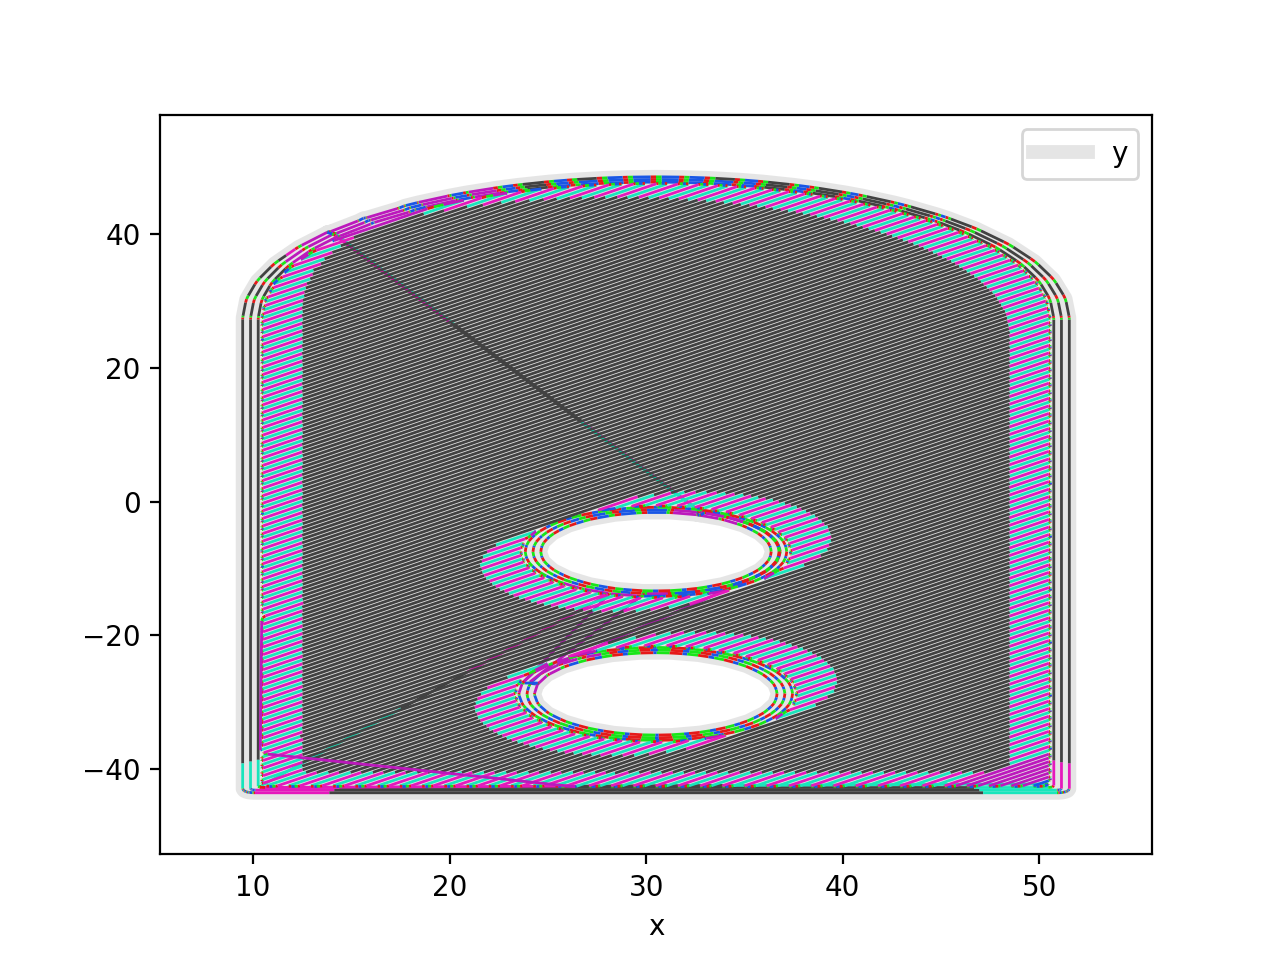

x       y
0  25.527 -24.410
1  26.712 -23.347
2  28.114 -22.597
3  29.657 -22.205
4  31.248 -22.194
5  32.795 -22.562
6  34.208 -23.291
7  35.408 -24.337
8  36.320 -25.640
9  36.896 -27.123

x0         y0        vx0        vy0          ax0          ay0  \
0  25.527000 -24.410000   0.000000   0.000000  1000.000000   897.046414   
1  25.772189 -24.190054  22.144501  19.864646   746.866530   669.973942   
2  26.503560 -23.533981  39.785059  35.689045   700.703621 -1000.000000   
3  26.721617 -23.360724  43.456157  30.449886   700.703621 -1000.000000   
4  26.958907 -23.214917  47.127254  25.210728   571.097289   305.508536   
5  27.719041 -22.808283  55.580561  29.732825   387.864591 -1000.000000   
6  28.123793 -22.622248  58.336752  22.626760   387.864591 -1000.000000   
7  28.548130 -22.486709  61.092943  15.520696   592.981854   150.647367   
8  29.113439 -22.343092  66.353468  16.857135   128.551729 -1000.000000   
9  29.661313 -22.238554  67.406551   8.665229   128.551729 -1000.000000   

          x1         y1        vx1        vy1          ax1          ay1  \
0  25.772189 -24.190054  22.144501  19.864646  1000.000000   897.046414   
1  26.503560 -23.533981  39.785059  35.689045   746.866530   669.973942   
2  26.721617 -23.360724  43.456157  30.449886   700.703621 -1000.000000   
3  26.958907 -23.214917  47.127254  25.210728   700.703621 -1000.000000   
4  27.719041 -22.808283  55.580561  29.732825   571.097289   305.508536   
5  28.123793 -22.622248  58.336752  22.626760   387.864591 -1000.000000   
6  28.548130 -22.486709  61.092943  15.520696   387.864591 -1000.000000   
7  29.113439 -22.343092  66.353468  16.857135   592.981854   150.647367   
8  29.661313 -22.238554  67.406551   8.665229   128.551729 -1000.000000   
9  30.217815 -22.201123  68.459635   0.473322   128.551729 -1000.000000   

         dt  src_idx  src_part      seg_type         t   src_de        de  
0  0.022145        1  0.206911         start  0.022145 -0.07942 -0.016433  
1  0.023619        1  0.617190  middle_plato  0.045764 -0.07942 -0.049017  
2  0.005239        1  0.175899           end  0.051003 -0.07942 -0.013970  
3  0.005239        2  0.176111         start  0.056242 -0.07932 -0.013969  
4  0.014802        2  0.542178  middle_plato  0.071044 -0.07932 -0.043006  
5  0.007106        2  0.281711           end  0.078150 -0.07932 -0.022345  
6  0.007106        3  0.281355         start  0.085256 -0.07943 -0.022348  
7  0.008871        3  0.366370   short_plato  0.094128 -0.07943 -0.029101  
8  0.008192        3  0.352276           end  0.102319 -0.07943 -0.027981  
9  0.008192        4  0.352492         start  0.110511 -0.07938 -0.027981

x       y
906  22.918  46.111
907  21.794  45.553
908  12.499  36.258
909  12.429  36.188
910  13.048  37.372
911  20.641  44.966
912  20.711  45.036
913  19.110  44.001
914  14.111  39.001
915  14.041  38.931

x0         y0        vx0        vy0          ax0          ay0  \
3237  15.131093  39.455367  63.635420  63.643801     0.000000     0.000000   
3238  18.684470  43.009212  63.635420  63.643801  -999.868317 -1000.000000   
3239  20.641000  44.966000  11.701718  11.702488  -989.928085  -989.928085   
3240  20.709817  45.034817   0.837393   0.837393 -1000.000000  -751.211002   
3241  20.710001  45.035250  -0.575833  -0.224238 -1000.000000  -751.211002   
3242  20.708189  45.034183  -1.989059  -1.285869  -963.947531  -623.164081   
3243  19.683239  44.371582 -44.496665 -28.765801  1000.000000   389.313921   
3244  19.192982  44.033306 -31.613933 -23.750374  1000.000000   389.313921   
3245  18.868691  43.759643 -18.731200 -18.734947    22.309762    22.314224   
3246  14.111000  39.001000 -11.772261 -11.773439   990.098029   990.098029   

             x1         y1        vx1        vy1          ax1          ay1  \
3237  18.684470  43.009212  63.635420  63.643801     0.000000     0.000000   
3238  20.641000  44.966000  11.701718  11.702488  -999.868317 -1000.000000   
3239  20.709817  45.034817   0.837393   0.837393  -989.928085  -989.928085   
3240  20.710001  45.035250  -0.575833  -0.224238 -1000.000000  -751.211002   
3241  20.708189  45.034183  -1.989059  -1.285869 -1000.000000  -751.211002   
3242  19.683239  44.371582 -44.496665 -28.765801  -963.947531  -623.164081   
3243  19.192982  44.033306 -31.613933 -23.750374  1000.000000   389.313921   
3244  18.868691  43.759643 -18.731200 -18.734947  1000.000000   389.313921   
3245  14.111000  39.001000 -11.772261 -11.773439    22.309762    22.314224   
3246  14.041000  38.931000   0.000000   0.000000   990.098029   990.098029   

            dt  src_idx  src_part         seg_type           t   src_de  \
3237  0.055840      911  0.467981  long_plato_main  135.629815 -0.53576   
3238  0.051941      911  0.257676   long_plato_out  135.681756 -0.53576   
3239  0.010976      912  0.983094      short_plato  135.692732  0.00000   
3240  0.001413      912  0.016906              end  135.694145  0.00000   
3241  0.001413      913  0.001756            start  135.695558  0.00000   
3242  0.044097      913  0.640194     middle_plato  135.739656  0.00000   
3243  0.012883      913  0.358050              end  135.752539  0.00000   
3244  0.012883      914  0.048271            start  135.765421 -0.35274   
3245  0.311950      914  0.951729     middle_plato  136.077372 -0.35274   
3246  0.011891      915  1.000000      short_plato  136.089263  0.00000   

            de  
3237 -0.250725  
3238 -0.138052  
3239  0.000000  
3240  0.000000  
3241  0.000000  
3242  0.000000  
3243  0.000000  
3244 -0.017027  
3245 -0.335713  
3246  0.000000

In [35]:
%matplotlib notebook

from matplotlib.collections import LineCollection
import warnings

warnings.simplefilter("error")

all_segments = path_planning.build_segments(path, plato_slowdowns)

lines = []
colors = []

i = 0
for index, row in all_segments.iterrows():
    i += 1
    lines.append(((row['x0'], row['y0']), (row['x1'], row['y1'])))
    st = row["seg_type"]
    if st == "start":
        colors.append((1,0,0,1))
    elif st == "end":
        colors.append((0,1,0,1))
    elif st == "short_plato":
        colors.append((0,0.3,1,1))
    elif st == "middle_plato":
        colors.append((0.8,0,0.8,1))
    elif st == "long_plato_main":
        colors.append((0.2,0.2,0.2,1))
    elif st == "long_plato_in":
        colors.append((1,0,0.8,1))
    elif st == "long_plato_out":
        colors.append((0,1,0.8,1))
    else:
        colors.append((1,1,0,1))
    
lc = LineCollection(lines, colors=colors, linewidths=1)
fig, ax = plt.subplots()

ax.add_collection(lc)

#path.iloc[limit:].plot(x="px", y="py", linewidth=3, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
full_path = pd.DataFrame()
full_path["x"] = path["px"]
full_path["y"] = path["py"]
last_x = path["x"].iloc[-1]
last_y = path["y"].iloc[-1]
full_path = full_path.append({"x": last_x, "y": last_y}, ignore_index=True)
full_path.plot(x="x", y="y", linewidth=5, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
    
ax.autoscale()
ax.margins(0.1)
display(full_path.iloc[:10])
display(all_segments.iloc[:10])

display(full_path.iloc[-10:])
display(all_segments.iloc[-10:])


In [36]:
all_segments["test_vx1"] = all_segments["vx0"] + all_segments["dt"] * all_segments["ax0"]
all_segments["test_vy1"] = all_segments["vy0"] + all_segments["dt"] * all_segments["ay0"]
all_segments["test_x1"] = all_segments["x0"] + all_segments["dt"] * all_segments["vx0"] + all_segments["dt"] * all_segments["dt"] * all_segments["ax0"]/2
all_segments["test_y1"] = all_segments["y0"] + all_segments["dt"] * all_segments["vy0"] + all_segments["dt"] * all_segments["dt"] * all_segments["ay0"]/2
print("bad vx1")
display(all_segments[abs(all_segments["test_vx1"] - all_segments["vx1"]) > 0.01])
print("bad vy1")
display(all_segments[abs(all_segments["test_vy1"] - all_segments["vy1"]) > 0.01])
print("bad x1")
display(all_segments[abs(all_segments["test_x1"] - all_segments["x1"]) > 0.0001])
print("bad y1")
display(all_segments[abs(all_segments["test_y1"] - all_segments["y1"]) > 0.0001])
print("ax non continuous")
display(all_segments[abs(all_segments["ax1"] - all_segments["ax0"]) > 0.001])
print("ay non continuous")
display(all_segments[abs(all_segments["ay1"] - all_segments["ay0"]) > 0.001])
print("vx non continuous")
display(all_segments[abs(all_segments["vx1"] - all_segments["vx0"].shift(-1)) > 0.001])
print("vy non continuous")
display(all_segments[abs(all_segments["vy1"] - all_segments["vy0"].shift(-1)) > 0.001])
print("x non continuous")
display(all_segments[abs(all_segments["x1"] - all_segments["x0"].shift(-1)) > 0.001])
print("y non continuous")
display(all_segments[abs(all_segments["y1"] - all_segments["y0"].shift(-1)) > 0.001])
print("src_part groups")
display(np.bincount(all_segments["src_idx"], weights=all_segments["src_part"]))
display(all_segments[np.isnan(all_segments["dt"])][["seg_type", "vx0", "vx1", "vy0", "vy1"]])


bad vx1


x0         y0        vx0        vy0         ax0         ay0  \
221    9.868000 -42.870000  -0.000072 -10.147490    0.000000  990.035530   
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
225    9.912234 -43.057979   6.950302  -9.267069 -734.267183  979.022911   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
229    9.959876 -43.101063   7.111078  -1.862425 -204.457186   53.548311   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
221    9.868020 -42.920998   0.199844  -1.597110  ...       74  1.000000   
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
225    9.934462 -43.086512   5.767085  -5.455584  ...       76  0.604599   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
229   10.078003 -43.131979   1.573010  -0.202573  ...       78  0.937492   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
221    short_plato   3.520897 -0.00255 -0.002550  -0.000072  -1.424192   
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
225    short_plato   3.543862 -0.00300 -0.001814   4.107230  -5.476306   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
229    short_plato   3.575201 -0.00650 -0.006094   1.505505  -0.394299   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plat

bad vy1


x0         y0        vx0        vy0         ax0         ay0  \
221    9.868000 -42.870000  -0.000072 -10.147490    0.000000  990.035530   
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
225    9.912234 -43.057979   6.950302  -9.267069 -734.267183  979.022911   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
229    9.959876 -43.101063   7.111078  -1.862425 -204.457186   53.548311   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
221    9.868020 -42.920998   0.199844  -1.597110  ...       74  1.000000   
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
225    9.934462 -43.086512   5.767085  -5.455584  ...       76  0.604599   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
229   10.078003 -43.131979   1.573010  -0.202573  ...       78  0.937492   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
221    short_plato   3.520897 -0.00255 -0.002550  -0.000072  -1.424192   
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
225    short_plato   3.543862 -0.00300 -0.001814   4.107230  -5.476306   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
229    short_plato   3.575201 -0.00650 -0.006094   1.505505  -0.394299   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plat

bad x1


x0         y0        vx0        vy0         ax0         ay0  \
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
225    9.912234 -43.057979   6.950302  -9.267069 -734.267183  979.022911   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
225    9.934462 -43.086512   5.767085  -5.455584  ...       76  0.604599   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
225    short_plato   3.543862 -0.00300 -0.001814   4.107230  -5.476306   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plato  80.291867  0.00000  0.000000  17.848361   9.158879   

        test_x1    test_y1  
222    9.889671 -43.018322  
225    9.933642 -43.086522  
226    9.943117 -43.095031  
230   10.130523 -43.133769  
239   51.087871 -43.065095  
240   51.099596 -43.053931  
241   51.134596 -42.945263  
1625  27.433416 -22.345581  
1626  26.287749 -23.079172  
1921  33.050542 -35.396458  
1922  33.826622 -35.002105  
2202  28.368487  -1.046513  
2203  27.767266  

bad y1


x0         y0        vx0        vy0         ax0         ay0  \
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plato  80.291867  0.00000  0.000000  17.848361   9.158879   

        test_x1    test_y1  
222    9.889671 -43.018322  
226    9.943117 -43.095031  
230   10.130523 -43.133769  
239   51.087871 -43.065095  
240   51.099596 -43.053931  
241   51.134596 -42.945263  
1625  27.433416 -22.345581  
1626  26.287749 -23.079172  
1921  33.050542 -35.396458  
1922  33.826622 -35.002105  
2202  28.368487  -1.046513  
2203  27.767266  -1.290392  
2482  33.182548 -13.768452  
2483  34.000642 -13.337358  

[14 rows x 23 columns]

ax non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

ay non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

vx non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

vy non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

x non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

y non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

src_part groups


array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

Empty DataFrame
Columns: [seg_type, vx0, vx1, vy0, vy1]
Index: []

In [ ]:
sub_path = pd.DataFrame()
sub_path["src_idx"] = path["src_idx"]
sub_path["src_de"] = path["de"]
all_segments_extras = all_segments.merge(sub_path, on='src_idx')
all_segments_extras["de"] = all_segments_extras["src_de"] * all_segments_extras["src_part"]
all_segments_extras["de_v"] = all_segments_extras["de"] / all_segments_extras["dt"]
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, 'de_v' ] = 0
all_segments_extras["v0"] = np.linalg.norm(all_segments_extras[['vx0', 'vy0']].values, axis=1)
all_segments_extras["v1"] = np.linalg.norm(all_segments_extras[['vx1', 'vy1']].values, axis=1)
all_segments_extras["avg_v"] = (all_segments_extras["v0"] + all_segments_extras["v1"])/2
all_segments_extras["de_v0"] = all_segments_extras["de_v"] / all_segments_extras["avg_v"] * all_segments_extras["v0"]
all_segments_extras["de_v1"] = all_segments_extras["de_v"] / all_segments_extras["avg_v"] * all_segments_extras["v1"]
all_segments_extras["de_a"] = (all_segments_extras["de_v1"] - all_segments_extras["de_v0"])/ all_segments_extras["dt"]
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, "de_v0"] = 0
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, "de_v1"] = 0
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, "de_a"] = 0

acc_step = 10000
v_step = 50000000
v_mult = v_step / acc_step
spm = 80

delta_e = all_segments_extras["de_v1"] - all_segments_extras["de_v0"].shift(-1)
all_segments_extras["delta_ve"] = delta_e
all_segments_extras["int_dt"] = (all_segments_extras["dt"] * acc_step).fillna(0).astype(int)
all_segments_extras["int_vx0"] = (all_segments_extras["vx0"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_vy0"] = (all_segments_extras["vy0"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_vx1"] = (all_segments_extras["vx1"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_vy1"] = (all_segments_extras["vy1"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_ax"] = (np.around((all_segments_extras["int_vx1"] - all_segments_extras["int_vx0"]) / all_segments_extras["int_dt"])).replace([np.inf, -np.inf], np.nan).fillna(0).astype(int) 
all_segments_extras["int_ay"] = (np.around((all_segments_extras["int_vy1"] - all_segments_extras["int_vy0"]) / all_segments_extras["int_dt"])).replace([np.inf, -np.inf], np.nan).fillna(0).astype(int) 
#all_segments_extras["int_vx1_real1"] = (all_segments_extras["int_vx0"] + (all_segments_extras["int_ax"]-1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
all_segments_extras["int_vx1_real"] = (
    all_segments_extras["int_vx0"] + all_segments_extras["int_ax"] * all_segments_extras["int_dt"]
).fillna(0).astype(int)
#all_segments_extras["int_vx1_real3"] = (all_segments_extras["int_vx0"] + (all_segments_extras["int_ax"]+1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
#all_segments_extras["int_vy1_real1"] = (all_segments_extras["int_vy0"] + (all_segments_extras["int_ay"]-1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
all_segments_extras["int_vy1_real"] = (
    all_segments_extras["int_vy0"] + all_segments_extras["int_ay"] * all_segments_extras["int_dt"]
).fillna(0).astype(int)
#all_segments_extras["int_vy1_real3"] = (all_segments_extras["int_vy0"] + (all_segments_extras["int_ay"]+1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
all_segments_extras["int_dx"] = ((all_segments_extras["int_vx0"] + all_segments_extras["int_vx1_real"]) / 2 * all_segments_extras["int_dt"] * v_mult).fillna(0).astype(int)
all_segments_extras["int_dy"] = ((all_segments_extras["int_vy0"] + all_segments_extras["int_vy1_real"]) / 2 * all_segments_extras["int_dt"] * v_mult).fillna(0).astype(int)
all_segments_extras["real_dx"] = all_segments_extras["int_dx"] / spm / 2.0 ** 32
all_segments_extras["exp_dx"] = all_segments_extras["x1"] - all_segments_extras["x0"]
all_segments_extras["real_dy"] = all_segments_extras["int_dy"] / spm / 2.0 ** 32
all_segments_extras["exp_dy"] = all_segments_extras["y1"] - all_segments_extras["y0"]
all_segments_extras["error"] = np.linalg.norm([
    all_segments_extras["real_dx"] - all_segments_extras["exp_dx"],
    all_segments_extras["real_dy"] - all_segments_extras["exp_dy"],
], axis = 0)

#display(all_segments_extras[all_segments_extras["error"]>0.02])
display(all_segments_extras[np.logical_and(all_segments_extras["dt"] > -1e-27,all_segments_extras["dt"] < 1e-4)][["seg_type","dt", "vx0", "vx1", "vy0", "vy1", "exp_dx", "exp_dy"]])


In [45]:
from valurap.asg import ProfileSegment
from numpy.linalg import norm

def format(all_segments, apgs=None, acc_step=1000):
    if apgs is None:
        apgs = {}

    apg_states = {}
    
    apg_x = apgs.get("X", path_planning.FakeApg("X"))
    apg_y = apgs.get("Y", path_planning.FakeApg("Y"))
    apg_z = apgs.get("Z", path_planning.FakeApg("Z"))

    v_step = 50000000
    v_mult = v_step / acc_step
    spm = 80
    spme = 837

    pr_opt = []
    first_row = all_segments.iloc[0]
    last_x = first_row["x0"]
    last_y = first_row["y0"]
    last_vx = first_row["vx0"]
    last_vy = first_row["vy0"]
    assert last_vx == 0
    assert last_vy == 0
    segs = [
        ProfileSegment(
            apg=apg_x, x = last_x * spm, v = 0, a = 0
        ),
        ProfileSegment(
            apg=apg_y, x = last_y * spm, v = 0, a = 0
        ),
    ]
    
    sub_profile = [[5, segs]]
    pr_opt += sub_profile
    
    path_planning.emulate(sub_profile, apg_states=apg_states, accel_step=50000000/acc_step)
    print(apg_states["X"], apg_states["Y"])
    
    for index, up_row in all_segments.iterrows():
        if index > 550000000:
            print("last_x:", last_x, "last_y:", last_y)
            print("last_vx:", last_vx, "last_vy:", last_vy)
            break
        print("index:", index, up_row["seg_type"])
        if up_row["dt"] < 0.2:
            rows = [up_row]
        else:
            splits = int(up_row["dt"] / 0.15)
            print("long segment, split up", splits)
            tx0 = up_row["x0"]
            ty0 = up_row["y0"]
            tx1 = up_row["x1"]
            ty1 = up_row["y1"]
            tvx0 = up_row["vx0"]
            tvy0 = up_row["vy0"]
            tvx1 = up_row["vx1"]
            tvy1 = up_row["vy1"]
            lx1 = tx0
            ly1 = ty0
            lvx1 = tvx0
            lvy1 = tvy0
            dvx = (tvx1 - tvx0)/splits
            dvy = (tvy1 - tvy0)/splits
            dt = up_row["dt"]/splits
            rows = []
            for i in range(splits):
                cvx1 = lvx1 + dvx
                cvy1 = lvy1 + dvy
                cx1 = lx1 + (lvx1 + dvx/2) * dt
                cy1 = ly1 + (lvy1 + dvy/2) * dt
                if i == splits - 1:
                    cvx1 = tvx1
                    cvy1 = tvy1
                    cx1 = tx1
                    cy1 = ty1
                rows.append(
                    {
                        "x0": lx1,
                        "y0": ly1,
                        "x1": cx1,
                        "y1": cy1,
                        "vx0": lvx1,
                        "vy0": lvy1,
                        "vx1": cvx1,
                        "vy1": cvy1,
                        "dt": dt,
                        "de": 0
                    }
                )
                lx1 = cx1
                ly1 = cy1
                lvx1 = cvx1
                lvy1 = cvy1
            
        for row in rows:
            next_x = row["x1"]
            next_y = row["y1"]
            next_vx = row["vx1"]
            next_vy = row["vy1"]
            de = row["de"]

            dx = next_x - last_x
            dy = next_y - last_y
            dvx = next_vx - last_vx
            dvy = next_vy - last_vy
            avg_vx = last_vx + 0.5 * dvx
            avg_vy = last_vy + 0.5 * dvy

            print("x:", last_x, row["x0"])
            print("y:", last_y, row["y0"])
            print("vx:", last_vx, row["vx0"])
            print("vy:", last_vy, row["vy0"])
            print("dx:", dx)
            print("dy:", dy)
            print("dvx:", dvx)
            print("dvy:", dvy)

            dt = row["dt"]
            int_dt = np.around(dt * acc_step)

            if int_dt == 0:
                int_dt = 1

            print("int_dt:", int_dt)

            int_vx0 = np.around(last_vx * 2 ** 32 * spm / v_step)
            int_vy0 = np.around(last_vy * 2 ** 32 * spm / v_step)
            int_vx1 = np.around(next_vx * 2 ** 32 * spm / v_step)
            int_vy1 = np.around(next_vy * 2 ** 32 * spm / v_step)
            int_ax = np.around((int_vx1 - int_vx0) / int_dt * 65536)
            int_ay = np.around((int_vy1 - int_vy0) / int_dt * 65536)
            print("int_vx1:", int_vx1, "int_vy1:", int_vy1)

            real_dx = path_planning.int_x(int_dt, int_vx0 * 65536, int_ax, 0, 0) / 65536 * v_mult
            real_dy = path_planning.int_x(int_dt, int_vy0 * 65536, int_ay, 0, 0) / 65536 * v_mult
            x_error = dx * 2.0 ** 32 * spm - real_dx 

            int_jx = np.around(-12 * x_error / int_dt / int_dt / int_dt * 65536 / v_mult)
            int_ax = np.around(int_ax - int_jx * int_dt / 2)
            print("x_error:", x_error / 2.0 ** 32 / spm, "int_jx:", int_jx, "int_ax:", int_ax)

            y_error = dy * 2.0 ** 32 * spm - real_dy 
            int_jy = np.around(-12 * y_error / int_dt / int_dt / int_dt * 65536 / v_mult)
            int_ay = np.around(int_ay - int_jy * int_dt / 2)
            print("y_error:", y_error / 2.0 ** 32 / spm, "int_jy:", int_jy, "int_ay:", int_ay)

            segs = [
                    ProfileSegment(
                        apg=apg_x, a = int(int_ax), j = int(int_jx)
                    ),
                    ProfileSegment(
                        apg=apg_y, a = int(int_ay), j = int(int_jy)
                    ),
                ]

            sub_profile = [[int(int_dt), segs]]
            pr_opt += sub_profile

            res = path_planning.emulate(sub_profile, apg_states=apg_states, accel_step=50000000/acc_step)
            res["xv"] = res["X_v"] * 65536 / 2**32 / 80 * 50000000
            res["yv"] = res["Y_v"] * 65536 / 2**32 / 80 * 50000000

            print("ApgStates:", apg_states["X"].x / 2**32 / spm, apg_states["Y"].x / 2**32 / spm)
            print("        V:", apg_states["X"].v / 2**32 / spm * v_step, apg_states["Y"].v / 2**32 / spm * v_step)
            print("   max_xv:", res["xv"].max(), res["xv"].min())
            print("   max_yv:", res["yv"].max(), res["yv"].min())

            last_x = apg_states["X"].x / 2**32 / spm
            last_y = apg_states["Y"].x / 2**32 / spm
            last_vx = apg_states["X"].v / 2**32 / spm * v_step
            last_vy = apg_states["Y"].v / 2**32 / spm * v_step

            print("final x_error:", last_x - next_x)
            print("final y_error:", last_y - next_y)
            print("final vx_error:", last_vx - next_vx)
            print("final vy_error:", last_vy - next_vy)

            if 1:
                assert res["xv"].max() < 300
                assert res["xv"].min() > -300
                assert res["yv"].max() < 300
                assert res["yv"].min() > -300

                assert abs(last_x - next_x) < 1
                assert abs(last_y - next_y) < 1

            if 0:
                if abs(last_vx) < 0.001:
                    last_vx = 0
                if abs(last_vy) < 0.001:
                    last_vy = 0
        
    pr_opt += [
        [
            5,
            [
                ProfileSegment(apg=apg_x, v=0),
                ProfileSegment(apg=apg_y, v=0),
                ProfileSegment(apg=apg_z, v=0),
            ],
        ]
    ]

    return pr_opt


acc_step = 10000
pr_opt = format(all_segments, acc_step=acc_step)
display(pr_opt)
res = path_planning.emulate(pr_opt, accel_step=50000000/acc_step, verbose=0)



<ApgState x=8771010413199.36 v=0 a=0 j=0 jj=0> <ApgState x=-8387212135628.8 v=0 a=0 j=0 jj=0>
index: 0 start
x: 25.527 25.527
y: -24.41 -24.41
vx: 0.0 0.0
vy: 0.0 0.0
dx: 0.24518947197976715
dy: 0.2199463364679275
dvx: 22.144501438495595
dvy: 19.864645594194783
int_dt: 221.0
int_vx1: 152176.0 int_vy1: 136509.0
x_error: 0.0015997215959124844 int_jx: -8010.0 int_ax: 46011831.0
y_error: 0.0014349204021577577 int_jy: -7184.0 int_ay: 41274619.0
ApgStates: 25.77203291933797 -24.190211350298487
        V: 22.130407160148025 19.850267563015223
   max_xv: 22.03218173235655 0.0
   max_yv: 19.762228475883603 0.0
final x_error: -0.00015655264179770256
final y_error: -0.00015768676641414459
final vx_error: -0.014094278347570821
final vy_error: -0.014378031179560935
index: 1 middle_plato
x: 25.77203291933797 25.772189471979768
y: -24.190211350298487 -24.190053663532073
vx: 22.130407160148025 22.144501438495595
vy: 19.850267563015223 19.864645594194783
dx: 0.7315268513671072
dy: 0.6562307901799187
dv

ApgStates: 31.243527637559918 -22.23249615236651
        V: 72.62191502377391 -8.263596100732684
   max_xv: 73.64957127720118 72.60998245328665
   max_yv: 0.5065521690994501 -8.166389307007194
final x_error: -9.012207797809424e-05
final y_error: 1.203866865395753e-05
final vx_error: -0.02073894126388609
final vy_error: 0.0031534312095207184
index: 12 start
x: 31.243527637559918 31.243617759637896
y: -22.23249615236651 -22.232508191035166
vx: 72.62191502377391 72.6426539650378
vy: -8.263596100732684 -8.266749531942205
dx: 0.6332123883135203
dy: -0.11106837867513164
dvx: -0.9779601013981392
dvy: -8.779051224047162
int_dt: 88.0
int_vx1: 492334.0 int_vy1: -117116.0
x_error: -0.0016066482679484295 int_jx: 127413.0 int_ax: -10610739.0
y_error: -0.00015997419876967456 int_jy: 12687.0 int_ay: -45486880.0
ApgStates: 31.876657356622626 -22.34354215216823
        V: 71.62510883063078 -17.037527868524194
   max_xv: 72.62191502377391 71.62278052419424
   max_yv: -8.263596100732684 -16.9390114024281

ApgStates: 36.69741324323509 -26.61172306580935
        V: 24.719774955883622 -63.649931689724326
   max_xv: 26.69126843102276 24.743931135162715
   max_yv: -63.71046765707433 -68.74019163660705
final x_error: -3.4570837740943716e-05
final y_error: 7.399715941147633e-05
final vx_error: -0.010666899396568397
final vy_error: 0.02236912864459839
index: 26 end
x: 36.69741324323509 36.69744781407283
y: -26.61172306580935 -26.611797062968762
vx: 24.719774955883622 24.73044185528019
vy: -63.649931689724326 -63.672300818368925
dx: 0.1663571061215876
dy: -0.5194685198986946
dvx: -8.017988111665353
dvy: -2.0629564242146614
int_dt: 80.0
int_vx1: 114774.0 int_vy1: -451576.0
x_error: 0.00026984771297833277 int_jx: -28483.0 int_ax: -43997781.0
y_error: -0.0021201178249583563 int_jy: 223785.0 int_ay: -20565198.0
ApgStates: 36.86375726305228 -27.131245866268877
        V: 16.69861376285553 -65.72692655026913
   max_xv: 24.719774955883622 16.8013502843678
   max_yv: -63.649931689724326 -65.720523707568

   max_yv: -52.563700592145324 -53.86187694966793
final x_error: -0.00010079287736175502
final y_error: -9.423330192959156e-05
final vx_error: -0.0426596421256491
final vy_error: -0.03941120162532741
index: 41 end
x: 34.73820250131935 34.73830329419671
y: -33.74915127825458 -33.74905704495265
vx: -58.51921741850674 -58.47655777638109
vy: -52.49559762887656 -52.45618642725123
dx: -0.47097797882755543
dy: -0.3741992709957316
dvx: -5.353163246568201
dvy: 7.739989199371188
int_dt: 77.0
int_vx1: -438928.0 int_vy1: -307558.0
x_error: -3.779495238731556e-05 int_jx: 4474.0 int_ax: -31482286.0
y_error: 0.0006047615540154538 int_jy: -71590.0 int_ay: 48026271.0
ApgStates: 34.26724382210337 -34.123306804769676
        V: -63.867337303236134 -44.74393790587783
   max_xv: -58.51921741850674 -63.79821570590139
   max_yv: -44.83852535486221 -52.49559762887656
final x_error: 1.9299611572876074e-05
final y_error: 4.3744480635155014e-05
final vx_error: 0.00504336183880838
final vy_error: 0.01167052362754

        V: -62.877952586859465 42.709725676104426
   max_xv: -62.94649210758507 -68.01972631365061
   max_yv: 42.61542926542461 35.09092493914068
final x_error: 1.746849466854883e-05
final y_error: 2.3323745281800257e-06
final vx_error: 0.004635095495402197
final vy_error: 0.0005467818993096785
index: 57 start
x: 26.811645666601134 26.811628198106465
y: -34.18009821508546 -34.180100547459986
vx: -62.877952586859465 -62.88258768235487
vy: 42.709725676104426 42.70917889420512
dx: -0.45845786047705417
dy: 0.3535961774139693
dvx: 5.1589414877180175
dvy: 7.602012331980724
int_dt: 76.0
int_vx1: -396642.0 int_vy1: 345740.0
x_error: 6.853571587228657e-05 int_jx: -8438.0 int_ax: 30891463.0
y_error: 0.00049451474630402 int_jy: -60881.0 int_ay: 47361717.0
ApgStates: 26.353211122330276 -33.82650386084803
        V: -57.712895795702934 50.311355153098695
   max_xv: -57.78012564405798 -62.877952586859465
   max_yv: 50.21633114665747 42.709725676104426
final x_error: 2.3316206196000167e-05
final y_er

y: -26.81976494387724 -26.819715008002735
vx: 20.87792381644249 20.881593919741277
vy: 56.184944696724415 56.19938002587387
dx: 0.3227389102433591
dy: 0.8686155733917609
dvx: -4.37069159792479
dvy: -11.758440657356552
int_dt: 173.0
int_vx1: 113437.0 int_vy1: 305297.0
x_error: -0.000861429246167944 int_jx: 8991.0 int_ax: -12155604.0
y_error: -0.0022618664320752657 int_jy: 23609.0 int_ay: -32652036.0
ApgStates: 24.550591328295877 -25.951297096991915
        V: 16.492995200678706 44.409389374777675
   max_xv: 20.87792381644249 16.51656930334866
   max_yv: 56.184944696724415 44.47298124432564
final x_error: -0.00012312425344873645
final y_error: -0.0001477265064373512
final vx_error: -0.014237017838993893
final vy_error: -0.01711466459018851
index: 74 end
x: 24.550591328295877 24.550714452549325
y: -25.951297096991915 -25.951149370485478
vx: 16.492995200678706 16.5072322185177
vy: 44.409389374777675 44.42650403936786
dx: 0.09613668945161535
dy: 0.217738551539167
dvx: 5.059634474430453
dvy:

ApgStates: 36.58881967770681 -9.19780090226792
        V: 14.655815903097391 38.98836439475417
   max_xv: 14.6379170473665 7.345661288127302
   max_yv: 38.94034307450056 19.559956854209304
final x_error: -0.0006028193089022693
final y_error: -0.0006358108513992988
final vx_error: -0.030840689650110775
final vy_error: -0.030730671691785005
index: 89 end
x: 36.58881967770681 36.58942249701571
y: -9.19780090226792 -9.19716509141652
vx: 14.655815903097391 14.686656592747502
vy: 38.98836439475417 39.019095066445956
dx: 0.06030413025789727
dy: 0.19369932382955568
dvx: -4.842801077097366
dvy: 1.2201580856683094
int_dt: 49.0
int_vx1: 67435.0 int_vy1: 276311.0
x_error: 0.0001131888819045912 int_jx: -51994.0 int_ax: -43235791.0
y_error: -0.0002720891732579389 int_jy: 124987.0 int_ay: 8152500.0
ApgStates: 36.64912175212335 -9.004125780859033
        V: 9.812210919335485 40.198356145992875
   max_xv: 14.655815903097391 9.913783287629485
   max_yv: 40.167069528251886 38.98836439475417
final x_error

index: 106 middle_plato
x: 34.00497052119859 34.00494118972516
y: -2.2538007197110006 -2.2537618721058887
vx: -48.706133384257555 -48.72050195885413
vy: 29.166112653911114 29.185228226559854
dx: -1.2298353266477235
dy: 0.7367342263568608
dvx: 44.473968467400404
dvy: -26.63090275202568
int_dt: 464.0
int_vx1: -29083.0 int_vy1: 17422.0
x_error: 0.0005561668419673538 int_jx: -301.0 int_ax: 43236446.0
y_error: -6.857219240234969e-05 int_jy: 37.0 int_ay: -25856604.0
ApgStates: 32.7759385784138 -1.5179209604067752
        V: -4.198955139145255 2.4953624233603477
   max_xv: -4.294706741347909 -48.706133384257555
   max_yv: 29.166112653911114 2.552842488512397
final x_error: 0.0008033838629373236
final y_error: -0.0008544670526353659
final vx_error: 0.03320977771189515
final vy_error: -0.039847478525085744
index: 107 end
x: 32.7759385784138 32.77513519455086
y: -1.5179209604067752 -1.5170664933541398
vx: -4.198955139145255 -4.23216491685715
vy: 2.4953624233603477 2.5352099018854335
dx: -0.01370

ApgStates: 35.194144986451604 -3.327670669034126
        V: 43.49276423454285 -48.93488949164749
   max_xv: 49.47796696797013 43.555774027481675
   max_yv: -43.660111259669065 -48.81963832303882
final x_error: -0.00012227655224705813
final y_error: 9.470750809681405e-05
final vx_error: -0.041654112445904445
final vy_error: 0.03218647765388738
index: 117 start
x: 35.194144986451604 35.19426726300385
y: -3.327670669034126 -3.3277653765422226
vx: 43.49276423454285 43.53441834698875
vy: -48.93488949164749 -48.967075969301376
dx: 0.24164960754820441
dy: -0.3074732013771513
dvx: -5.913635468448234
dvy: -5.326765801823555
int_dt: 60.0
int_vx1: 258242.0 int_vy1: -372883.0
x_error: -0.0018618362144628975 int_jx: 465831.0 int_ax: -58362463.0
y_error: 0.0018499847212911646 int_jy: -462866.0 int_ay: -26096441.0
ApgStates: 35.43568984081317 -3.635041039171631
        V: 37.54350473172963 -54.22640242613852
   max_xv: 43.49276423454285 37.61218977160752
   max_yv: -48.93488949164749 -54.107949836179

x_error: -1.5632420986122497e-05 int_jx: 1425.0 int_ax: -44866969.0
y_error: 0.002754866282071333 int_jy: -251191.0 int_ay: 22479915.0
ApgStates: 36.58793246198725 -8.989317402676681
        V: -16.789272194728255 -68.84147296659648
   max_xv: -8.437637006863952 -16.690028132870793
   max_yv: -68.84511094540358 -71.09672878868878
final x_error: 2.2668087702015782e-05
final y_error: 0.00012554676245457586
final vx_error: 0.005680303500128048
final vy_error: 0.030194954290109877
index: 129 start
x: 36.58793246198725 36.58790979389955
y: -8.989317402676681 -8.989442949439136
vx: -16.789272194728255 -16.794952498228383
vy: -68.84147296659648 -68.8716679208866
dx: -0.1758104896840038
dy: -0.568532286525711
dvx: -8.383055322018375
dvy: 2.0127004734419387
int_dt: 84.0
int_vx1: -172983.0 int_vy1: -459244.0
x_error: 9.126186316876783e-06 int_jx: -832.0 int_ax: -44910269.0
y_error: 0.0013834838720665488 int_jy: -126147.0 int_ay: 16088988.0
ApgStates: 36.412149182286115 -9.55777571836021
        

ApgStates: 33.26930567913037 -13.113481605625713
        V: -64.27260814234614 -33.83276634849608
   max_xv: -64.41769073717296 -68.43722076155245
   max_yv: -33.91047357581556 -36.01671778596938
final x_error: -0.00010341494579790833
final y_error: -5.382763755257258e-05
final vx_error: -0.04855044903716532
final vy_error: -0.02560438056834613
index: 140 end
x: 33.26930567913037 33.26940909407617
y: -13.113481605625713 -13.11342777798816
vx: -64.27260814234614 -64.22405769330898
vy: -33.83276634849608 -33.80716196792773
dx: -0.5380406778633073
dy: -0.243055022977142
dvx: -3.0648075136241744
dvy: 8.206481032510311
int_dt: 82.0
int_vx1: -462739.0 int_vy1: -176102.0
x_error: 0.001407063204315051 int_jx: -137915.0 int_ax: -11177847.0
y_error: 0.001137123366493853 int_jy: -111457.0 int_ay: 49641721.0
ApgStates: 32.73134027607553 -13.356471698000098
        V: -67.31876055710018 -25.610061129555103
   max_xv: -64.27260814234614 -67.26913852617145
   max_yv: -25.700283003970977 -33.832766348

x_error: 0.0020436034828996696 int_jx: -295897.0 int_ax: 27358511.0
y_error: -0.0005359297621296832 int_jy: 77598.0 int_ay: 42058582.0
ApgStates: 27.87498573364969 -13.189626408359038
        V: -55.83002348430455 29.22402927652001
   max_xv: -55.84413884207607 -58.52969479747117
   max_yv: 29.11852789111435 22.065069060772657
final x_error: 0.00010162511896893989
final y_error: -4.118451779078214e-05
final vx_error: 0.028869338929254695
final vy_error: -0.011694138758237216
index: 151 short_plato
x: 27.87498573364969 27.874884108530722
y: -13.189626408359038 -13.189585223841247
vx: -55.83002348430455 -55.8588928232338
vy: 29.22402927652001 29.235723415278247
dx: -0.5018188180093723
dy: 0.26263258836911696
dvx: -7.296038954071172
dvy: 3.815223892785742
int_dt: 84.0
int_vx1: -433799.0 int_vy1: 227044.0
x_error: -0.002568057897558873 int_jx: 234157.0 int_ax: -48951784.0
y_error: 0.0013175746641511665 int_jy: -120137.0 int_ay: 25500788.0
ApgStates: 27.37310176074784 -12.926973957302982
  

dx: -0.18174308249522753
dy: 0.581437390907805
dvx: 8.445649246842247
dvy: 2.101117668595535
int_dt: 85.0
int_vx1: -118759.0 int_vy1: 480013.0
x_error: 0.001467698306740317 int_jx: -129158.0 int_ax: 50237196.0
y_error: -0.0032618809072317845 int_jy: 287047.0 int_ay: -1066858.0
ApgStates: 24.418776893287895 -9.008305512918161
        V: -17.263955669477582 69.8179064784199
   max_xv: -17.35155819915235 -25.727349566295743
   max_yv: 69.76682925596833 67.74396752007306
final x_error: 7.473178935057945e-05
final y_error: -0.00013850888251099036
final vx_error: 0.017744649975913518
final vy_error: -0.03314499549232153
index: 162 start
x: 24.418776893287895 24.418702161498544
y: -9.008305512918161 -9.00816700403565
vx: -17.263955669477582 -17.281700319453495
vy: 69.8179064784199 69.85105147391222
dx: -0.11040480214925807
dy: 0.599220424561814
dvx: 8.432363218985783
dvy: 2.1237682399110724
int_dt: 85.0
int_vx1: -60690.0 int_vy1: 494379.0
x_error: 0.0009227478938029776 int_jx: -81202.0 int_ax

index: 175 short_plato
x: 26.16647548915166 26.166550640303093
y: -2.9799765925528505 -2.9798783919840446
vx: 57.007564464584 57.0296362801618
vy: 50.67515303380787 50.70416605894654
dx: 0.42123299470859266
dy: 0.3745431142948008
dvx: -7.686587419941212
dvy: -6.8246364712294465
int_dt: 79.0
int_vx1: 338931.0 int_vy1: 301338.0
x_error: 0.0008510244908279674 int_jx: -93283.0 int_ax: -40134848.0
y_error: 0.0008257462070226929 int_jy: -90512.0 int_ay: -35330762.0
ApgStates: 26.587717928339725 -2.605425996091219
        V: 49.323280109092586 43.852487578988075
   max_xv: 57.007564464584 49.42863597534597
   max_yv: 50.67515303380787 43.94663847051561
final x_error: 9.444479470488432e-06
final y_error: 7.4821668305524724e-06
final vx_error: 0.002303064449797887
final vy_error: 0.0019710164096551352
index: 176 end
x: 26.587717928339725 26.587708483860254
y: -2.605425996091219 -2.6054334782580497
vx: 49.323280109092586 49.32097704464279
vy: 43.852487578988075 43.85051656257842
dx: 0.3381581316

   max_yv: 0.05849869921803475 -4.371540853753686
final x_error: -0.00010350199151787365
final y_error: 1.4000774866795851e-05
final vx_error: -0.04635041990432143
final vy_error: 0.006222491004020725
index: 186 start
x: 31.248662964788263 31.24876646677978
y: -1.2523567729769298 -1.2523707737517966
vx: 37.60942490771413 37.65577532761845
vy: -4.472676664590836 -4.478899155594856
dx: 0.17036524885843107
dy: -0.03078297529368923
dvx: -0.49535136659600454
dvy: -4.560511404060957
int_dt: 46.0
int_vx1: 255046.0 int_vy1: -62076.0
x_error: -0.0015235745297133008 int_jx: 845924.0 int_ax: -24305916.0
y_error: 5.262044666354271e-05 int_jy: -29216.0 int_ay: -43977994.0
ApgStates: 31.41892450570408 -1.2831287040282064
        V: 37.06765710376203 -9.028299245983362
   max_xv: 37.60942490771413 36.804849514737725
   max_yv: -4.472676664590836 -8.927745511755347
final x_error: -0.00010370794261405081
final y_error: 1.1044242412605598e-05
final vx_error: -0.046416437356093354
final vy_error: 0.00488

ApgStates: 11.656344164510255 35.83164952395949
        V: -39.781443774700165 -80.7126343715936
   max_xv: -32.580283004790545 -39.75335857830942
   max_yv: -66.11531716771424 -80.65544534474611
final x_error: 0.0001613052680475846
final y_error: 0.00012784465913284748
final vx_error: 0.013861857071631789
final vy_error: 0.01117654980599525
index: 208 end
x: 11.656344164510255 11.656182859242207
y: 35.83164952395949 35.83152167930036
vx: -39.781443774700165 -39.7953056317718
vy: -80.7126343715936 -80.72381092139959
dx: -0.20158883785306259
dy: -0.44476033982491714
dvx: 5.418509017085263
dvy: -2.260955148132666
int_dt: 54.0
int_vx1: -236140.0 int_vy1: -570190.0
x_error: -0.0011282020642386925 int_jx: 387210.0 int_ax: 34736043.0
y_error: -0.0029206467441582618 int_jy: 1002395.0 int_ay: -45920829.0
ApgStates: 11.454704707137306 35.386741334139366
        V: -34.38210114836693 -83.02973583340645
   max_xv: -34.504919312894344 -39.781443774700165
   max_yv: -80.7126343715936 -83.0959470476

y_error: -0.002536429866221823 int_jy: 5620434.0 int_ay: -79286148.0
ApgStates: 9.869011259286662 27.211532489662055
        V: 0.009313225746154785 -90.1789462659508
   max_xv: -0.0836735125631094 -2.948800101876259
   max_yv: -90.14227543957531 -91.47159289568663
final x_error: 1.50152926732261e-05
final y_error: -0.0002475115787063942
final vx_error: 0.010592616187556664
final vy_error: -0.17894627504435334
index: 219 long_plato_main
long segment, split up 4
x: 9.869011259286662 9.868996243993989
y: 27.211532489662055 27.21178000124076
vx: 0.009313225746154785 -0.0012793904414018786
vy: -90.1789462659508 -89.99999999090645
dx: -0.000249866122073783
dy: -16.520568933498147
dvx: -0.010592616187556664
dvy: 0.17894627504435334
int_dt: 1836.0
int_vx1: -9.0 int_vy1: -618475.0
x_error: -0.0009850240486084516 int_jx: 9.0 int_ax: -10868.0
y_error: 0.01986333967955147 int_jy: -173.0 int_ay: 202719.0
ApgStates: 9.869041527270337 10.702788347760213
        V: 0.0 -89.8688449524343
   max_xv: 0.

ApgStates: 46.95109449152183 -43.13196543263272
        V: 89.86768079921603 0.0
   max_xv: 90.07068001665175 89.86811735667288
   max_yv: 0.0 0.0
final x_error: -0.011748884841914276
final y_error: -0.0008683556943509529
final vx_error: -0.1323191737431415
final vy_error: -0.0022062067944489242
index: 233 long_plato_out
x: 46.95109449152183 46.96284337636374
y: -43.13196543263272 -43.13109707693837
vx: 89.86768079921603 89.99999997295917
vy: 0.0 0.0022062067944489242
dx: 3.9428306512048437
dy: 0.0009647199088504976
dvx: -74.44573337333016
dvy: 0.00037804450227606835
int_dt: 746.0
int_vx1: 105979.0 int_vy1: 3.0
x_error: 0.011804209925104203 int_jx: -1537.0 int_ax: -44369548.0
y_error: 0.0009484303524800453 int_jy: -123.0 int_ay: 46143.0
ApgStates: 50.891921471918934 -43.13196543263272
        V: 15.368277672678232 0.0
   max_xv: 89.86768079921603 15.469413483515382
   max_yv: 0.0 0.0
final x_error: -0.0020036708077384446
final y_error: -0.0009647199088504976
final vx_error: -0.05366975

ApgStates: 51.13181794353109 -38.95811143048574
        V: 0.0 89.94611562229693
   max_xv: 0.0 -0.02168235369026661
   max_yv: 89.84672604128718 14.962570276111366
final x_error: -0.00012571991364751511
final y_error: -0.0019795745242703333
final vx_error: 0.0012784817317846127
final vy_error: -0.05388436862241974
index: 245 long_plato_main
long segment, split up 4
x: 51.13181794353109 51.13194366344474
y: -38.95811143048574 -38.956131855961466
vx: 0.0 -0.0012784817317846127
vy: 89.94611562229693 89.99999999091935
dx: -0.00010921857184342798
dy: 16.540709199128788
dvx: -0.0012784817317846127
dvy: 0.05388436862241974
int_dt: 1838.0
int_vx1: -9.0 int_vy1: 618475.0
x_error: 1.1110322338581113e-05 int_jx: -0.0 int_ax: -321.0
y_error: 0.0036676676853687694 int_jy: -32.0 int_ay: 42601.0
ApgStates: 51.13181794353109 -22.427874604556713
        V: 0.0 89.8724829312414
   max_xv: 0.0 0.0
   max_yv: 89.94611562229693 89.87262845039368
final x_error: 0.00010921857184342798
final y_error: -0.0104

ApgStates: 49.40705910324864 35.70885088810231
        V: -35.76540620997548 82.27842045016587
   max_xv: -30.116934794932604 -35.64884536899626
   max_yv: 84.7953197080642 82.1783032733947
final x_error: 6.104874339740718e-05
final y_error: -0.00019493062567477182
final vx_error: 0.021771315096643207
final vy_error: -0.06980168672384934
index: 256 start
x: 49.40705910324864 49.406998054505245
y: 35.70885088810231 35.709045818727986
vx: -35.76540620997548 -35.787177525072124
vy: 82.27842045016587 82.34822213688972
dx: -0.21851814898336386
dy: 0.45910095987285615
dvx: -5.678969472268427
dvy: -2.388723215109138
int_dt: 57.0
int_vx1: -284804.0 int_vy1: 548998.0
x_error: 0.001245951755286967 int_jx: -363595.0 int_ax: -34507858.0
y_error: -0.003197685502868808 int_jy: 933152.0 int_ay: -45468050.0
ApgStates: 49.188616432946176 36.16777594833169
        V: -41.417370084673166 79.82656825333834
   max_xv: -35.76540620997548 -41.295570554211736
   max_yv: 82.27842045016587 79.7645770944655
fina

   max_yv: 62.45405529625714 61.86310201883316
final x_error: 0.00013365520778307882
final y_error: -0.00012434455777565745
final vx_error: 0.08149723272327947
final vy_error: -0.07616905316466926
index: 267 end
x: 44.72942191408761 44.729288258879826
y: 42.43415435302071 42.434278697578485
vx: -64.58023563027382 -64.6617328629971
vy: 62.52463208511472 62.60080113827939
dx: -0.145645744087318
dy: 0.1363903923571641
dvx: -2.088594010895008
dvy: -2.139797833825895
int_dt: 22.0
int_vx1: -458145.0 int_vy1: 414961.0
x_error: -0.0013761574976776103 int_jx: 6984593.0 int_ax: -119586805.0
y_error: 0.001083053851633764 int_jy: -5496966.0 int_ay: 16661768.0
ApgStates: 44.58360155171063 42.57068176046945
        V: -66.83781975880265 60.51734089851379
   max_xv: -64.58023563027382 -66.98566721752286
   max_yv: 62.59913789108396 60.736783780157566
final x_error: -0.00017461828966247595
final y_error: 0.00013701509157471037
final vx_error: -0.16899011763382532
final vy_error: 0.13250664722496452
in

dvy: -2.5679124392259
int_dt: 27.0
int_vx1: -542699.0 int_vy1: 296630.0
x_error: 0.0015986648904089407 int_jx: -4389420.0 int_ax: 30329094.0
y_error: -0.0010358676889055118 int_jy: 2844160.0 int_ay: -81230004.0
ApgStates: 40.59504715609178 45.487284745820794
        V: -78.83936632424593 43.07803465053439
   max_xv: -76.97191904298961 -78.6533928476274
   max_yv: 45.73332262225449 43.09433279559016
final x_error: 0.0001709644282286149
final y_error: -0.00011211836309144019
final vx_error: 0.13371366970449117
final vy_error: -0.0873755324941996
index: 278 short_plato
x: 40.59504715609178 40.59487619166355
y: 45.487284745820794 45.487396864183886
vx: -78.83936632424593 -78.97307999395042
vy: 43.07803465053439 43.16541018302859
dx: -0.38905974570518254
dy: 0.21267244601757795
dvx: -0.13371366970449117
dvy: 0.0873755324941996
int_dt: 49.0
int_vx1: -542699.0 int_vy1: 296630.0
x_error: -0.0024258937700238903 int_jx: 1114358.0 int_ax: -28530905.0
y_error: 0.0013805285547476842 int_jy: -634159

index: 291 end
x: 34.94324636470806 34.94322995470439
y: 47.64051608616486 47.64053211146787
vx: -87.55290764383972 -87.55744991824801
vy: 20.820734789595008 20.82529624791668
dx: -0.25510341328192965
dy: 0.05626852893312417
dvx: -0.5948817383114147
dvy: -2.899017334137028
int_dt: 29.0
int_vx1: -605747.0 int_vy1: 123157.0
x_error: -0.00036714591487907455 int_jx: 813553.0 int_ax: -21034834.0
y_error: -5.295639662250551e-05 int_jy: 117345.0 int_ay: -46722474.0
ApgStates: 34.688109672277236 47.69677649709396
        V: -88.17194611765444 17.915881471708417
   max_xv: -87.55290764383972 -88.17834896035492
   max_yv: 20.820734789595008 18.01236066967249
final x_error: -3.3279148894393984e-05
final y_error: -8.118004025448045e-06
final vx_error: -0.02415673550331121
final vy_error: -0.005835983749562956
index: 292 start
x: 34.688109672277236 34.68814295142613
y: 47.69677649709396 47.69678461509798
vx: -88.17194611765444 -88.14778938215113
vy: 17.915881471708417 17.92171745545798
dx: -0.25676

final y_error: -4.950320132479646e-06
final vx_error: 0.08687333674083675
final vy_error: -0.002903647257013642
index: 302 short_plato
x: 30.214069435021838 30.213936188493324
y: 48.120879639089104 48.120884589409236
vx: -89.85691238194704 -89.94378571868788
vy: -3.1833769753575325 -3.180473328100519
dx: -0.8702235401614367
dy: -0.03076203318881454
dvx: -0.08687333674083675
dvy: 0.002903647257013642
int_dt: 97.0
int_vx1: -618089.0 int_vy1: -21856.0
x_error: 0.001805509178591791 int_jx: -106912.0 int_ax: 4781882.0
y_error: 0.00010275319655050907 int_jy: -6084.0 int_ay: 308587.0
ApgStates: 29.343934666247105 48.090154652516354
        V: -89.92530638352036 -3.172754077240825
   max_xv: -89.61083949543536 -89.91322829388082
   max_yv: -3.16184014081955 -3.1833769753575325
final x_error: 8.87713867037121e-05
final y_error: 3.704661606462878e-05
final vx_error: 0.018479335167512545
final vy_error: 0.007719250859693716
index: 303 end
x: 29.343934666247105 29.3438458948604
y: 48.0901546525163

ApgStates: 22.847069858687927 46.653425275497135
        V: -82.39090675488114 -31.658855732530355
   max_xv: -82.39352609962225 -83.8356208987534
   max_yv: -31.65943780913949 -32.2269625030458
final x_error: 7.546267584146449e-05
final y_error: 3.899934373663427e-05
final vx_error: 0.025253381847690548
final vy_error: 0.013470270427408337
index: 318 end
x: 22.847069858687927 22.846994396012086
y: 46.653425275497135 46.6533862761534
vx: -82.39090675488114 -82.41616013672883
vy: -31.658855732530355 -31.672326002957764
dx: -0.22841788103241
dy: -0.09231913036155959
dvx: 1.1586855084913736
dvy: -2.8041171002544942
int_dt: 28.0
int_vx1: -558224.0 int_vy1: -236828.0
x_error: 0.0007125161451249085 int_jx: -1754129.0 int_ax: 43193436.0
y_error: 0.00011127364063767686 int_jy: -273942.0 int_ay: -41267623.0
ApgStates: 22.61872765142284 46.56112026531249
        V: -81.17567631416023 -34.452532418072224
   max_xv: -81.15981472656131 -82.39090675488114
   max_yv: -31.658855732530355 -34.344557207

index: 341 short_plato
x: 15.87268127535749 15.872682080702345
y: 42.01001093132421 42.01003634970848
vx: -3.4763070289045572 -3.4750994796170414
vy: -5.241308826953173 -5.204004693356883
dx: -0.17311025380973888
dy: -0.2592105458223628
dvx: -12.03551433529974
dvy: -17.987836599044392
int_dt: 182.0
int_vx1: -106596.0 int_vy1: -159629.0
x_error: -0.000920620305000952 int_jx: 8253.0 int_ax: -30532814.0
y_error: -0.001029425017028629 int_jy: 9228.0 int_ay: -45350575.0
ApgStates: 15.699678182716479 41.75090387979056
        V: -15.500118024647236 -23.217726266011596
   max_xv: -3.4763070289045572 -15.435653040185569
   max_yv: -5.241308826953173 -23.120810510590672
final x_error: 0.0001071611687279983
final y_error: 0.00010349428871592181
final vx_error: 0.011703339557060488
final vy_error: 0.01141915998596943
index: 342 end
x: 15.699678182716479 15.69957102154775
y: 41.75090387979056 41.75080038550185
vx: -15.500118024647236 -15.511821364204296
vy: -23.217726266011596 -23.229145425997565


ApgStates: 9.752934371352193 30.7652515748376
        V: -17.5685272552073 -88.25794793665409
   max_xv: -17.56096025928855 -17.627025954425335
   max_yv: -88.213273556903 -88.50125595927238
final x_error: 0.00012033605889882892
final y_error: 7.533805786508196e-05
final vx_error: 0.012662529214406248
final vy_error: 0.008137089046158508
index: 364 end
x: 9.752934371352193 9.752814035293294
y: 30.7652515748376 30.765176236779734
vx: -17.5685272552073 -17.581189784421706
vy: -88.25794793665409 -88.26608502570025
dx: -0.08583507300223125
dy: -0.5185049152416994
dvx: 5.835294096815254
dvy: -0.7787790579220939
int_dt: 58.0
int_vx1: -80630.0 int_vy1: -611856.0
x_error: -0.0005682710635763755 int_jx: 157403.0 int_ax: 40745547.0
y_error: -0.004389184437522786 int_jy: 1215740.0 int_ay: -41303851.0
ApgStates: 9.667081534860653 30.246536682159636
        V: -11.739321053028107 -89.11083568818867
   max_xv: -11.849770089611411 -17.5685272552073
   max_yv: -88.25794793665409 -89.85938620753586
fin

final vx_error: -0.06827224513921237
final vy_error: 0.05467940644283775
index: 381 start
x: 9.786056538576258 9.78613050474451
y: -43.466406177696776 -43.466465496547244
vx: 13.46255885437131 13.530831099510522
vy: -5.9806916397064915 -6.035371046149329
dx: 0.03166839990147707
dy: -0.011113124468913327
dvx: 1.0725201713215835
dvy: 2.1967661082247263
int_dt: 23.0
int_vx1: 99884.0 int_vy1: -26003.0
x_error: -0.00047520923602561993 int_jx: 2110777.0 int_ax: -3273922.0
y_error: 0.00022603347457739176 int_jy: -1003992.0 int_ay: 54560319.0
ApgStates: 9.817664840955285 -43.47748971669004
        V: 14.479446690529587 -3.756576916202903
   max_xv: 14.383695088326931 13.45266355201602
   max_yv: -3.8287544157356024 -5.9806916397064915
final x_error: -6.009752245006439e-05
final y_error: 2.9585475651572324e-05
final vx_error: -0.055632335163306124
final vy_error: 0.027348615278862454
index: 382 short_plato
x: 9.817664840955285 9.817724938477735
y: -43.47748971669004 -43.47751930216569
vx: 14.47

ApgStates: 51.531986109910534 -42.906415461413566
        V: -0.00974978320300579 22.986059775575995
   max_xv: 2.885062713176012 0.08178176358342171
   max_yv: 22.969761630520225 22.616441128775477
final x_error: -1.294496212977947e-05
final y_error: -8.188400073549928e-06
final vx_error: -0.009423468433330683
final vy_error: -0.005752581016036373
index: 402 long_plato_in
x: 51.531986109910534 51.531999054872664
y: -42.906415461413566 -42.90640727301349
vx: -0.00974978320300579 -0.00032631476967510823
vy: 22.986059775575995 22.991812356592032
dx: -4.0783990613135757e-05
dy: 3.7856964698639075
dvx: 0.008472444609061429
dvy: 67.01394021535958
int_dt: 670.0
int_vx1: -9.0 int_vy1: 618475.0
x_error: 0.00033014299740052877 int_jx: -59.0 int_ax: 25438.0
y_error: 0.004015587655036512 int_jy: -722.0 int_ay: 45287208.0
ApgStates: 51.531952960647644 -39.12238507656381
        V: 0.0 89.95048119686544
   max_xv: 0.0 -0.00974978320300579
   max_yv: 89.8510916158557 22.986059775575995
final x_error

   max_yv: 76.77386747673154 73.68653314188123
final x_error: -8.573295449565421e-05
final y_error: 0.00010865755387357012
final vx_error: -0.03389518151370652
final vy_error: 0.0421669409283254
index: 418 long_plato_main
x: 48.19339721347019 48.19348294642469
y: 38.816935977581885 38.81682732002801
vx: -51.91934178583323 -51.885446604319526
vy: 73.58059519901872 73.53842825809039
dx: -1.160760371084045
dy: 1.6451850332094082
dvx: 0.03389518151370652
dvy: -0.0421669409283254
int_dt: 224.0
int_vx1: -356554.0 int_vy1: 505352.0
x_error: 0.001854834229199298 int_jx: -8919.0 int_ax: 1067097.0
y_error: -0.002549761485191482 int_jy: 12260.0 int_ay: -1457966.0
ApgStates: 47.032844619241544 40.46190222833305
        V: -51.866809371858835 73.51889507845044
   max_xv: -51.76756531000137 -51.91934178583323
   max_yv: 73.58059519901872 73.377595981583
final x_error: 0.00020777685539741242
final y_error: -0.0002187824582406961
final vx_error: 0.01863723246069071
final vy_error: -0.01953317963995005

index: 441 start
x: 38.5499200294707 38.55028766473287
y: 46.92411290124058 46.923962846341006
vx: -83.08241376653314 -82.80654671793906
vy: 35.234406823292375 35.121915654235956
dx: -0.23664219909965567
dy: 0.09561285851832224
dvx: -0.9293524785146019
dvy: -2.9540237340621758
int_dt: 28.0
int_vx1: -577324.0 int_vy1: 221829.0
x_error: -0.0027569054016005623 int_jx: 6787171.0 int_ax: -109967283.0
y_error: 0.0009444717814375281 int_jy: -2325176.0 int_ay: -14961136.0
ApgStates: 38.312999380867 47.01981927609071
        V: -84.22051905654371 32.350653782486916
   max_xv: -83.08241376653314 -85.18254617229104
   max_yv: 35.234406823292375 32.52338501624763
final x_error: -0.00027844950404443125
final y_error: 9.351633180187946e-05
final vx_error: -0.20875281149596958
final vy_error: 0.07027069325671675
index: 442 short_plato
x: 38.312999380867 38.31327783037104
y: 47.01981927609071 47.019725759758906
vx: -84.22051905654371 -84.01176624504774
vy: 32.350653782486916 32.2803830892302
dx: -0.54

dx: -0.9969106723299213
dy: -0.16865036363757469
dvx: 0.14873883650025732
dvy: 0.030292066319439925
int_dt: 112.0
int_vx1: -609810.0 int_vy1: -103168.0
x_error: -0.0021932174429259987 int_jx: 84366.0 int_ax: -4126480.0
y_error: -0.00033464701278518305 int_jy: 12873.0 int_ay: -599178.0
ApgStates: 26.48579260334186 48.13582188033964
        V: -88.74136256054044 -15.006371540948747
   max_xv: -88.75300409272313 -89.11287295632064
   max_yv: -15.008263289928436 -15.071418602019548
final x_error: -1.2590971220305391e-05
final y_error: 3.713271159000442e-05
final vx_error: -0.0023465693028867918
final vy_error: 0.006524279208329986
index: 467 end
x: 26.48579260334186 26.48580519431308
y: 48.13582188033964 48.13578474762805
vx: -88.74136256054044 -88.73901599123755
vy: -15.006371540948747 -15.012895820157077
dx: -0.2579275352951882
dy: -0.048074795940152626
dvx: 0.5955749040801663
dvy: -2.9230000979016015
int_dt: 29.0
int_vx1: -605733.0 int_vy1: -123210.0
x_error: -0.0014114376756246827 int_

ApgStates: 17.6637881615879 44.14084811104461
        V: -19.333092495799065 -22.247113520279527
   max_xv: -19.397266441956162 -21.533924154937267
   max_yv: -19.87311406992376 -22.135645849630237
final x_error: 3.4523512919548693e-05
final y_error: 1.6699117644236594e-05
final vx_error: 0.030388648514019678
final vy_error: 0.01472308194054861
index: 490 short_plato
x: 17.6637881615879 17.66375363807498
y: 44.14084811104461 44.14083141192697
vx: -19.333092495799065 -19.363481144313084
vy: -22.247113520279527 -22.261836602220075
dx: -0.2138714222364797
dy: -0.24586103172657658
dvx: -7.897944540812272
dvy: -9.059906767035141
int_dt: 92.0
int_vx1: -187130.0 int_vy1: -215140.0
x_error: -7.149675105466713e-05 int_jx: 4962.0 int_ax: -38890218.0
y_error: 3.485228134181284e-05 int_jy: -2419.0 int_ay: -44238789.0
ApgStates: 17.449944522229952 43.89501620424911
        V: -27.224741643294692 -31.30044206045568
   max_xv: -19.333092495799065 -27.13946742005646
   max_yv: -22.247113520279527 -31.

final vx_error: 0.013930971409244819
final vy_error: 0.014566373989467252
index: 500 end
x: 15.388413952894506 15.388276486413364
y: 42.00506039886735 42.00491472962004
vx: -17.578568076714873 -17.592499048124118
vy: -26.37418219819665 -26.388748572186117
dx: -0.03079864380115005
dy: -0.04299860388660903
dvx: -1.6780769425573858
dvy: 1.261517574355402
int_dt: 17.0
int_vx1: -132331.0 int_vy1: -172573.0
x_error: 0.00042742340991530625 int_jx: -4701675.0 int_ax: -4492300.0
y_error: 0.000828301423631217 int_jy: -9111349.0 int_ay: 110865972.0
ApgStates: 15.357685823108067 41.96219741242006
        V: -19.166618585586548 -24.939363356679678
   max_xv: -17.578568076714873 -18.989667296409607
   max_yv: -24.75106157362461 -26.37418219819665
final x_error: 7.051401471080965e-05
final y_error: 0.00013561743931944648
final vx_error: 0.09002643368571128
final vy_error: 0.17330126716156968
index: 501 start
x: 15.357685823108067 15.357615309093356
y: 41.96219741242006 41.96206179498074
vx: -19.16661

ApgStates: 32.60762035846524 -1.2954933645343432
        V: 10.296062100678682 -23.060711100697517
   max_xv: 73.68696969933808 10.34117303788662
   max_yv: -23.16082827746868 -164.13265257142484
final x_error: -0.00738802524738702
final y_error: 0.007287182077698073
final vx_error: -0.10512183014664522
final vy_error: 0.09576507836099424
index: 517 end
x: 32.60762035846524 32.61500838371263
y: -1.2954933645343432 -1.3027805466120412
vx: 10.296062100678682 10.401183930825328
vy: -23.060711100697517 -23.15647617905851
dx: 0.05899423813421123
dy: -0.19961907702252946
dvx: -8.06621874537132
dvy: -0.8575596769609817
int_dt: 82.0
int_vx1: 15323.0 int_vy1: -164365.0
x_error: 0.007234931197972472 int_jx: -709143.0 int_ax: -15226674.0
y_error: -0.0070481910152033755 int_jy: 690839.0 int_ay: -33034200.0
ApgStates: 32.666850640669466 -1.4953415830060863
        V: 2.288434188812971 -23.975153453648087
   max_xv: 10.296062100678682 2.4498149286955595
   max_yv: -23.060711100697517 -24.84768629074

index: 531 short_plato
x: 35.90478510362841 35.90486210645073
y: -5.235153616024183 -5.235267714794303
vx: 24.773762561380867 24.79450613743703
vy: -65.18966984003782 -65.22033136151913
dx: 0.12663452474286885
dy: -0.3330154064307038
dvx: -0.4457909043048893
dvy: 1.1965270029466666
int_dt: 52.0
int_vx1: 167181.0 int_vy1: -439758.0
x_error: -0.0010524415454185032 int_jx: 404510.0 int_ax: -14377582.0
y_error: 0.0029199075935011365 int_jy: -1122277.0 int_ay: 39541452.0
ApgStates: 36.0313502553599 -5.5679959641676415
        V: 24.300825316458944 -63.92481736838818
   max_xv: 24.773762561380867 24.187611415982243
   max_yv: -63.596380641683936 -65.18966984003782
final x_error: -6.937301138520979e-05
final y_error: 0.00017305828724545336
final vx_error: -0.02714634061703336
final vy_error: 0.06832546870297307
index: 532 end
x: 36.0313502553599 36.03141962837128
y: -5.5679959641676415 -5.568169022454887
vx: 24.300825316458944 24.327971657075977
vy: -63.92481736838818 -63.993142837091156
dx: 

int_vx1: -482617.0 int_vy1: -59428.0
x_error: -0.0003091517874764804 int_jx: 27205.0 int_ax: -7072186.0
y_error: 0.0003539685221483069 int_jy: -31149.0 int_ay: 46257628.0
ApgStates: 31.216569035894235 -13.318857369096952
        V: -70.22652425803244 -8.638889994472265
   max_xv: -69.11344826221466 -70.21590135991573
   max_yv: -8.735805749893188 -17.12862285785377
final x_error: 1.4853639402900853e-05
final y_error: 3.78851620190801e-05
final vx_error: 0.003440215018855497
final vy_error: 0.008993154638380574
index: 554 start
x: 31.216569035894235 31.216554182254832
y: -13.318857369096952 -13.31889525425897
vx: -70.22652425803244 -70.2299644730513
vy: -8.638889994472265 -8.647883149110646
dx: -0.6012479981906154
dy: -0.03741953665630682
dvx: -1.049808354127265
dvy: 8.488623657271642
int_dt: 85.0
int_vx1: -489807.0 int_vy1: -1033.0
x_error: 8.651379645741031e-05 int_jx: -7613.0 int_ax: -5238526.0
y_error: 0.00035903992851693545 int_jy: -31596.0 int_ay: 46318259.0
ApgStates: 30.61535013

int_vx1: -343925.0 int_vy1: 387064.0
x_error: 0.0027225913727235707 int_jx: -447895.0 int_ax: 60089042.0
y_error: -0.0020722801413768366 int_jy: 340912.0 int_ay: 28078725.0
ApgStates: 26.11262136837281 -11.399236247609371
        V: -50.008093239739544 56.29393854178488
   max_xv: -50.07401341572404 -56.88649252988398
   max_yv: 56.18014256469905 50.22127879783512
final x_error: 0.00013472061917596534
final y_error: -0.00010528289206845898
final vx_error: 0.03962477200758485
final vy_error: -0.03128722415473817
index: 566 start
x: 26.11262136837281 26.112486647753634
y: -11.399236247609371 -11.399130964717303
vx: -50.008093239739544 -50.04771801174713
vy: 56.29393854178488 56.32522576593962
dx: -0.3196604530407434
dy: 0.4070108952939382
dvx: 6.814081926361553
dvy: 6.121140846767709
int_dt: 69.0
int_vx1: -296827.0 int_vy1: 428913.0
x_error: 0.002227518946767759 int_jx: -366450.0 int_ax: 57117724.0
y_error: -0.0022290804145814747 int_jy: 366707.0 int_ay: 27300874.0
ApgStates: 25.79307226

int_dt: 55.0
int_vx1: 167604.0 int_vy1: 444384.0
x_error: 0.0009435593118034546 int_jx: -306494.0 int_ax: 13787047.0
y_error: 0.0025045330708577396 int_jy: -813542.0 int_ay: 36581801.0
ApgStates: 25.089205397523937 -5.245339112672957
        V: 24.40414391458035 64.71193046309054
   max_xv: 24.435721570625898 23.73519237153232
   max_yv: 64.79458534158766 62.931067077443004
final x_error: 3.905865607833903e-05
final y_error: 0.00012224781883407587
final vx_error: 0.014584512427891383
final vy_error: 0.045588701606476434
index: 580 end
x: 25.089205397523937 25.08916633886786
y: -5.245339112672957 -5.245461360491791
vx: 24.40414391458035 24.389559402152457
vy: 64.71193046309054 64.66634176148406
dx: 0.20828117857428907
dy: 0.46495807850720716
dvx: 7.3998036751742795
dvy: -3.92481212554263
int_dt: 74.0
int_vx1: 218555.0 int_vy1: 417726.0
x_error: 0.0006812640483868648 int_jx: -90858.0 int_ax: 48396491.0
y_error: 0.00041530248150678517 int_jy: -55387.0 int_ay: -21836782.0
ApgStates: 25.297

index: 590 start
x: 28.406289662814697 28.40618675732234
y: -2.005869393553587 -2.0058919610468777
vx: 50.76610250398516 50.73155799821316
vy: 19.30675352923572 19.29897034049195
dx: 0.31892377769834823
dy: 0.09971359402856073
dvx: 2.3038051773366703
dvy: -6.154645973429863
int_dt: 61.0
int_vx1: 364694.0 int_vy1: 90381.0
x_error: 0.002338974727205567 int_jx: -556900.0 int_ax: 33994728.0
y_error: 0.0004061587534740507 int_jy: -96705.0 int_ay: -42489508.0
ApgStates: 28.72531212982535 -1.9061495277239033
        V: 53.102849051356316 13.1543492898345
   max_xv: 53.10168489813804 50.76610250398516
   max_yv: 19.30675352923572 13.261596905067561
final x_error: 9.868931230627709e-05
final y_error: 6.271801123114429e-06
final vx_error: 0.03294137003448583
final vy_error: 0.0022417340286420284
index: 591 short_plato
x: 28.72531212982535 28.725213440513045
y: -1.9061495277239033 -1.9061557995250265
vx: 53.102849051356316 53.06990768132183
vy: 13.1543492898345 13.152107555805857
dx: 0.7772397702

int_vx1: 245907.0 int_vy1: -144021.0
x_error: 0.0020005856125990817 int_jx: -1535.0 int_ax: 29640450.0
y_error: -0.001060193410072241 int_jy: 813.0 int_ay: -17337048.0
ApgStates: 33.97748612973187 -2.2055181198194647
        V: 35.75478331185877 -20.928127923980355
   max_xv: 35.69046384654939 8.893257472664118
   max_yv: -5.212932592257857 -20.890438463538885
final x_error: -0.0006005698292952388
final y_error: 0.0005943080286878732
final vx_error: -0.029345500477901965
final vy_error: 0.029757128394496846
index: 607 end
x: 33.97748612973187 33.97808669956117
y: -2.2055181198194647 -2.2061124278481525
vx: 35.75478331185877 35.784128812336675
vy: -20.928127923980355 -20.957885052374852
dx: 0.11271766221916124
dy: -0.07372821073932023
dvx: -2.314544239670724
dvy: -3.2689948655130614
int_dt: 32.0
int_vx1: 229800.0 int_vy1: -166281.0
x_error: 0.0018898029026743757 int_jx: -3116790.0 int_ax: 17295200.0
y_error: -0.0016913409153875847 int_jy: 2789474.0 int_ay: -90637856.0
ApgStates: 34.0903

   max_xv: -8.786737453192472 -17.384591046720743
   max_yv: -71.65581337176263 -73.63996701315045
final x_error: 1.6142581451106253e-05
final y_error: 4.5993884535633356e-05
final vx_error: 0.0037303127668444347
final vy_error: 0.010557885892183094
index: 623 start
x: 36.623307207481005 36.623291064899554
y: -8.997751023354942 -8.997797017239478
vx: -17.4820888787508 -17.485819191517646
vy: -71.63704140111804 -71.64759928701022
dx: -0.18957798641969958
dy: -0.6130555730090759
dvx: -8.68807658643004
dvy: 2.108883801602502
int_dt: 87.0
int_vx1: -179840.0 int_vy1: -477794.0
x_error: -0.00012508892974949504 int_jx: 10266.0 int_ax: -45420839.0
y_error: 0.0011185742001362797 int_jy: -91801.0 int_ay: 14909984.0
ApgStates: 36.43375263549201 -9.610740411528388
        V: -26.16478013806045 -69.51260729692876
   max_xv: -17.4820888787508 -26.065972633659843
   max_yv: -69.5283233653754 -71.63704140111804
final x_error: 2.3414430707191514e-05
final y_error: 6.618483562981226e-05
final vx_error: 

vx: -38.046418922021985 -38.01504758880401
vy: -0.04627509042620659 -0.055294614674593366
dx: -1.0611953009566477
dy: -0.0015627948165537475
dvx: 20.45420734003758
dvy: 0.020686419034243456
int_dt: 382.0
int_vx1: -120893.0 int_vy1: -176.0
x_error: 0.0025259249996789634 int_jx: -2449.0 int_ax: 24582262.0
y_error: -0.00018873749662873252 int_jy: 183.0 int_ay: -10591.0
ApgStates: 30.040863415922967 -13.79523813558277
        V: -17.563434084877372 0.0
   max_xv: -17.615966498851776 -38.046418922021985
   max_yv: 0.0 -0.04627509042620659
final x_error: 0.000545853929985185
final y_error: 0.0005563115997837542
final vx_error: 0.0287774971070327
final vy_error: 0.025588671391963132
index: 640 end
x: 30.040863415922967 30.040317561992982
y: -13.79523813558277 -13.795794447182553
vx: -17.563434084877372 -17.592211581984404
vy: 0.0 -0.025588671391963132
dx: -0.12081229030146545
dy: -0.03302610131643746
dvx: 5.21240910064558
dvy: -8.058550379156983
int_dt: 80.0
int_vx1: -84876.0 int_vy1: -55378.

final vy_error: 0.019277585444008594
index: 658 end
x: 27.752771531811913 27.75266809707453
y: -23.244140831604604 -23.24419336344687
vx: 63.08662705123425 63.04876189430207
vy: 33.721880754455924 33.702603169011915
dx: 0.5197811463633499
dy: 0.2387664690837994
dvx: 3.0821074402731554
dvy: -8.065936832710243
int_dt: 80.0
int_vx1: 454708.0 int_vy1: 176306.0
x_error: 0.0029138521542719786 int_jx: -307566.0 int_ax: 29653296.0
y_error: 0.0008520485016134671 int_jy: -89936.0 int_ay: -41809997.0
ApgStates: 28.272636826148254 -23.00536602161825
        V: 66.19011401198804 25.657936930656433
   max_xv: 66.17832696065307 63.08662705123425
   max_yv: 33.721880754455924 25.766639737412333
final x_error: 8.414797299138854e-05
final y_error: 8.340902553527485e-06
final vx_error: 0.02137952048063596
final vy_error: 0.0019930089107518256
index: 659 start
x: 28.272636826148254 28.272552678175263
y: -23.00536602161825 -23.005374362520804
vx: 66.19011401198804 66.16873449150741
vy: 25.657936930656433 2

index: 683 start
x: 36.660743028040045 36.660783988861176
y: -28.70418281419203 -28.704265558489105
vx: 0.5235779099166393 0.5335899389627627
vy: -68.73029633425176 -68.75065209315383
dx: -0.02976099959566625
dy: -0.5690787891618676
dvx: -8.262352945835557
dvy: -0.08455952406846734
int_dt: 83.0
int_vx1: -53180.0 int_vy1: -472892.0
x_error: -0.00023132154574412311 int_jx: 21864.0 int_ax: -45738718.0
y_error: 0.0017293115850769425 int_jy: -163448.0 int_ay: 6324340.0
ApgStates: 36.63099678873364 -29.273171197939668
        V: -7.734488463029266 -68.79374268464744
   max_xv: 0.5235779099166393 -7.636990630999208
   max_yv: -68.44798917882144 -68.7780266162008
final x_error: 1.4760289261062098e-05
final y_error: 9.040541423033233e-05
final vx_error: 0.00428657288965173
final vy_error: 0.021113173672787866
index: 684 short_plato
x: 36.63099678873364 36.63098202844438
y: -29.273171197939668 -29.273261603353898
vx: -7.734488463029266 -7.738775035918918
vy: -68.79374268464744 -68.81485585832023

x: 27.535038747590033 27.53523381071121
y: -34.142510196045045 -34.14260732971098
vx: -68.04839358665049 -67.95697623647803
vy: 35.07389919832349 35.02831329747653
dx: -0.4973685004523176
dy: 0.29547534216114
dvx: 5.260184316374293
dvy: 7.565609289935615
int_dt: 76.0
int_vx1: -431477.0 int_vy1: 293016.0
x_error: 7.344221833349707e-05 int_jx: -9042.0 int_ax: 31514587.0
y_error: 0.0005429304601634044 int_jy: -66841.0 int_ay: 47371756.0
ApgStates: 27.03769357525557 -33.84703624943737
        V: -62.78190994635224 42.63914888724685
   max_xv: -62.85044946707785 -68.04839358665049
   max_yv: 42.5451435148716 35.07389919832349
final x_error: 2.3328117855214714e-05
final y_error: -1.3955534683418591e-06
final vx_error: 0.006299323923954603
final vy_error: -0.0003596010122564053
index: 710 start
x: 27.03769357525557 27.037670247137715
y: -33.84703624943737 -33.847034853883905
vx: -62.78190994635224 -62.7882092702762
vy: 42.63914888724685 42.639508488259104
dx: -0.4582463974159161
dy: 0.3535041

ApgStates: 24.47492518171016 -27.306634046919648
        V: 2.753367880359292 9.55580617301166
   max_xv: 2.839078661054373 0.6948539521545172
   max_yv: 9.54940333031118 6.506015779450535
final x_error: 0.00014420502352407993
final y_error: 0.0001383177896805421
final vx_error: 0.10423926076622969
final vy_error: 0.100184575347388
index: 725 start
x: 24.47492518171016 24.474780976686635
y: -27.306634046919648 -27.306772364709328
vx: 2.753367880359292 2.6491286195930623
vy: 9.55580617301166 9.455621597664273
dx: 0.010339894079692158
dy: 0.03158432478489459
dvx: 1.8085344256859317
dvy: 2.8076102216328866
int_dt: 29.0
int_vx1: 31349.0 int_vy1: 84961.0
x_error: -0.00017678962641554108 int_jx: 391745.0 int_ax: 22405264.0
y_error: -5.8218272425136774e-05 int_jy: 129005.0 int_ay: 41731206.0
ApgStates: 24.485243639208374 -27.27505841359031
        V: 4.5468914322555065 12.357340892776847
   max_xv: 4.472822183743119 2.753367880359292
   max_yv: 12.25678715854883 9.55580617301166
final x_error

   max_yv: 0.5227047950029373 -8.85644112713635
final x_error: -8.260182798736082e-05
final y_error: 1.372318896741831e-05
final vx_error: -0.017648212697864096
final vy_error: 0.0036701369136711293
index: 749 start
x: 31.287793981608 31.287876583435988
y: -21.848888822216544 -21.84890254540551
vx: 78.4859003033489 78.50354851604676
vy: -8.95364792086184 -8.957318057775511
dx: 0.7389023644958179
dy: -0.12980078399865036
dvx: -1.0636343154010746
dvy: -9.480224933411499
int_dt: 95.0
int_vx1: 532042.0 int_vy1: -126677.0
x_error: -0.0017147706962052922 int_jx: 108088.0 int_ax: -10176313.0
y_error: -0.00018380484550384324 int_jy: 11586.0 int_ay: -45492854.0
ApgStates: 32.02661039016489 -21.978662016419698
        V: 77.40396540611982 -18.42810888774693
   max_xv: 78.4859003033489 77.40411092527211
   max_yv: -8.95364792086184 -18.329592421650887
final x_error: -8.59559389283504e-05
final y_error: 2.758979549710716e-05
final vx_error: -0.018300581828000873
final vy_error: 0.00576396652640909

y_error: -0.0009476325562634003 int_jy: 121394.0 int_ay: -48492852.0
ApgStates: 36.09659014385939 -32.86559164008592
        V: -44.77420588955283 -66.07602699659765
   max_xv: -39.81971531175077 -44.71454303711653
   max_yv: -58.7539398111403 -65.98842446692288
final x_error: -3.258740342459987e-06
final y_error: -1.6999524838468005e-05
final vx_error: -0.0008086136265248456
final vy_error: -0.004502052419354641
index: 775 end
x: 36.09659014385939 36.09659340259973
y: -32.86559164008592 -32.86557464056108
vx: -44.77420588955283 -44.77339727592631
vy: -66.07602699659765 -66.0715249441783
dx: -0.3543571747976628
dy: -0.46004781261874683
dvx: -7.315888856991123
dvy: 6.390046183263685
int_dt: 73.0
int_vx1: -357960.0 int_vy1: -410159.0
x_error: -0.001168484109207668 int_jx: 162329.0 int_ax: -51058664.0
y_error: -0.0006969485740526693 int_jy: 96822.0 int_ay: 35888145.0
ApgStates: 35.74220476206206 -33.32564869380091
        V: -52.0978937856853 -59.68846380710602
   max_xv: -44.774205889552

final vy_error: 0.005134254887941836
index: 791 start
x: 28.084074461947193 28.084160292736193
y: -35.26505663650111 -35.265078954310525
vx: -74.38560714945197 -74.3658405962156
vy: 27.55594323389232 27.55080897900438
dx: -0.6575164926252235
dy: 0.29014158155013803
dvx: 3.3713437245803846
dvy: 9.041527636602233
int_dt: 90.0
int_vx1: -488006.0 int_vy1: 251496.0
x_error: -0.003048703852018164 int_jx: 226011.0 int_ax: 6699928.0
y_error: 0.0019032327011920813 int_jy: -141093.0 int_ay: 51593055.0
ApgStates: 27.426488110211675 -34.97488147878554
        V: -71.03008101694286 36.60505171865225
   max_xv: -71.08974386937916 -74.38560714945197
   max_yv: 36.518467823043466 27.55594323389232
final x_error: -6.985911029389058e-05
final y_error: 3.357616542842834e-05
final vx_error: -0.015817592071272202
final vy_error: 0.00758084815769422
index: 792 short_plato
x: 27.426488110211675 27.42655796932197
y: -34.97488147878554 -34.97491505495097
vx: -71.03008101694286 -71.01426342487159
vy: 36.6050517

int_dt: 436.0
int_vx1: 13869.0 int_vy1: 123570.0
x_error: -9.058105873194222e-05 int_jx: 59.0 int_ax: -2829106.0
y_error: 4.688373237016208e-05 int_jy: -31.0 int_ay: -25048136.0
ApgStates: 23.680606560663318 -27.27511558806524
        V: 1.9891012925654652 17.93785486370325
   max_xv: 4.744651960209012 1.9953586161136627
   max_yv: 42.23780706524849 17.993588699027896
final x_error: -0.0008816669105122799
final y_error: -0.0010027220342117005
final vx_error: -0.029161585375904187
final vy_error: -0.04400854348726213
index: 808 end
x: 23.680606560663318 23.68148822757383
y: -27.27511558806524 -27.27411286603103
vx: 1.9891012925654652 2.0182628779413694
vy: 17.93785486370325 17.981863407190513
dx: 0.036599567376573106
dy: 0.18158144332772252
dvx: 4.724358957459636
dvy: 8.225188808275739
int_dt: 82.0
int_vx1: 46135.0 int_vy1: 179791.0
x_error: 0.0011550161116549162 int_jx: -113211.0 int_ax: 30589112.0
y_error: 0.0011790586747224552 int_jy: -115567.0 int_ay: 49912531.0
ApgStates: 23.717224

index: 830 start
x: 24.02986766013596 24.029857657497853
y: -5.917392003550196 -5.9174829244058875
vx: 16.684061847627163 16.681472664982866
vy: 68.56920663267374 68.54676912035086
dx: 0.17413077439434588
dy: 0.5637621845867917
dvx: 8.346980566492867
dvy: -2.054380393395121
int_dt: 83.0
int_vx1: 172012.0 int_vy1: 457086.0
x_error: 0.0014304490017185145 int_jx: -135201.0 int_ax: 50901744.0
y_error: 0.003060971251945155 int_jy: -289312.0 int_ay: 859011.0
ApgStates: 24.204024588687343 -5.353545480840841
        V: 25.037297746166587 66.53543096035719
   max_xv: 24.9489676207304 16.684061847627163
   max_yv: 68.57284461148083 66.58621714450419
final x_error: 2.6154157037439063e-05
final y_error: 8.433812256303241e-05
final vx_error: 0.006255332046556816
final vy_error: 0.02060472107856981
index: 831 short_plato
x: 24.204024588687343 24.203998434530305
y: -5.353545480840841 -5.353629818963404
vx: 25.037297746166587 25.03104241412003
vy: 66.53543096035719 66.51482623927862
dx: 0.138811612950

int_dt: 26.0
int_vx1: 527181.0 int_vy1: 979.0
x_error: 0.001831608297038656 int_jx: -5631882.0 int_ax: 63661334.0
y_error: 5.577014704116756e-05 int_jy: -171484.0 int_ay: 2365405.0
ApgStates: 30.59652535943128 -0.8532976517127849
        V: 76.87543984502554 0.14551915228366852
   max_xv: 78.13636329956353 77.04671588726342
   max_yv: 0.17258571460843086 0.13460521586239338
final x_error: 0.0001979472976572083
final y_error: 3.907273963710267e-06
final vx_error: 0.16057578857369492
final vy_error: 0.003014760847535103
index: 847 end
x: 30.59652535943128 30.596327412133622
y: -0.8532976517127849 -0.8533015589867486
vx: 76.87543984502554 76.71486405645184
vy: 0.14551915228366852 0.14250439143613342
dx: 0.6955160451661762
dy: -0.04041244712509762
dvx: -1.2463838501550413
dvy: -9.136480569387313
int_dt: 91.0
int_vx1: 519719.0 int_vy1: -61785.0
x_error: 0.0015582145632890843 int_jx: -111749.0 int_ax: -1083726.0
y_error: -0.0006227816282055043 int_jy: 44663.0 int_ay: -47248406.0
ApgStates: 3

ApgStates: 36.96527104533557 -5.89734381538816
        V: 16.659614630043507 -67.40374374203384
   max_xv: 24.8642754741013 16.758713172748685
   max_yv: -65.34231943078339 -67.3871545586735
final x_error: -2.767906465805936e-05
final y_error: -1.0361304853212516e-05
final vx_error: -0.006931017026559516
final vy_error: -0.0026586057695396903
index: 863 start
x: 36.96527104533557 36.96529872440023
y: -5.89734381538816 -5.897333454083307
vx: 16.659614630043507 16.666545647070066
vy: -67.40374374203384 -67.4010851362643
dx: 0.10315717116267109
dy: -0.5616796441691614
dvx: -8.202974658408658
dvy: -2.0274387943116494
int_dt: 82.0
int_vx1: 58114.0 int_vy1: -477127.0
x_error: -0.00022986454411011437 int_jx: 22531.0 int_ax: -45975775.0
y_error: -0.0007580857043949507 int_jy: 74305.0 int_ay: -14181231.0
ApgStates: 37.068394676896744 -6.459026351887735
        V: 8.448405424132943 -69.43184416741133
   max_xv: 16.659614630043507 8.546485332772136
   max_yv: -67.40374374203384 -69.41379979252815

dvy: 4.636900031819055
int_dt: 46.0
int_vx1: -259980.0 int_vy1: 63212.0
x_error: -0.0011251088953017074 int_jx: 624686.0 int_ax: -8552170.0
y_error: 0.00048216608276696604 int_jy: -267710.0 int_ay: 51555257.0
ApgStates: 29.527569548225028 -14.10533837225754
        V: -37.86059096455574 9.208888513967395
   max_xv: -37.90410119108856 -38.56461262330413
   max_yv: 9.121285984292626 4.561588866636157
final x_error: -6.327334175892929e-05
final y_error: 2.2894505029569245e-05
final vx_error: -0.02848570502999337
final vy_error: 0.010399615512183047
index: 888 middle_plato
x: 29.527569548225028 29.527632821566787
y: -14.10533837225754 -14.10536126676257
vx: -37.86059096455574 -37.83210525952575
vy: 9.208888513967395 9.198488898455212
dx: -1.3153939445922944
dy: 0.3198170544629839
dvx: 29.121370429832524
dvy: -7.084036552429714
int_dt: 565.0
int_vx1: -60055.0 int_vy1: 14602.0
x_error: 0.0025048931503981464 int_jx: -751.0 int_ax: 23424776.0
y_error: -0.0007158557266464527 int_jy: 214.0 int_a

        V: 0.0 89.92545190267265
   max_xv: 0.0 0.0
   max_yv: 89.9526639841497 89.92559742182493
final x_error: 0.0001777332067334214
final y_error: -0.006339948691131525
final vx_error: 0.0012822704734520957
final vy_error: -0.0745480881927989
x: 50.74188543425221 50.74170770104548
y: -22.23146092911717 -22.225120980426038
vx: 0.0 -0.0012822704734520957
vy: 89.92545190267265 89.99999999086545
dx: -0.00041232993253714767
dy: 16.472214939393808
dvx: -0.0012822704734520957
dvy: 0.0745480881927989
int_dt: 1830.0
int_vx1: -9.0 int_vy1: 618475.0
x_error: -0.0002926749199723133 int_jx: 3.0 int_ax: -3067.0
y_error: 0.009043594278040246 int_jy: -80.0 int_ay: 91536.0
ApgStates: 50.74188543425221 -5.77060655815527
        V: 0.0 89.87321052700281
   max_xv: 0.0 0.0
   max_yv: 89.97289114631712 89.8733560461551
final x_error: 0.00041232993253714767
final y_error: -0.011360568431909357
final vx_error: 0.0012822704734520957
final vy_error: -0.1267894638626359
x: 50.74188543425221 50.74147310431967

int_vx1: -458170.0 int_vy1: 414940.0
x_error: -0.0005888461047138804 int_jx: 2988648.0 int_ax: -75384161.0
y_error: 0.00034626627572542645 int_jy: -1757451.0 int_ay: -24258416.0
ApgStates: 44.3197261722507 42.28261369097512
        V: -66.74410542473197 60.42304448783398
   max_xv: -64.59595169872046 -66.7161657474935
   max_yv: 62.51109880395234 60.55895937606693
final x_error: -7.397906803419119e-05
final y_error: 4.2728260190472156e-05
final vx_error: -0.07166772319857273
final vy_error: 0.041396558729928756
index: 925 start
x: 44.3197261722507 44.31980015131873
y: 42.28261369097512 42.28257096271493
vx: -66.74410542473197 -66.6724377015334
vy: 60.42304448783398 60.38164792910405
dx: -0.14907885816690225
dy: 0.1306156679261079
dvx: -1.9244709820811465
dvy: -2.2455005876170517
int_dt: 22.0
int_vx1: -471887.0 int_vy1: 399793.0
x_error: -0.00022111089010401486 int_jx: 1122233.0 int_ax: -51740636.0
y_error: 4.275138438103454e-05 int_jy: -216982.0 int_ay: -43580744.0
ApgStates: 44.170620

ApgStates: 38.23443719942402 46.19977056971751
        V: -82.6729228720069 35.040866350755095
   max_xv: -81.07133908197284 -82.50513928942382
   max_yv: 37.9732227884233 35.07549990899861
final x_error: 0.00018895251429995596
final y_error: -9.800397533155092e-05
final vx_error: 0.13657779749135557
final vy_error: -0.07092989501028057
index: 940 start
x: 38.23443719942402 38.23424824690972
y: 46.19977056971751 46.19986857369284
vx: -82.6729228720069 -82.80950066949825
vy: 35.040866350755095 35.111796245765376
dx: -0.23997808974641544
dy: 0.09689606116089777
dvx: -1.3553930623671988
dvy: -2.803587910523575
int_dt: 29.0
int_vx1: -577438.0 int_vy1: 221533.0
x_error: 0.001670898092545059 int_jx: -3702516.0 int_ax: 32638127.0
y_error: -0.0007974504390411141 int_jy: 1767058.0 int_ay: -69160844.0
ApgStates: 37.994628170270474 46.29658516022376
        V: -83.90619768761098 32.17821358703077
   max_xv: -82.31567335315049 -83.74860044568777
   max_yv: 35.040866350755095 32.22201485186815
fina

int_dt: 103.0
int_vx1: -609830.0 int_vy1: -103046.0
x_error: -0.001389642803353297 int_jx: 68728.0 int_ax: -2912128.0
y_error: -0.00020169090090682573 int_jy: 9975.0 int_ay: -385822.0
ApgStates: 26.65968494897056 47.364745651055124
        V: -88.74238119460642 -14.988618204370141
   max_xv: -88.7515489012003 -89.02250556275249
   max_yv: -14.990073395892978 -15.03853127360344
final x_error: -2.8444714672559712e-06
final y_error: 3.3863243579901336e-05
final vx_error: -0.00037108812630037846
final vy_error: 0.006569098940900631
index: 966 end
x: 26.65968494897056 26.65968779344203
y: 47.364745651055124 47.364711787811544
vx: -88.74238119460642 -88.74201010648012
vy: -14.988618204370141 -14.995187303311042
dx: -0.2578216846019643
dy: -0.04799442234336482
dvx: 0.5926511822423493
dvy: -2.921623571243721
int_dt: 29.0
int_vx1: -605760.0 int_vy1: -123078.0
x_error: -0.0012985584291058672 int_jx: 2877455.0 int_ax: -32518680.0
y_error: -0.00043720630037213937 int_jy: 968798.0 int_ay: -59418822

   max_xv: -48.09015081264079 -49.73335308022797
   max_yv: -26.278285076841712 -28.62972905859351
final x_error: -0.00033840902426618413
final y_error: -0.00021588771036107346
final vx_error: -0.46145475551912796
final vy_error: -0.2945067526886582
index: 982 start
x: 20.388460087122393 20.38879849614666
y: 45.03243554607965 45.03265143379001
vx: -47.62448952533305 -47.16303476981392
vy: -28.220092644914985 -27.925585892226326
dx: -0.07631870459758261
dy: -0.04699472478191069
dvx: 1.4338698366542388
dvy: -1.3477881112136636
int_dt: 16.0
int_vx1: -317420.0 int_vy1: -203189.0
x_error: -0.0011948715126379739 int_jx: 15765301.0 int_ax: -85764520.0
y_error: -0.0008317277587082117 int_jy: 10973932.0 int_ay: -125728608.0
ApgStates: 20.311936949145046 44.985298633025955
        V: -46.46950401365757 -29.761722544208165
   max_xv: -46.80419806391001 -48.24149073101581
   max_yv: -28.220092644914985 -29.96108378283679
final x_error: -0.00020443337976416842
final y_error: -0.0001421882717806966


index: 997 start
x: 16.131503429494796 16.131440085953745
y: 41.69445992555469 41.694442679455356
vx: -3.1157105695456266 -3.2466734110116344
vy: -2.528249751776457 -2.5637227593974723
dx: -0.0030509838231012054
dy: -0.0032812570471278946
dvx: 0.7027183024272041
dvy: -1.091238648901192
int_dt: 11.0
int_vx1: -16582.0 int_vy1: -24873.0
x_error: 2.494181021006625e-05 int_jx: -1012724.0 int_ax: 34340286.0
y_error: 4.544174686493818e-05 int_jy: -1845092.0 int_ay: -34529673.0
ApgStates: 16.128458790479225 41.69118993557989
        V: -2.399901859462261 -3.5962148103863005
   max_xv: -2.4537439458072186 -3.1157105695456266
   max_yv: -2.528249751776457 -3.478635335341096
final x_error: 6.3448075309224805e-06
final y_error: 1.1267072331122563e-05
final vx_error: 0.013090407656161318
final vy_error: 0.023273590291348345
index: 998 short_plato
x: 16.128458790479225 16.128452445671694
y: 41.69118993557989 41.69117866850756
vx: -2.399901859462261 -2.4129922671184225
vy: -3.5962148103863005 -3.6194

ApgStates: 10.25904382753465 10.751511448677627
        V: 0.0 -89.86433385871351
   max_xv: 0.009604264050722122 0.0
   max_yv: -89.86433385871351 -90.18316632136703
final x_error: 0.0002819100309672251
final y_error: 0.012236112130080912
final vx_error: 0.0012821791345429994
final vy_error: 0.13566613215324708
x: 10.25904382753465 10.258761917503683
y: 10.751511448677627 10.739275336547546
vx: 0.0 -0.0012821791345429994
vy: -89.86433385871351 -89.99999999086675
dx: -0.0005162273553729335
dy: -16.45967206417309
dvx: -0.0012821791345429994
dvy: -0.13566613215324708
int_dt: 1827.0
int_vx1: -9.0 int_vy1: -618475.0
x_error: -0.000396594058104327 int_jx: 4.0 int_ax: -3977.0
y_error: -0.02907566634624459 int_jy: 258.0 int_ay: -269115.0
ApgStates: 10.25904382753465 -5.69593144065235
        V: 0.0 -89.86840839497745
   max_xv: 0.0 0.0
   max_yv: -89.86433385871351 -90.10240319184959
final x_error: 0.0005162273553729335
final y_error: 0.012229174843115587
final vx_error: 0.0012821791345429994

int_vx1: -115562.0 int_vy1: -30185.0
x_error: -0.01146667638675325 int_jx: 1210343.0 int_ax: -94203723.0
y_error: -0.008994808476067817 int_jy: 949430.0 int_ay: -13778032.0
ApgStates: 49.047347895100714 -42.54266922545154
        V: -16.918202163651586 -4.471075953915715
   max_xv: -8.682545740157366 -16.92198566161096
   max_yv: -4.607136361300945 -8.92745447345078
final x_error: -0.0004004688299730219
final y_error: -0.0003082309294271113
final vx_error: -0.10177996929221678
final vy_error: -0.07856131372278341
index: 1045 start
x: 49.047347895100714 49.04774836393069
y: -42.54266922545154 -42.54236099452211
vx: -16.918202163651586 -16.81642219435937
vy: -4.471075953915715 -4.392514640192932
dx: -0.16691046128950404
dy: -0.017330774548454997
dvx: -7.929612944681288
dvy: 4.471075953915715
int_dt: 80.0
int_vx1: -170753.0 int_vy1: 0.0
x_error: -0.0002428071583011615 int_jx: 25629.0 int_ax: -45665006.0
y_error: 0.0007770830649036498 int_jy: -82024.0 int_ay: 28450880.0
ApgStates: 48.88045

   max_xv: -5.633773980662227 -17.154961824417114
   max_yv: 2.9998773243278265 0.0023283064365386963
final x_error: 5.699102955958324e-05
final y_error: -4.4570659191833784e-05
final vx_error: 0.009885140848764351
final vy_error: -0.007555219953566894
index: 1060 start
x: 47.45046732772421 47.45041033669465
y: -42.54243672950194 -42.542392158842745
vx: -5.53554855287075 -5.545433693719515
vy: 3.0253431759774685 3.0328983959310354
dx: 0.0029640369047996273
dy: 0.05286809413095028
dvx: 11.60134534473282
dvy: 3.0404536158846023
int_dt: 116.0
int_vx1: 41684.0 int_vy1: 41684.0
x_error: 0.0004685288090762185 int_jx: -16222.0 int_ax: 45982187.0
y_error: 0.0002913688596919428 int_jy: -10088.0 int_ay: 12389494.0
ApgStates: 47.45346253388375 -42.48961052691099
        V: 6.067275535315274 6.058544386178254
   max_xv: 5.969341145828367 -5.53554855287075
   max_yv: 6.033660611137748 3.0253431759774685
final x_error: 3.1169254739893404e-05
final y_error: -4.189154000044937e-05
final vx_error: 0.00

vy: 6.064365152269601 6.071162380520113
dx: 1.2200701389123267
dy: 1.220143427665036
dvx: 0.9032601355772538
dvy: 0.9114092081051401
int_dt: 1870.0
int_vx1: 47937.0 int_vy1: 47937.0
x_error: 0.00010262267067773223 int_jx: -1.0 int_ax: 218465.0
y_error: 0.0009380924028281612 int_jy: -8.0 int_ay: 226973.0
ApgStates: 47.53343897231203 -41.27915819300339
        V: 6.888876669108868 6.880727596580981
   max_xv: 6.888440111652017 6.072514224797487
   max_yv: 6.880291039124132 6.064365152269601
final x_error: -0.008220908454298126
final y_error: -0.009818073769721991
final vx_error: -0.08689769126587343
final vy_error: -0.09504676379375976
x: 47.53343897231203 47.541659880766325
y: -41.27915819300339 -41.26934011923367
vx: 6.888876669108868 6.975774360374741
vy: 6.880727596580981 6.975774360374741
dx: 1.397517059615879
dy: 1.3991142249313029
dvx: 0.9915096711205011
dvy: 0.9996587436483875
int_dt: 1870.0
int_vx1: 54154.0 int_vy1: 54154.0
x_error: 0.016635283280882263 int_jx: -137.0 int_ax: 36

   max_xv: 5.974434316158296 -5.540641723200679
   max_yv: 6.039626896381377 3.027962520718575
final x_error: 3.125113111224209e-05
final y_error: -3.9959439533276964e-05
final vx_error: 0.0011125120308630443
final vy_error: -0.006891041344738724
index: 1085 long_plato_in
x: 45.19058945355751 45.190558202426395
y: -42.48948175701313 -42.4894417975736
vx: 6.072368705645203 6.07125619361434
vy: 6.064365152269601 6.07125619361434
dx: 2.0065386729846395
dy: 2.006609883555285
dvx: 57.567241601144076
dvy: 57.57524515451968
int_dt: 576.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0017123448024207732 int_jx: -484.0 int_ax: 45149767.0
y_error: 0.002014449716710942 int_jy: -570.0 int_ay: 45180793.0
ApgStates: 47.195874702299946 -40.48402783702128
        V: 63.59652616083621 63.59812687151135
   max_xv: 63.4969910606742 6.072368705645203
   max_yv: 63.49859177134931 6.064365152269601
final x_error: -0.0012534242422006514
final y_error: -0.0011559635634341703
final vx_error: -0.04308414595306

final vx_error: -0.01255191158897162
final vy_error: -0.005306717602286071
index: 1097 start
x: 44.52175607206114 44.52180517727303
y: -42.542412005797964 -42.54239206677081
vx: -16.814155969768763 -16.80160405817979
vy: -4.393950803205371 -4.388644085603085
dx: -0.16696709588576653
dy: -0.01758799420203161
dvx: -8.01176397538465
dvy: 4.393950803205371
int_dt: 80.0
int_vx1: -170602.0 int_vy1: 0.0
x_error: -0.0008076235978364821 int_jx: 85247.0 int_ax: -48511755.0
y_error: 0.0002075065509501428 int_jy: -21903.0 int_ay: 25611864.0
ApgStates: 44.354781517757104 -42.55996730536223
        V: -24.827604647725824 0.008294591680169106
   max_xv: -16.814155969768763 -24.734908947721124
   max_yv: -0.044674379751086235 -4.393950803205371
final x_error: -7.458418266992339e-06
final y_error: 3.269463776689463e-05
final vx_error: -0.0016847025724118225
final vy_error: 0.008294591680169106
index: 1098 short_plato
x: 44.354781517757104 44.35478897617537
y: -42.55996730536223 -42.559999999999995
vx: 

index: 1108 start
x: 50.54243951802887 50.542392562466674
y: -35.49046647277661 -35.49040879144986
vx: -3.024906618520617 -3.0328636342200146
vy: 5.535257514566183 5.545370134464182
dx: -0.0528692681621763
dy: -0.0029632773566916626
dvx: -3.040820649919412
dvy: -11.600984783006211
int_dt: 116.0
int_vx1: -41683.0 int_vy1: -41683.0
x_error: -0.0002959348660631633 int_jx: 10246.0 int_ax: -12399787.0
y_error: -0.00046690357522294335 int_jy: 16166.0 int_ay: -45977244.0
ApgStates: 50.48961060878169 -35.493463250542995
        V: -6.058689905330539 -6.067275535315274
   max_xv: -3.024906618520617 -6.0338061302900305
   max_yv: 5.535257514566183 -5.969341145828367
final x_error: 4.035891499398758e-05
final y_error: -3.350040969252177e-05
final vx_error: 0.007037363109490435
final vy_error: -0.001548266875245119
index: 1109 long_plato_in
x: 50.48961060878169 50.489570249866695
y: -35.493463250542995 -35.4934297501333
vx: -6.058689905330539 -6.065727268440029
vy: -6.067275535315274 -6.0657272684

        V: -63.5949254501611 -63.60060069710016
   max_xv: -6.063783075660467 -63.49539034999906
   max_yv: -6.072805263102055 -63.50106559693813
final x_error: 0.0011606613369394836
final y_error: 0.0012277421947786138
final vx_error: 0.04083642375952934
final vy_error: 0.04285780984830723
index: 1126 long_plato_main
x: 48.4840383526152 48.48287769127826
y: -36.36714579080232 -36.3683735329971
vx: -63.5949254501611 -63.63576187392063
vy: -63.60060069710016 -63.64345850694847
dx: -4.135073123074619
dy: -4.135640193344862
dvx: -0.04083642375952934
dvy: -0.04285780984830723
int_dt: 650.0
int_vx1: -437302.0 int_vy1: -437355.0
x_error: -7.604644216741008e-05 int_jx: 15.0 int_ax: -33207.0
y_error: -0.0002081418174185501 int_jy: 41.0 int_ay: -43068.0
ApgStates: 44.35036819835473 -40.50118483611383
        V: -63.5949254501611 -63.60060069710016
   max_xv: -63.5949254501611 -63.5949254501611
   max_yv: -63.60060069710016 -63.60060069710016
final x_error: 0.0014029688141476981
final y_error: 0

ApgStates: 50.4894828575179 -33.23059037394356
        V: -6.0645106714218855 -6.072514224797487
   max_xv: -3.027671482414007 -6.039772415533662
   max_yv: 5.540496204048395 -5.974579835310578
final x_error: 3.8879429439475643e-05
final y_error: -3.435203203139281e-05
final vx_error: 0.006651709098226988
final vy_error: -0.0013518442773747807
index: 1141 long_plato_in
x: 50.4894828575179 50.48944397808846
y: -33.23059037394356 -33.23055602191153
vx: -6.0645106714218855 -6.0711623805201125
vy: -6.072514224797487 -6.0711623805201125
dx: -2.0066093731041192
dy: -2.0065361416426484
dvx: -57.57509963536738
dvy: -57.56709608199178
int_dt: 576.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.002009749209243239 int_jx: 568.0 int_ax: -45180103.0
y_error: -0.0017056234041277207 int_jy: 482.0 int_ay: -45149077.0
ApgStates: 48.48403427807894 -35.23588067220059
        V: -63.59798135235905 -63.59681719914079
   max_xv: -6.0645106714218855 -63.498446252197034
   max_yv: -6.072514224797487 -63.4

ApgStates: 48.49872381076962 -33.5241601005802
        V: 63.56043741106987 63.562183640897274
   max_xv: 63.63727152347564 63.56072844937444
   max_yv: 63.636834966018796 63.56247467920185
final x_error: -0.0043085370474571505
final y_error: -0.004192448397276394
final vx_error: -0.07917289571940955
final vy_error: -0.07742666589200553
index: 1167 long_plato_out
x: 48.49872381076962 48.503032347817076
y: -33.5241601005802 -33.51996765218292
vx: 63.56043741106987 63.63961030678928
vy: 63.562183640897274 63.63961030678928
dx: 1.990720167318841
dy: 1.9906040786686603
dvx: -54.77540813068396
dvy: -54.77715436051136
int_dt: 549.0
int_vx1: 60370.0 int_vy1: 60370.0
x_error: 0.0020993683471779434 int_jx: -686.0 int_ax: -44745514.0
y_error: 0.0019352757162067746 int_jy: -632.0 int_ay: -44761770.0
ApgStates: 50.48836844274588 -31.534704308807854
        V: 8.74497345648706 8.743954822421074
   max_xv: 63.56043741106987 8.845236152410507
   max_yv: 63.562183640897274 8.844217518344522
final x_er

   max_yv: -6.072368705645203 -63.4969910606742
final x_error: 0.0011611138072922245
final y_error: 0.001253904535715833
final vx_error: 0.04162895443023018
final vy_error: 0.043084145953066866
index: 1190 long_plato_main
x: 48.48403459822107 48.48287348441378
y: -31.841872611050498 -31.843126515586214
vx: -63.59798135235905 -63.63961030678928
vy: -63.59652616083621 -63.63961030678928
dx: -8.661066946038147
dy: -8.661159736766571
dvx: -0.04162895443023018
dvy: -0.043084145953066866
int_dt: 1361.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.0025515677162957218 int_jx: 55.0 int_ax: -51200.0
y_error: -0.0027435655494727484 int_jy: 59.0 int_ay: -54402.0
ApgStates: 39.82969153206609 -40.49596715959721
        V: -63.53540811687707 -63.53278877213597
   max_xv: -63.53555363602937 -63.59798135235905
   max_yv: -63.53293429128826 -63.59652616083621
final x_error: 0.006723879883168138
final y_error: 0.0070651882198617955
final vx_error: 0.10420218991220764
final vy_error: 0.10682153465330

ApgStates: 38.144881293408574 -40.48403089292348
        V: 63.59681719914079 63.59812687151135
   max_xv: 63.49728209897876 6.072514224797487
   max_yv: 63.49859177134931 6.064219633117318
final x_error: -0.0012457860691839073
final y_error: -0.0011579724012378279
final vx_error: -0.04279310764848532
final vy_error: -0.04148343527793941
index: 1214 long_plato_main
x: 38.144881293408574 38.14612707947776
y: -40.48403089292348 -40.48287292052224
vx: 63.59681719914079 63.63961030678927
vy: 63.59812687151135 63.63961030678929
dx: 10.358151054408502
dy: 10.358063240740563
dvx: 0.04279310764848532
dvy: 0.04148343527793941
int_dt: 1627.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.00747078556605203 int_jx: -94.0 int_ax: 88311.0
y_error: 0.007276211123226517 int_jy: -91.0 int_ay: 85508.0
ApgStates: 48.493976277530194 -30.13518972330727
        V: 63.53220669552684 63.53016942739487
   max_xv: 63.63217835314571 63.53235221467912
   max_yv: 63.630141085013754 63.53031494654714
final x_error:

x: 35.574473217127846 35.57343151954112
y: -42.488532928484496 -42.48956848045888
vx: -8.739152690395713 -8.777274875630402
vy: -8.739589247852564 -8.777274875630402
dx: -0.10366794231936183
dy: -0.053859191630216685
dvx: -8.062425917212625
dvy: 4.350951810037363
int_dt: 80.0
int_vx1: -115460.0 int_vy1: -30158.0
x_error: -0.0019078906987033406 int_jx: 201384.0 int_ax: -53443136.0
y_error: -0.0011290171278588446 int_jy: 119171.0 int_ay: 19727240.0
ApgStates: 35.470757482687944 -42.542409561076205
        V: -16.81371941231191 -4.393077688291669
   max_xv: -8.739152690395713 -16.730482457205653
   max_yv: -4.457833711057901 -8.739589247852564
final x_error: -4.7792120540179894e-05
final y_error: -1.7440961492809492e-05
final vx_error: -0.012140804703573593
final vy_error: -0.004440250476467789
index: 1225 start
x: 35.470757482687944 35.470805274808484
y: -42.542409561076205 -42.54239212011471
vx: -16.81371941231191 -16.801578607608338
vy: -4.393077688291669 -4.388637437815201
dx: -0.1669

   max_xv: 63.49728209897876 6.072514224797487
   max_yv: 63.49859177134931 6.064219633117318
final x_error: -0.001246315702154277
final y_error: -0.0011576413403489028
final vx_error: -0.04279310764849242
final vy_error: -0.041483435277925196
index: 1246 long_plato_main
x: 35.881880199884066 35.88312651558622
y: -40.48403112575412 -40.48287348441377
vx: 63.59681719914079 63.63961030678928
vy: 63.59812687151135 63.63961030678927
dx: 12.621152211352573
dy: 12.621063536990768
dvx: 0.04279310764849242
dvy: 0.041483435277925196
int_dt: 1983.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.005663768408439296 int_jx: -39.0 int_ax: 48384.0
y_error: 0.005444982447139068 int_jy: -38.0 int_ay: 47096.0
ApgStates: 48.48912856890634 -27.876533846221868
        V: 63.4888419881463 63.490006141364574
   max_xv: 63.59681719914079 63.488987507298596
   max_yv: 63.59812687151135 63.49015166051686
final x_error: -0.01390384233030062
final y_error: -0.01356625745851403
final vx_error: -0.15076831864298157

   max_xv: -8.746719686314464 -16.74663508310914
   max_yv: -4.4630724005401134 -8.74773832038045
final x_error: -5.0883905636567306e-05
final y_error: -1.9936190980729407e-05
final vx_error: -0.012908683585042269
final vy_error: -0.005253948526225294
index: 1257 start
x: 33.20869669026975 33.20874757417538
y: -42.54238026807085 -42.54236033187987
vx: -16.82914444245398 -16.816235758868938
vy: -4.39787982031703 -4.392625871790805
dx: -0.1672609922223458
dy: -0.017619731929144677
dvx: -8.018582563327204
dvy: 4.39787982031703
int_dt: 80.0
int_vx1: -170752.0 int_vy1: 0.0
x_error: -0.0009545961013159854 int_jx: 100761.0 int_ax: -49170818.0
y_error: 0.00019168162380367448 int_jy: -20233.0 int_ay: 25567182.0
ApgStates: 33.04142354521714 -42.55996983739548
        V: -24.850742192938924 0.0074214767664670936
   max_xv: -16.82914444245398 -24.75935616530478
   max_yv: -0.045693013817071915 -4.39787982031703
final x_error: -1.2152830258571612e-05
final y_error: 3.0162604517158798e-05
final vx_e

y: -42.542411205442626 -42.542392127026915
vx: -16.813573893159628 -16.801575309771593
vy: -4.393368726596236 -4.388636576407464
dx: -0.16696898955671813
dy: -0.01758879455736917
dvx: -8.012303573568627
dvy: 4.393368726596236
int_dt: 80.0
int_vx1: -170602.0 int_vy1: 0.0
x_error: -0.0008118745387228898 int_jx: 85696.0 int_ax: -48532992.0
y_error: 0.00020434892567777752 int_jy: -21570.0 int_ay: 25595267.0
ApgStates: 31.90978177939355 -42.559970361264426
        V: -24.827895686030384 0.007566995918750763
   max_xv: -16.813573893159628 -24.735199986025695
   max_yv: -0.04540197551250458 -4.393368726596236
final x_error: -7.878501840252738e-06
final y_error: 2.963873556893759e-05
final vx_error: -0.0020182193021298644
final vy_error: 0.007566995918750763
index: 1274 short_plato
x: 31.90978177939355 31.90978965789539
y: -42.559970361264426 -42.559999999999995
vx: -24.827895686030384 -24.825877466728254
vy: 0.007566995918750763 0.0
dx: -0.16657143728894042
dy: -2.963873556893759e-05
dvx: 7.6

   max_xv: -8.749484550207853 -16.74547092989087
   max_yv: -4.46176272816956 -8.749484550207853
final x_error: -4.880906451276701e-05
final y_error: -1.8109395519161353e-05
final vx_error: -0.012285690637661162
final vy_error: -0.004637584362654934
index: 1289 start
x: 30.945699554866177 30.94574836393069
y: -42.54237910391763 -42.54236099452211
vx: -16.82870788499713 -16.81642219435947
vy: -4.397152224555612 -4.392514640192957
dx: -0.16726212105496785
dy: -0.017620896082362947
dvx: -8.019107223335894
dvy: 4.397152224555612
int_dt: 80.0
int_vx1: -170753.0 int_vy1: 0.0
x_error: -0.0009569187523155165 int_jx: 101006.0 int_ax: -49183894.0
y_error: 0.00018757070775166085 int_jy: -19799.0 int_ay: 25545726.0
ApgStates: 30.778425667665896 -42.559970856029544
        V: -24.85088771209121 0.007275957614183426
   max_xv: -16.82870788499713 -24.75950168445706
   max_yv: -0.04583853296935558 -4.397152224555612
final x_error: -1.1766145313174547e-05
final y_error: 2.9143970451173118e-05
final vx_

        V: -24.827750166878104 0.007566995918750763
   max_xv: -16.812700778245926 -24.735199986025695
   max_yv: -0.04540197551250458 -4.392641130834818
final x_error: -8.036860915439092e-06
final y_error: 3.0453642821726135e-05
final vx_error: -0.0018951292145352738
final vy_error: 0.007566995918750763
index: 1306 short_plato
x: 29.6467819809895 29.646790017850414
y: -42.55996954635717 -42.559999999999995
vx: -24.827750166878104 -24.82585503766357
vy: 0.007566995918750763 0.0
dx: -0.16657199883991325
dy: -3.0453642821726135e-05
dvx: 7.671085987576959
dvy: -0.007566995918750763
int_dt: 79.0
int_vx1: -117900.0 int_vy1: 0.0
x_error: -0.00034983708125757573 int_jx: 38346.0 int_ax: 42216096.0
y_error: -6.0721366704541424e-05 int_jy: 6656.0 int_ay: -306050.0
ApgStates: 29.48021972609963 -42.55999211637769
        V: -17.154234228655696 0.002473825588822365
   max_xv: -17.254642443731427 -24.827750166878104
   max_yv: 0.007566995918750763 -0.00683940015733242
final x_error: 9.74395004504913

index: 1322 short_plato
x: 28.515426174852063 28.51543743381121
y: -42.55996945904568 -42.559999999999995
vx: -24.850742192938924 -24.847815108332952
vy: 0.0074214767664670936 0.0
dx: -0.16686360866327377
dy: -3.0540954313096336e-05
dvx: 7.678901837137239
dvy: -0.0074214767664670936
int_dt: 79.0
int_vx1: -118004.0 int_vy1: 0.0
x_error: -0.0004904557126241826 int_jx: 53760.0 int_ax: 41652039.0
y_error: -6.022689601792308e-05 int_jy: 6602.0 int_ay: -303087.0
ApgStates: 28.348567060891536 -42.559992567487065
        V: -17.170823412016034 0.002473825588822365
   max_xv: -17.272686818614602 -24.850742192938924
   max_yv: 0.0074214767664670936 -0.00683940015733242
final x_error: 4.49470274688224e-06
final y_error: 7.432512930449775e-06
final vx_error: 0.001016943785650426
final vy_error: 0.002473825588822365
index: 1323 end
x: 28.348567060891536 28.34856256618879
y: -42.559992567487065 -42.559999999999995
vx: -17.170823412016034 -17.171840355801685
vy: 0.002473825588822365 0.0
dx: -0.132037

dvy: -0.007275957614183426
int_dt: 79.0
int_vx1: -118004.0 int_vy1: 0.0
x_error: -0.0004903274872010144 int_jx: 53746.0 int_ax: 41652592.0
y_error: -5.820447423232622e-05 int_jy: 6380.0 int_ay: -293488.0
ApgStates: 27.217566932666113 -42.55999237831217
        V: -17.170823412016034 0.0023283064365386963
   max_xv: -17.272686818614602 -24.850742192938924
   max_yv: 0.007275957614183426 -0.006402842700481416
final x_error: 4.36647732371398e-06
final y_error: 7.621687828418544e-06
final vx_error: 0.001016943785650426
final vy_error: 0.0023283064365386963
index: 1339 end
x: 27.217566932666113 27.21756256618879
y: -42.55999237831217 -42.559999999999995
vx: -17.170823412016034 -17.171840355801685
vy: 0.0023283064365386963 0.0
dx: -0.13203728564102946
dy: 0.01763138379005369
dvx: 11.620484424375238
dvy: 3.0332528838235087
int_dt: 116.0
int_vx1: -38142.0 int_vy1: 20860.0
x_error: 0.00032678304285838067 int_jx: -11314.0 int_ax: 45771533.0
y_error: 0.00016346883422713177 int_jy: -5660.0 int_ay:

   max_xv: 1.0048097465187311 0.10622898116707802
   max_yv: 2.036977093666792 0.6378104444593191
final x_error: 1.3331973164554256e-05
final y_error: 2.2409525172406575e-05
final vx_error: 0.020935672981228448
final vy_error: 0.03531757285256232
index: 1355 middle_plato
x: 36.591503618399614 36.59149028642645
y: -32.418981021703225 -32.4190034312284
vx: 1.051812432706356 1.0308767597251276
vy: 2.108135959133506 2.0728183862809435
dx: 0.3522970233560869
dy: 0.7083798076306209
dvx: 17.313756568310584
dvy: 34.820128007133235
int_dt: 363.0
int_vx1: 126207.0 int_vy1: 253769.0
x_error: 0.0007378433020583941 int_jx: -834.0 int_ax: 21631833.0
y_error: 0.0016104139997192846 int_jy: -1820.0 int_ay: 43530289.0
ApgStates: 36.94330901838653 -31.711076431758705
        V: 18.33846908994019 36.902056308463216
   max_xv: 18.291175365447998 1.051812432706356
   max_yv: 36.8068867828697 2.108135959133506
final x_error: -0.0004916233691716343
final y_error: -0.00047521768610181425
final vx_error: -0.027

   max_xv: -2.1136656869202852 -6.046757334843278
   max_yv: 5.404726834967732 -6.047339411452413
final x_error: 1.644486017937652e-05
final y_error: 5.804364842987297e-06
final vx_error: 0.002865914828488858
final vy_error: -0.0032217500029076973
index: 1370 start
x: 37.50127761508152 37.50126117022134
y: -30.335726101850163 -30.335731906215006
vx: -2.0740844774991274 -2.0769503923276162
vy: 5.507899913936853 5.511121663939761
dx: -0.0008457673181041514
dy: 0.13118564386816445
dvx: 4.008035585645015
dvy: 11.602195306743788
int_dt: 116.0
int_vx1: 13290.0 int_vy1: 117580.0
x_error: 0.00016741741312031877 int_jx: -5797.0 int_ax: 15897071.0
y_error: 0.000581112840297493 int_jy: -20120.0 int_ay: 46211661.0
ApgStates: 37.50046206754446 -30.20457408457529
        V: 1.9348226487636564 17.104321159422398
   max_xv: 1.9010622054338457 -2.0740844774991274
   max_yv: 17.006968846544623 5.507899913936853
final x_error: 3.0219781045559557e-05
final y_error: -3.362659329297912e-05
final vx_error: 0

ApgStates: 50.488381452158094 -15.695615382366816
        V: 8.745846571400762 8.747156243771315
   max_xv: 63.53628123179079 8.846691343933344
   max_yv: 63.540355768054724 8.848001016303897
final x_error: -0.0010660814289593645
final y_error: -0.0010574514301033844
final vx_error: -0.0388842814010566
final vy_error: -0.03825501572656087
index: 1393 end
x: 50.488381452158094 50.489447533587054
y: -15.695615382366816 -15.694557930936712
vx: 8.745846571400762 8.784730852801818
vy: 8.747156243771315 8.785411259497875
dx: 0.05398043123867069
dy: 0.10386595910098961
dvx: -4.3534811449998525
dvy: 8.069516029311796
int_dt: 80.0
int_vx1: 30184.0 int_vy1: 115563.0
x_error: 0.001209969478338735 int_jx: -127716.0 int_ax: -19399366.0
y_error: 0.002014288341388948 int_jy: -212614.0 int_ay: 53931658.0
ApgStates: 50.5423847882757 -15.591698307627814
        V: 4.39787982031703 16.829726519063115
   max_xv: 8.745846571400762 4.463363438844681
   max_yv: 16.74736267887056 8.747156243771315
final x_err

final x_error: 3.835066934954057e-05
final y_error: -1.6051312869080903e-05
final vx_error: 0.007726265058806359
final vy_error: -0.0028545254660059527
index: 1403 short_plato
x: 37.562540567012505 37.562502216343155
y: -27.85654906075448 -27.856533009441613
vx: -2.048764145001769 -2.0564904100605754
vy: 16.127742128446698 16.130596653912704
dx: -0.019042783355658344
dy: 0.14908207019610842
dvx: -0.9367564179292636
dvy: 7.289934787043681
int_dt: 75.0
int_vx1: -20516.0 int_vy1: 160925.0
x_error: -0.0002112374330209832 int_jx: 27060.0 int_ax: -6639486.0
y_error: 0.0011512725012909897 int_jy: -147481.0 int_ay: 49305090.0
ApgStates: 37.54350935399812 -27.707439790912908
        V: -2.9822695069015026 23.425091058015823
   max_xv: -2.048764145001769 -2.972083166241646
   max_yv: 23.339962353929877 16.127742128446698
final x_error: 1.1570341271749385e-05
final y_error: 2.7199645465714184e-05
final vx_error: 0.0032510560295300195
final vy_error: 0.007414142525444589
index: 1404 end
x: 37.5435

   max_yv: 5.53554855287075 -5.96948666498065
final x_error: 4.140588600165529e-05
final y_error: -3.188470699377888e-05
final vx_error: 0.007106886531548007
final vy_error: -0.0016242626054738807
index: 1414 long_plato_in
x: 50.489610041256995 50.48956863537099
y: -13.997463249335999 -13.997431364629005
vx: -6.058689905330539 -6.065796791862087
vy: -6.067421054467559 -6.065796791862085
dx: -2.0066444605259193
dy: -2.006571169932924
dvx: -57.58092040145874
dvy: -57.57218925232171
int_dt: 576.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.0022127698183993516 int_jx: 626.0 int_ax: -45201358.0
y_error: -0.0018875610590765035 int_jy: 534.0 int_ay: -45168036.0
ApgStates: 48.48414542560745 -16.002841673991647
        V: -63.598272390663624 -63.59725375659763
   max_xv: -6.058689905330539 -63.498737290501595
   max_yv: -6.067421054467559 -63.497718656435616
final x_error: 0.0011798448763755687
final y_error: 0.001192745277275975
final vx_error: 0.04133791612565574
final vy_error: 0.04235

int_vx1: 0.0 int_vy1: 118003.0
x_error: 6.205142147486242e-05 int_jx: -6802.0 int_ax: 312646.0
y_error: 0.0004949566678860151 int_jy: -54253.0 int_ay: -41634224.0
ApgStates: 50.55999199452158 -12.994563892800363
        V: -0.0026193447411060333 17.17067789286375
   max_xv: 0.006984919309616089 -0.0077125150710344315
   max_yv: 24.85088771209121 17.27254129946232
final x_error: -8.005478420614054e-06
final y_error: -4.106309749118964e-06
final vx_error: -0.0026193447411060333
final vy_error: -0.0009592559646698362
index: 1428 end
x: 50.55999199452158 50.56
y: -12.994563892800363 -12.994559786490614
vx: -0.0026193447411060333 0.0
vy: 17.17067789286375 17.17163714882842
dx: -0.017630096646918503
dy: 0.13203452875766075
dvx: -3.0328127432216716
dvy: -11.620517762272717
int_dt: 116.0
int_vx1: -20859.0 int_vy1: 38140.0
x_error: -0.00016131600534663448 int_jx: 5585.0 int_ax: -12098376.0
y_error: -0.00032701511786470405 int_jy: 11322.0 int_ay: -45772562.0
ApgStates: 50.542405350131915 -12.862

   max_yv: 24.85088771209121 17.272395780310035
final x_error: -8.849489503859331e-06
final y_error: -5.141955183418645e-06
final vx_error: -0.002473825588822365
final vy_error: -0.0013079820902461847
index: 1444 end
x: 50.5599911505105 50.56
y: -11.863567708143966 -11.863562566188783
vx: -0.002473825588822365 0.0
vy: 17.170532373711467 17.171840355801713
dx: -0.01763015598837825
dy: 0.13203806111889094
dvx: -3.03310736467123
dvy: -11.620193386070662
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38142.0
x_error: -0.00016138979658109065 int_jx: 5588.0 int_ax: -12099680.0
y_error: -0.000324305093055699 int_jy: 11228.0 int_ay: -45765415.0
ApgStates: 50.54240459343232 -11.731586027974265
        V: -3.0278170015662904 5.540641723200679
   max_xv: -0.002473825588822365 -3.002496669068933
   max_yv: 17.170532373711467 5.63944922760129
final x_error: 4.3598910203002106e-05
final y_error: -5.638094918936076e-05
final vx_error: 0.007764188693761831
final vy_error: -0.009697264440125863
index: 1445 s

vy: 17.154234228655696 17.156571581989745
dx: -0.01759976202989577
dy: 0.13180726971406997
dvx: -3.0304082012955185
dvy: -11.608830464545164
int_dt: 116.0
int_vx1: -20842.0 int_vy1: 38108.0
x_error: -0.00014605650858712238 int_jx: 5057.0 int_ax: -12058713.0
y_error: -0.0004313028953966125 int_jy: 14933.0 int_ay: -45936238.0
ApgStates: 50.54244027472846 -10.600468946006151
        V: -3.024761099368334 5.535111995413899
   max_xv: -0.002473825588822365 -2.999295247718692
   max_yv: 17.154234228655696 5.633337423205376
final x_error: 4.792582145540791e-05
final y_error: -5.9336958681655005e-05
final vx_error: 0.008120927516007015
final vy_error: -0.010291768696632175
index: 1461 start
x: 50.54244027472846 50.54239234890701
y: -10.600468946006151 -10.60040960904747
vx: -3.024761099368334 -3.032882026884341
vy: 5.535111995413899 5.545403764110532
dx: -0.05287087910042487
dy: -0.0029616583658089723
dvx: -3.041002954400348
dvy: -11.600876049182581
int_dt: 116.0
int_vx1: -41684.0 int_vy1: -41

   max_xv: 63.50004696287215 7.0469104684889325
   max_yv: 63.4996104054153 7.042981451377272
final x_error: -0.0011188684560821116
final y_error: -0.001125058342569929
final vx_error: -0.04017376290738639
final vy_error: -0.0406103203642445
index: 1471 long_plato_main
x: 38.203147220190615 38.2042660886467
y: -22.32385896969587 -22.3227339113533
vx: 63.599436543881886 63.63961030678927
vy: 63.59899998642504 63.63961030678929
dx: 10.29988512762646
dy: 10.299891317512953
dvx: 0.04017376290738639
dvy: 0.0406103203642445
int_dt: 1618.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.006249149521062236 int_jx: -80.0 int_ax: 75899.0
y_error: 0.006290537269514118 int_jy: -80.0 int_ay: 76021.0
ApgStates: 48.49322142603155 -12.033792709200645
        V: 63.521001720801 63.52114723995328
   max_xv: 63.61835403367876 63.52114723995328
   max_yv: 63.618208514526486 63.52129275910556
final x_error: -0.009810921785522453
final y_error: -0.009825057017728511
final vx_error: -0.11860858598826951
final

   max_xv: -3.485183697193861 -12.6910163089633
   max_yv: 12.81878212466836 10.38482878357172
final x_error: -7.741189772048074e-05
final y_error: 0.00010456094572219854
final vx_error: -0.014989904182787672
final vy_error: 0.02064502843684224
index: 1485 start
x: 35.67785211838596 35.67792953028368
y: -23.787615284174684 -23.787719845120407
vx: -3.371533239260316 -3.3565433350775282
vy: 10.332732927054167 10.312087898617325
dx: 0.017799984248611622
dy: 0.08726738680925905
dvx: 10.206116464448854
dvy: -3.4981497018656302
int_dt: 102.0
int_vx1: 46967.0 int_vy1: 46967.0
x_error: 0.0006486599544714977 int_jx: -33034.0 int_ax: 46747802.0
y_error: -0.00046090799470910326 int_jy: 23472.0 int_ay: -16642365.0
ApgStates: 35.69567664293386 -23.70039855487645
        V: 6.835907697677613 6.824557203799486
   max_xv: 6.739574018865823 -3.371533239260316
   max_yv: 10.332732927054167 6.856280378997327
final x_error: 2.4540299293107637e-05
final y_error: -5.0657511025065105e-05
final vx_error: 0.00

vx: -3.730965545400977 -3.7241316499848964
vy: 9.4423012342304 9.434897687930944
dx: 0.014841311811537139
dy: 0.08265813570541525
dvx: 10.324973548443737
dvy: -2.847868851730631
int_dt: 103.0
int_vx1: 45314.0 int_vy1: 45317.0
x_error: 0.0006126530545387254 int_jx: -30300.0 int_ax: 46705846.0
y_error: -7.373697518175959e-05 int_jy: 3647.0 int_ay: -12639660.0
ApgStates: 35.09006107400451 -23.17499696983956
        V: 6.595073500648142 6.586633389815688
   max_xv: 6.498303264379502 -3.730965545400977
   max_yv: 9.4423012342304 6.613990990445019
final x_error: 2.317855593503282e-05
final y_error: -3.924409465128065e-05
final vx_error: 0.0010654976053832144
final vy_error: -0.0077989926840800194
index: 1502 long_plato_in
x: 35.09006107400451 35.090037895448575
y: -23.17499696983956 -23.17495772574491
vx: 6.595073500648142 6.594008003042759
vy: 6.586633389815688 6.594432382499768
dx: 2.003234947297699
dy: 2.003426296330435
dvx: 57.04248896902122
dvy: 57.055024688198976
int_dt: 570.0
int_vx1:

ApgStates: 34.78644064510986 -22.91254737248179
        V: -6.991322152316569 -6.991758709773421
   max_xv: -7.093913154676556 -63.49262548610569
   max_yv: -7.094495231285691 -63.49495379254222
final x_error: 0.0010770057123536958
final y_error: 0.0010848616283034573
final vx_error: 0.038356882645886436
final vy_error: 0.03836411805739992
index: 1513 end
x: 34.78644064510986 34.78536363939751
y: -22.91254737248179 -22.913632234110093
vx: -6.991322152316569 -7.029679034962456
vy: -6.991758709773421 -7.030122827830821
dx: -0.0876955272281208
dy: -0.02322399845674994
dvx: -4.610164713254952
dvy: 9.259875399340812
int_dt: 93.0
int_vx1: -79725.0 int_vy1: 15586.0
x_error: -0.0014693467790536374 int_jx: 98723.0 int_ax: -26915846.0
y_error: -0.000795815026293667 int_jy: 53469.0 int_ay: 42355114.0
ApgStates: 34.69872779736575 -22.93576907142066
        V: -11.605152394622564 2.26616975851357
   max_xv: -6.991322152316569 -11.565571185201406
   max_yv: 2.161250449717045 -6.991758709773421
final

ApgStates: 50.54240500088595 -6.074587015984582
        V: -3.027962520718575 5.540496204048395
   max_xv: -0.0023283064365386963 -3.002642188221216
   max_yv: 17.17067789286375 5.639303708449006
final x_error: 4.34366122163965e-05
final y_error: -5.697611256039181e-05
final vx_error: 0.007511788978317391
final vy_error: -0.009723368220532436
index: 1525 start
x: 50.54240500088595 50.54236156427373
y: -6.074587015984582 -6.0745300398720214
vx: -3.027962520718575 -3.0354743096968924
vy: 5.540496204048395 5.550219572268928
dx: -0.05295874379103083
dy: -0.002970991790403943
dvx: -3.0429860986752097
dvy: -11.61181180335026
int_dt: 116.0
int_vx1: -41719.0 int_vy1: -41722.0
x_error: -0.0003374102364830378 int_jx: 11682.0 int_ax: -12491550.0
y_error: -0.0004726322853496612 int_jy: 16364.0 int_ay: -46031100.0
ApgStates: 50.48948498209752 -6.077589920107277
        V: -6.0640741139650345 -6.072514224797487
   max_xv: -3.027962520718575 -6.039335858076811
   max_yv: 5.540496204048395 -5.97457983

ApgStates: 33.33120476803556 -22.104788864464503
        V: -7.486960384994745 -7.486669346690178
   max_xv: -7.59027898311615 -63.477782532572746
   max_yv: -7.590133463963865 -63.47676389850676
final x_error: 0.0010298182530519284
final y_error: 0.0010361857529765928
final vx_error: 0.036763826577631775
final vy_error: 0.03705486488219911
index: 1545 end
x: 33.33120476803556 33.33017494978251
y: -22.104788864464503 -22.10582505021748
vx: -7.486960384994745 -7.523724211572377
vy: -7.486669346690178 -7.523724211572377
dx: -0.08519348371218172
dy: -0.029226917166244704
dvx: -6.035422125189783
dvy: 7.960972187990504
int_dt: 80.0
int_vx1: -92925.0 int_vy1: 3259.0
x_error: -0.0014579436104114052 int_jx: 153890.0 int_ax: -40131920.0
y_error: -0.0007791813547903814 int_jy: 82245.0 int_ay: 41526174.0
ApgStates: 33.245980064964854 -22.134022716283802
        V: -13.530225260183215 0.47177309170365334
   max_xv: -7.486960384994745 -13.46823410131037
   max_yv: 0.365253072232008 -7.4866693466901

int_vx1: -437316.0 int_vy1: -437340.0
x_error: -0.0020737845869831517 int_jx: 586.0 int_ax: -45184263.0
y_error: -0.001761866432161341 int_jy: 498.0 int_ay: -45154937.0
ApgStates: 48.48403570416663 -5.819959829761649
        V: -63.59652616083621 -63.59769031405449
   max_xv: -6.0640741139650345 -63.4969910606742
   max_yv: -6.072659743949772 -63.49815521389246
final x_error: 0.0011598620173600693
final y_error: 0.0012788269677344033
final vx_error: 0.04133014305165972
final vy_error: 0.04367394729457885
index: 1559 long_plato_main
long segment, split up 1
x: 48.48403570416663 48.48287584214927
y: -5.819959829761649 -5.821238656729383
vx: -63.59652616083621 -63.63785630388787
vy: -63.59769031405449 -63.64136426134907
dx: -14.0151737214563
dy: -14.01606519144275
dvx: -0.04133014305165972
dvy: -0.04367394729457885
int_dt: 2202.0
int_vx1: -437316.0 int_vy1: -437340.0
x_error: -0.0066708009621436306 int_jx: 34.0 int_ax: -45886.0
y_error: -0.007049259814351672 int_jy: 36.0 int_ay: -48565.0


   max_xv: 0.006402842700481416 -0.007275957614183426
   max_yv: 24.85088771209121 17.27254129946232
final x_error: -7.510713302849581e-06
final y_error: -4.045693109855364e-06
final vx_error: -0.0023283064365386963
final vy_error: -0.00108813659063145
index: 1572 end
x: 50.5599924892867 50.56
y: -2.812566252043473 -2.8125622063503632
vx: -0.0023283064365386963 0.0
vy: 17.17067789286375 17.171766029454382
dx: -0.017631000121426155
dy: 0.1320362639580388
dvx: -3.0331600929066416
dvy: -11.620442578891408
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38141.0
x_error: -0.00016308516559959685 int_jx: 5647.0 int_ax: -12103667.0
y_error: -0.0003261167036825441 int_jy: 11291.0 int_ay: -45770199.0
ApgStates: 50.54240588855278 -2.68058701659553
        V: -3.0278170015662904 5.540496204048395
   max_xv: -0.0023283064365386963 -3.002496669068933
   max_yv: 17.17067789286375 5.639303708449006
final x_error: 4.4399387505222876e-05
final y_error: -5.70285100955914e-05
final vx_error: 0.007671397776889854

final x_error: -0.001173162010260853
final y_error: -0.0011929495502513987
final vx_error: -0.04116776164034519
final vy_error: -0.041799067405491996
index: 1583 long_plato_main
long segment, split up 1
x: 33.05496238521114 33.0561355472214
y: -19.55295150584076 -19.55175855629051
vx: 63.59681719914079 63.63798496078113
vy: 63.599436543881886 63.64123561128738
dx: 15.448129027530776
dy: 15.448937850973383
dvx: 0.04116776164034519
dvy: 0.041799067405491996
int_dt: 2427.0
int_vx1: 437317.0 int_vy1: 437339.0
x_error: 0.008186006265938772 int_jx: -31.0 int_ax: 45260.0
y_error: 0.008288516388716971 int_jy: -31.0 int_ay: 45368.0
ApgStates: 48.483127344514244 -4.124108747430148
        V: 63.45624569803477 63.45930160023272
   max_xv: 63.59681719914079 63.45639121718705
   max_yv: 63.599436543881886 63.459447119385004
final x_error: -0.01996406822767227
final y_error: -0.0200950925627712
final vx_error: -0.18173926274636187
final vy_error: -0.18193401105465767
index: 1584 long_plato_out
x: 48

vx: 63.59870894812047 63.63961030678928
vy: 63.59870894812047 63.63961030678928
dx: 16.582704184277087
dy: 16.58271860963863
dvx: 0.04090135866881184
dvy: 0.04090135866881184
int_dt: 2606.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0035543098794079244 int_jx: -11.0 int_ax: 21400.0
y_error: 0.00356873524094965 int_jy: -11.0 int_ay: 21400.0
ApgStates: 48.490987110415475 -2.9850273149460578
        V: 63.50266630761325 63.50266630761325
   max_xv: 63.59870894812047 63.502811826765544
   max_yv: 63.59870894812047 63.502811826765544
final x_error: -0.012045237401601128
final y_error: -0.012059662763145074
final vx_error: -0.13694399917603306
final vy_error: -0.13694399917603306
index: 1600 long_plato_out
x: 48.490987110415475 48.503032347817076
y: -2.9850273149460578 -2.9729676521829127
vx: 63.50266630761325 63.63961030678928
vy: 63.50266630761325 63.63961030678928
dx: 1.998456867672985
dy: 1.9984712930345268
dvx: -54.71763702722735
dvy: -54.71763702722735
int_dt: 549.0
int_vx1: 60370.

x_error: 0.00927154886770154 int_jx: -22.0 int_ax: 37660.0
y_error: 0.009429286707288043 int_jy: -22.0 int_ay: 37776.0
ApgStates: 48.478778300921434 -1.867292348844933
        V: 63.43732820823789 63.4345633443445
   max_xv: 63.60001862049103 63.43747372739017
   max_yv: 63.596380641683936 63.43470886349678
final x_error: -0.02416201407478269
final y_error: -0.024325550126949036
final vx_error: -0.20371893429373955
final vy_error: -0.20361009426125065
index: 1616 long_plato_out
x: 48.478778300921434 48.502940314996216
y: -1.867292348844933 -1.8429667987179839
vx: 63.43732820823789 63.64104714253163
vy: 63.4345633443445 63.63817343860575
dx: 2.010663499061934
dy: 2.010737334875454
dvx: -54.6521183972181
dvy: -54.64975022843042
int_dt: 549.0
int_vx1: 60372.0 int_vy1: 60369.0
x_error: 0.02542025037772433 int_jx: -8302.0 int_ax: -42553694.0
y_error: 0.025582080770866968 int_jy: -8355.0 int_ay: -42537236.0
ApgStates: 50.48848837963119 0.1424885685881577
        V: 8.750503184273839 8.750066

ApgStates: 28.056002100345676 -21.15714330467396
        V: 63.60060069710016 63.59783583320677
   max_xv: 63.50106559693813 7.460330380126834
   max_yv: 63.498300733044736 7.455382728949189
final x_error: -0.0011213370067046924
final y_error: -0.0011816790689422874
final vx_error: -0.040303373811269694
final vy_error: -0.04048068315816522
index: 1630 long_plato_main
long segment, split up 2
x: 28.056002100345676 28.05712343735238
y: -21.15714330467396 -21.155961625605016
vx: 63.60060069710016 63.64090407091143
vy: 63.59783583320677 63.63831651636494
dx: 10.224034379367172
dy: 10.223679071376864
dvx: 0.040303373811269694
dvy: 0.04048068315816522
int_dt: 1606.0
int_vx1: 437337.0 int_vy1: 437319.0
x_error: 0.006542991797505238 int_jx: -85.0 int_ax: 79559.0
y_error: 0.006620273971776669 int_jy: -86.0 int_ay: 80402.0
ApgStates: 38.27065409335587 -10.94277786797844
        V: 63.52711352519691 63.52536729536951
   max_xv: 63.62461135722697 63.527259044349194
   max_yv: 63.62301064655185 63.

dy: 2.0066810470493834
dvx: 57.57333721180284
dvy: 57.56944050618527
int_dt: 576.0
int_vx1: 437313.0 int_vy1: 437343.0
x_error: 0.0020863127069823406 int_jx: -590.0 int_ax: 45185074.0
y_error: 0.0017919514758801824 int_jy: -507.0 int_ay: 45158098.0
ApgStates: 12.512972864204084 -36.700982456761416
        V: 63.596380641683936 63.59856342896819
   max_xv: 63.4968455415219 6.0640741139650345
   max_yv: 63.499028328806155 6.072368705645203
final x_error: -0.0011512511854370189
final y_error: -0.001250119083593404
final vx_error: -0.0410306840839354
final vy_error: -0.043245782862285864
index: 1646 long_plato_main
x: 12.512972864204084 12.51412411538952
y: -36.700982456761416 -36.69973233767782
vx: 63.596380641683936 63.63741132576787
vy: 63.59856342896819 63.64180921183048
dx: 10.437497064552005
dy: 10.438317172617534
dvx: 0.0410306840839354
dvy: 0.043245782862285864
int_dt: 1640.0
int_vx1: 437313.0 int_vy1: 437343.0
x_error: 0.004327704802754795 int_jx: -53.0 int_ax: 54729.0
y_error: 0.

final x_error: 2.7976649146665977e-05
final y_error: 4.605508807387082e-05
final vx_error: 0.0061384915527273876
final vy_error: 0.00992198951209744
index: 1670 long_plato_in
x: 23.383783040333537 23.38375506368439
y: -27.527198881227527 -27.5272449363156
vx: -10.670773917809129 -10.676912409361856
vy: -10.666990419849753 -10.67691240936185
dx: -1.9680297473505561
dy: -1.9680478257894833
dvx: -52.968836388980165
dvy: -52.97261988693951
int_dt: 530.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.0014532698837701474 int_jx: 528.0 int_ax: -45149427.0
y_error: -0.0015717993712875966 int_jy: 571.0 int_ay: -45164037.0
ApgStates: 21.416811078086493 -29.494223856101748
        V: -63.60001862049103 -63.60045517794788
   max_xv: -10.670773917809129 -63.50048352032899
   max_yv: -10.666990419849753 -63.50092007778585
final x_error: 0.0010577851035122876
final y_error: 0.001022850915262552
final vx_error: 0.03959168629826593
final vy_error: 0.0391551288413865
index: 1671 long_plato_main
x: 21

ApgStates: 23.38779111800063 -28.132302848473195
        V: 2.0873267203569412 -5.510228220373392
   max_xv: 6.047921488061548 2.1267624106258154
   max_yv: 6.048358045518397 -5.407055141404271
final x_error: -1.814391181298447e-05
final y_error: -7.276185350235664e-06
final vx_error: -0.0030464955283240336
final vy_error: 0.002800450888162942
index: 1682 start
x: 23.38779111800063 23.387809261912444
y: -28.132302848473195 -28.132295572287845
vx: 2.0873267203569412 2.0903732158852653
vy: -5.510228220373392 -5.513028671261555
dx: 0.0010785411638813969
dy: -0.13124682916347297
dvx: -3.994893978263078
dvy: -11.604142811826385
int_dt: 116.0
int_vx1: -13109.0 int_vy1: -117609.0
x_error: -0.00016355989901128964 int_jx: 5663.0 int_ax: -15838452.0
y_error: -0.000604413041433105 int_jy: 20927.0 int_ay: -46265811.0
ApgStates: 23.38884054391924 -28.263517075185668
        V: -1.9083381630480292 -17.108686733990908
   max_xv: 2.0873267203569412 -1.8747232388705015
   max_yv: -5.510228220373392 -17

int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0020146404648286875 int_jx: -570.0 int_ax: 45180793.0
y_error: 0.0017060636272958618 int_jy: -482.0 int_ay: 45149077.0
ApgStates: 12.512970361274665 -40.09511976802256
        V: 63.59812687151135 63.59681719914079
   max_xv: 63.49859177134931 6.064365152269601
   max_yv: 63.49728209897876 6.072514224797487
final x_error: -0.0011561543115519157
final y_error: -0.0012462836087934193
final vx_error: -0.0414834352779323
final vy_error: -0.04279310764849242
index: 1695 long_plato_main
x: 12.512970361274665 12.514126515586216
y: -40.09511976802256 -40.09387348441377
vx: 63.59812687151135 63.63961030678928
vy: 63.59681719914079 63.63961030678928
dx: 8.798664897148537
dy: 8.798755026445775
dvx: 0.0414834352779323
dvy: 0.04279310764849242
int_dt: 1382.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.006540060327746744 int_jx: -134.0 int_ax: 106109.0
y_error: 0.006720709006086167 int_jy: -138.0 int_ay: 109300.0
ApgStates: 21.305052893001584 -31.302

   max_yv: 8.732604328542948 4.3892941903322935
final x_error: -2.0761191361629017e-05
final y_error: -6.50685885261737e-06
final vx_error: -0.005567784807611886
final vy_error: -0.0016387676959546127
index: 1710 long_plato_in
x: 11.249535260720176 11.249556021911538
y: -42.489450484947305 -42.48944397808845
vx: 8.779461495578289 8.785029280385901
vy: 8.783390512689948 8.785029280385903
dx: 1.986432391462742
dy: 1.9864181371302365
dvx: 54.86014881121098
dvy: 54.85621979409934
int_dt: 549.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.001272153009221455 int_jx: -415.0 int_ax: 45117214.0
y_error: 0.0011498479683353935 int_jy: -376.0 int_ay: 45103286.0
ApgStates: 13.234930675242094 -40.504114878796976
        V: 63.60234692692756 63.6011827737093
   max_xv: 63.502811826765544 8.779461495578289
   max_yv: 63.501502154394984 8.783390512689948
final x_error: -0.0010369769408242746
final y_error: -0.0010825309799074034
final vx_error: -0.03726337986171302
final vy_error: -0.0384275330799894

   max_xv: -7.659982657060026 -63.502811826765544
   max_yv: -7.6519791036844245 -63.4969910606742
final x_error: 0.0011391220523044865
final y_error: 0.00114223467643626
final vx_error: 0.040141502567507814
final vy_error: 0.04035141222961158
index: 1735 long_plato_main
x: 21.87779664585646 21.876657523804155
y: -33.55901433861815 -33.560156573294584
vx: -63.60234692692756 -63.64248842949507
vy: -63.596380641683936 -63.63673205391355
dx: -6.924485383882825
dy: -6.923862289355931
dvx: -0.040141502567507814
dvy: -0.04035141222961158
int_dt: 1088.0
int_vx1: -437348.0 int_vy1: -437308.0
x_error: -0.0023671559137596887 int_jx: 99.0 int_ax: -70481.0
y_error: -0.0023853151498443026 int_jy: 100.0 int_ay: -71085.0
ApgStates: 14.958114139733834 -40.478132565123964
        V: -63.55490768328309 -63.54966899380088
   max_xv: -63.55505320243537 -63.60962288454174
   max_yv: -63.54981451295316 -63.604529714211814
final x_error: 0.0048028777601984984
final y_error: 0.004744062850114972
final vx_erro

   max_xv: -63.56713129207492 -63.67743480950595
   max_yv: -63.56771336868405 -63.67889000102878
final x_error: 0.0035706286604408888
final y_error: 0.003500557691488382
final vx_error: 0.0729155721712047
final vy_error: 0.07233349556209134
index: 1752 long_plato_out
x: 16.087697144246658 16.084126515586217
y: -40.479372926722284 -40.48287348441377
vx: -63.56669473461806 -63.639610306789265
vy: -63.5672768112272 -63.639610306789294
dx: -2.0101411223351207
dy: -2.010071051366168
dvx: 57.49553235409796
dvy: 57.496114430707095
int_dt: 576.0
int_vx1: -41721.0 int_vy1: -41721.0
x_error: -0.001694860615977234 int_jx: 479.0 int_ax: 44816331.0
y_error: -0.001607992651230461 int_jy: 455.0 int_ay: 44823698.0
ApgStates: 14.078766567979937 -42.488176115523096
        V: -6.030459189787508 -6.029586074873805
   max_xv: -6.130721885710955 -63.56669473461806
   max_yv: -6.129703251644969 -63.5672768112272
final x_error: 0.0012105460683997649
final y_error: 0.0012678625653563813
final vx_error: 0.040

dvy: -57.1708063389826
int_dt: 572.0
int_vx1: 44015.0 int_vy1: 44010.0
x_error: 0.0026619808510481846 int_jx: -769.0 int_ax: -44798028.0
y_error: 0.0026594794401368915 int_jy: -768.0 int_ay: -44793387.0
ApgStates: 24.913477909865787 -33.35151878310368
        V: 6.364280125126243 6.363698048517109
   max_xv: 63.582119764760144 6.4648338593542585
   max_yv: 63.57513484545052 6.464251782745123
final x_error: -0.001141408431958979
final y_error: -0.001145256805301642
final vx_error: -0.040738800542462705
final vy_error: -0.040630457950814325
index: 1777 end
x: 24.913477909865787 24.914619318297746
y: -33.35151878310368 -33.35037352629838
vx: 6.364280125126243 6.405018925668705
vy: 6.363698048517109 6.404328506467923
dx: 0.0796620436543023
dy: 0.013814047121549322
dvx: 2.3834876262231344
dvy: -10.323223649681157
int_dt: 104.0
int_vx1: 60114.0 int_vy1: -27210.0
x_error: 0.0011987204644654526 int_jx: -57592.0 int_ax: 13316074.0
y_error: 0.0007964494550734003 int_jy: -38265.0 int_ay: -4271396

        V: 6.8503140937536955 6.852205842733383
   max_xv: 63.58299287967384 6.950867827981711
   max_yv: 63.58488462865352 6.9526140578091145
final x_error: -0.0012083477094257944
final y_error: -0.0011577733164287451
final vx_error: -0.04165799909011092
final vy_error: -0.03976625011042323
index: 1793 end
x: 25.460926417725158 25.462134765434584
y: -33.93502300788183 -33.9338652345654
vx: 6.8503140937536955 6.891972092843806
vy: 6.852205842733383 6.891972092843806
dx: 0.08829603118270768
dy: 0.020541324288679164
dvx: 3.945883256027905
dvy: -9.807231626720714
int_dt: 98.0
int_vx1: 74191.0 int_vy1: -20307.0
x_error: 0.002025350954223626 int_jx: -116296.0 int_ax: 23831914.0
y_error: 0.0009549342035324315 int_jy: -54832.0 int_ay: -42382607.0
ApgStates: 25.549248335881156 -33.91448133517057
        V: 10.80174115486443 -2.9520015232264996
   max_xv: 10.77394699677825 6.8503140937536955
   max_yv: 6.852205842733383 -2.8462090995162725
final x_error: 2.58869732903122e-05
final y_error: 3.48

y: -34.46204078683164 -34.46093823240752
vx: 6.859627319499849 6.89989716857846
vy: 6.859627319499849 6.89989716857846
dx: 0.08833558661634555
dy: 0.02056629618498107
dvx: 3.9594642104696005
dvy: -9.805997529645863
int_dt: 98.0
int_vx1: 74348.0 int_vy1: -20247.0
x_error: 0.0019080007065248594 int_jx: -109557.0 int_ax: 23563895.0
y_error: 0.0009008233072975713 int_jy: -51725.0 int_ay: -42528831.0
ApgStates: 26.153318404101764 -34.4414748560777
        V: 10.824005585163832 -2.943415893241763
   max_xv: 10.795338312163949 6.859627319499849
   max_yv: 6.859627319499849 -2.8379145078361034
final x_error: 2.3686306043657623e-05
final y_error: -3.6543103476560646e-07
final vx_error: 0.004914055194381817
final vy_error: 0.0029543169042507422
index: 1810 start
x: 26.153318404101764 26.15329471779572
y: -34.4414748560777 -34.44147449064666
vx: 10.824005585163832 10.81909152996945
vy: -2.943415893241763 -2.946370210146014
dx: 0.12579869948865152
dy: -0.07748487410143667
dvx: 3.914280306196609
dv

ApgStates: 19.73153452330548 -42.54235074223485
        V: 5.546899046748877 -3.033637767657637
   max_xv: 5.443143891170621 -6.0272577684372655
   max_yv: -3.065797500312329 -6.02740328758955
final x_error: 4.876280399912503e-06
final y_error: 1.0252287260925641e-05
final vx_error: -0.0034399408919192354
final vy_error: 0.0019434226024102053
index: 1834 start
x: 19.73153452330548 19.73152964702508
y: -42.54235074223485 -42.54236099452211
vx: 5.546899046748877 5.550338987640796
vy: -3.033637767657637 -3.0355811902600474
dx: 0.13202804288330583
dy: -0.017649257765143034
dvx: 11.624941309052808
dvy: 3.033637767657637
int_dt: 116.0
int_vx1: 118004.0 int_vy1: 0.0
x_error: 0.0008405921544856199 int_jx: -29104.0 int_ax: 46820867.0
y_error: 9.752337993518267e-05 int_jy: -3377.0 int_ay: 11973702.0
ApgStates: 19.863534684407522 -42.5599483587686
        V: 17.167330952361226 0.008731149137020111
   max_xv: 17.070851754397154 5.546899046748877
   max_yv: -0.016880221664905548 -3.033637767657637


x: 20.86341400921624 20.863408885935574
y: -42.542377779693346 -42.54239253778663
vx: 5.5420969147235155 5.545374020886538
vy: -3.030290827155113 -3.0328657597749813
dx: 0.13179168567262067
dy: -0.017622220306648728
dvx: 11.61438264659952
dvy: 3.030290827155113
int_dt: 116.0
int_vx1: 117898.0 int_vy1: 0.0
x_error: 0.0007210206244820938 int_jx: -24964.0 int_ax: 46539505.0
y_error: 0.00010498093006816589 int_jy: -3635.0 int_ay: 11975672.0
ApgStates: 20.995173758126793 -42.55994754386135
        V: 17.15088728815317 0.00887666828930378
   max_xv: 17.05397153273225 5.5420969147235155
   max_yv: -0.01673470251262188 -3.030290827155113
final x_error: -3.1936762066919755e-05
final y_error: 5.2456138647016815e-05
final vx_error: -0.00559227316986366
final vy_error: 0.00887666828930378
index: 1851 short_plato
x: 20.995173758126793 20.99520569488886
y: -42.55994754386135 -42.559999999999995
vx: 17.15088728815317 17.156479561323035
vy: 0.00887666828930378 0.0
dx: 0.16662054698434048
dy: -5.245613

int_vx1: 118004.0 int_vy1: 0.0
x_error: 0.0008430782989812258 int_jx: -29190.0 int_ax: 46826985.0
y_error: 9.6504745869197e-05 int_jy: -3341.0 int_ay: 11971614.0
ApgStates: 22.126536374560555 -42.55994784945157
        V: 17.167185433208942 0.00887666828930378
   max_xv: 17.07070623524487 5.546608008444309
   max_yv: -0.01673470251262188 -3.033637767657637
final x_error: -2.619162822981025e-05
final y_error: 5.215054842722111e-05
final vx_error: -0.004654922592742139
final vy_error: 0.00887666828930378
index: 1867 short_plato
x: 22.126536374560555 22.126562566188785
y: -42.55994784945157 -42.559999999999995
vx: 17.167185433208942 17.171840355801685
vy: 0.00887666828930378 0.0
dx: 0.16690105925065168
dy: -5.215054842722111e-05
dvx: 7.680629675124006
dvy: -0.00887666828930378
int_dt: 79.0
int_vx1: 170753.0 int_vy1: 0.0
x_error: 0.0013257735458296338 int_jx: -145321.0 int_ax: 49525694.0
y_error: -8.765704838964439e-05 int_jy: 9608.0 int_ay: -430120.0
ApgStates: 22.293465192195026 -42.5599

   max_yv: -0.016880221664905548 -3.033492248505354
final x_error: -2.8006397130297955e-05
final y_error: 5.1204673937377265e-05
final vx_error: -0.004734118205927729
final vy_error: 0.008731149137020111
index: 1883 short_plato
x: 23.25753353419527 23.257561540592402
y: -42.55994879532606 -42.559999999999995
vx: 17.166894394904375 17.171628513110303
vy: 0.008731149137020111 0.0
dx: 0.16690492521231803
dy: -5.1204673937377265e-05
dvx: 7.6808568641242125
dvy: -0.008731149137020111
int_dt: 79.0
int_vx1: 170752.0 int_vy1: 0.0
x_error: 0.0013313708909770128 int_jx: -145935.0 int_ax: 49550776.0
y_error: -8.6129391721812e-05 int_jy: 9441.0 int_ay: -422694.0
ApgStates: 23.42446629539877 -42.55999115595129
        V: 24.854816729202863 0.0029103830456733704
   max_xv: 24.770124582573775 17.166894394904375
   max_yv: 0.008731149137020111 -0.010913936421275139
final x_error: 2.783599117961444e-05
final y_error: 8.84404870760136e-06
final vx_error: 0.00706547017427539
final vy_error: 0.00291038304

vy: 0.008585629984736443 0.0
dx: 0.1666172085066755
dy: -5.027335136276179e-05
dvx: 7.674531168764162
dvy: -0.008585629984736443
int_dt: 79.0
int_vx1: 170604.0 int_vy1: 0.0
x_error: 0.0011887662303813329 int_jx: -130304.0 int_ax: 48897680.0
y_error: -8.46156028497802e-05 int_jy: 9275.0 int_ay: -415308.0
ApgStates: 24.55581906018592 -42.55999041380361
        V: 24.831388145685196 0.0029103830456733704
   max_xv: 24.74538632668555 17.15161488391459
   max_yv: 0.008585629984736443 -0.010622898116707802
final x_error: 2.5591233981714367e-05
final y_error: 9.586196384248069e-06
final vx_error: 0.005242093006444293
final vy_error: 0.0029103830456733704
index: 1900 end
x: 24.55581906018592 24.55579346895194
y: -42.55999041380361 -42.559999999999995
vx: 24.831388145685196 24.82614605267875
vy: 0.0029103830456733704 0.0
dx: 0.16698815564921432
dy: 0.017596637348802346
dvx: -8.029303927870263
dvy: 4.385446513380468
int_dt: 80.0
int_vx1: 115463.0 int_vy1: 30157.0
x_error: 5.2825752014484806e-05 

y_error: -8.850144916117131e-05 int_jy: 9701.0 int_ay: -434622.0
ApgStates: 25.68746589007601 -42.55999166526832
        V: 24.854671210050583 0.0026193447411060333
   max_xv: 24.769979063421488 17.16703991405666
   max_yv: 0.009022187441587448 -0.011350493878126144
final x_error: 2.7462621172702484e-05
final y_error: 8.33473167460852e-06
final vx_error: 0.006917961776000681
final vy_error: 0.0026193447411060333
index: 1916 end
x: 25.68746589007601 25.687438427454836
y: -42.55999166526832 -42.559999999999995
vx: 24.854671210050583 24.847753248274582
vy: 0.0026193447411060333 0.0
dx: 0.16728263443906144
dy: 0.01763058291969344
dvx: -8.038290881137037
dvy: 4.389884360035149
int_dt: 80.0
int_vx1: 115561.0 int_vy1: 30185.0
x_error: 0.00019667808832934952 int_jx: -20760.0 int_ax: -44421389.0
y_error: 0.0002696171880103293 int_jy: -28459.0 int_ay: 25851166.0
ApgStates: 25.854732472214845 -42.54237405440305
        V: 16.81240973994136 4.3892941903322935
   max_xv: 24.854671210050583 16.91470

final vy_error: -0.10739174554462982
x: 25.702916036823762 25.691419677326742
y: -42.42228855038062 -42.4140989082141
vx: -5.14046405442059 -5.260589978022881
vy: 1.5372643247246744 1.6446560702693043
dx: -1.0614110094753535
dy: 0.33643200843444276
dvx: -2.3157208844163657
dvy: 0.7938163852221567
int_dt: 1651.0
int_vx1: -51239.0 int_vy1: 16019.0
x_error: -0.021667553509217896 int_jx: 260.0 int_ax: -846332.0
y_error: 0.01714051873588396 int_jy: -206.0 int_ay: 386588.0
ApgStates: 24.651672802281563 -42.09601402000059
        V: -7.333728717640042 2.2086896933615208
   max_xv: -5.14046405442059 -7.332855602726341
   max_yv: 2.2086896933615208 1.5372643247246744
final x_error: 0.010167774933155016
final y_error: -0.010157478054409808
final vx_error: 0.1224562211969138
final vy_error: -0.12239101658531037
x: 24.651672802281563 24.64150502734841
y: -42.09601402000059 -42.08585654194618
vx: -7.333728717640042 -7.456184938836956
vy: 2.2086896933615208 2.331080709946831
dx: -1.422625181207522
d

        V: -0.002473825588822365 17.17067789286375
   max_xv: 0.00683940015733242 -0.007566995918750763
   max_yv: 24.85088771209121 17.27254129946232
final x_error: -7.961822667823526e-06
final y_error: -4.732568568588391e-06
final vx_error: -0.002473825588822365
final vy_error: -0.001194699115519171
index: 1940 end
x: 50.55999203817733 50.559999999999995
y: 2.843431951976379 2.8434366845449475
vx: -0.002473825588822365 0.0
vy: 17.17067789286375 17.17187259197927
dx: -0.017631109881627083
dy: 0.1320381474555683
dvx: -3.033113063276167
dvy: -11.620328485739105
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38142.0
x_error: -0.00016234368982992464 int_jx: 5621.0 int_ax: -12101594.0
y_error: -0.0003250699923489364 int_jy: 11255.0 int_ay: -45767546.0
ApgStates: 50.542405684825965 2.9754125407524383
        V: -3.027671482414007 5.540496204048395
   max_xv: -0.002473825588822365 -3.0023511499166484
   max_yv: 17.17067789286375 5.639303708449006
final x_error: 4.4756530265033234e-05
final y_error

   max_yv: -63.56203812174499 -63.59536200761795
final x_error: 0.00489961379918924
final y_error: 0.004905780650051206
final vx_error: 0.07572254066224815
final vy_error: 0.07534720486740554
index: 1961 long_plato_out
x: 39.21783581084851 39.21293619704932
y: -7.1673127404321 -7.172218521082152
vx: -63.56625817716122 -63.641980717823465
vy: -63.56189260259271 -63.63723980746011
dx: -2.0114988784682595
dy: -2.011355566828012
dvx: 57.475020179046965
dvy: 57.47110836177867
int_dt: 576.0
int_vx1: -41859.0 int_vy1: -41856.0
x_error: -0.0024878519381985598 int_jx: 704.0 int_ax: 44735488.0
y_error: -0.0024830381511371513 int_jy: 702.0 int_ay: 44732992.0
ApgStates: 37.207499810609036 -9.177510526580738
        V: -6.050249794498086 -6.049813237041234
   max_xv: -6.1505124904215345 -63.56625817716122
   max_yv: -6.150075932964683 -63.56189260259271
final x_error: 0.0011628782287829154
final y_error: 0.0011577806793745538
final vx_error: 0.04098820361616795
final vy_error: 0.04097100377280416
i

x_error: 6.111970920485987e-05 int_jx: -6699.0 int_ax: 307748.0
y_error: 0.000490640358509431 int_jy: -53780.0 int_ay: -41651249.0
ApgStates: 50.55999171803519 5.106432754462583
        V: -0.002473825588822365 17.170823412016034
   max_xv: 0.00683940015733242 -0.007566995918750763
   max_yv: 24.850742192938924 17.272686818614602
final x_error: -8.281964802847597e-06
final y_error: -4.679348632130598e-06
final vx_error: -0.002473825588822365
final vy_error: -0.0010169437856646368
index: 1973 end
x: 50.55999171803519 50.559999999999995
y: 5.106432754462583 5.106437433811215
vx: -0.002473825588822365 0.0
vy: 17.170823412016034 17.1718403558017
dx: -0.01763072351307926
dy: 0.13203759851233965
dvx: -3.0331073646712277
dvy: -11.620484424375235
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38142.0
x_error: -0.00016195732128210238 int_jx: 5607.0 int_ax: -12100782.0
y_error: -0.0003264701715481877 int_jy: 11303.0 int_ay: -45770895.0
ApgStates: 50.54240516095702 5.238413677932693
        V: -3.02781

final y_error: -4.659969819797993e-06
final vx_error: -0.002473825588822365
final vy_error: -0.0011237084476398707
index: 1989 end
x: 50.55999103409518 50.559999999999995
y: 6.2374322569556515 6.237436916925471
vx: -0.002473825588822365 0.0
vy: 17.170823412016034 17.171947120463674
dx: -0.01763075004392789
dy: 0.1320385859203972
dvx: -3.03324064449417
dvy: -11.620335504917609
int_dt: 116.0
int_vx1: -20861.0 int_vy1: 38143.0
x_error: -0.0001611470659348413 int_jx: 5579.0 int_ax: -12099723.0
y_error: -0.00032631954968653787 int_jy: 11298.0 int_ay: -45770040.0
ApgStates: 50.542403734869325 6.369413180425761
        V: -3.028108039870858 5.540641723200679
   max_xv: -0.002473825588822365 -3.0027877073735
   max_yv: 17.170823412016034 5.63944922760129
final x_error: 4.345081807599627e-05
final y_error: -5.766245028748784e-05
final vx_error: 0.007606430212134363
final vy_error: -0.009846183897746386
index: 1990 start
x: 50.542403734869325 50.54236028405125
y: 6.369413180425761 6.369470842876

   max_yv: 4.578032530844212 -5.661713657900691
final x_error: 2.686138586227571e-06
final y_error: -5.4075548838739e-07
final vx_error: 0.00024291946733256964
final vy_error: -0.003969987289847765
index: 2011 start
x: 37.165916839729064 37.16591415359048
y: -5.77104427976534 -5.771043739009851
vx: -5.718757165595889 -5.719000085063222
vy: 4.682078724727035 4.686048712016882
dx: -0.05949804990697061
dy: 0.10263592189956405
dvx: -0.016770763661836163
dvy: 10.39206519191198
int_dt: 104.0
int_vx1: -39414.0 int_vy1: 103589.0
x_error: 6.320869909615112e-05 int_jx: -3037.0 int_ax: 85456.0
y_error: 0.0004229634708483587 int_jy: -20321.0 int_ay: 46058499.0
ApgStates: 37.10646066814475 -5.668435363997707
        V: -5.727633833885193 15.068944776430724
   max_xv: -5.713518476113677 -5.727197276428342
   max_yv: 14.971446944400666 4.682078724727035
final x_error: 4.1878322655009015e-05
final y_error: -2.7006131931628374e-05
final vx_error: 0.007894095372532384
final vy_error: -0.0051991402082904

y_error: -0.0003255177774157403 int_jy: 11270.0 int_ay: -45768981.0
ApgStates: 50.542403400175274 8.63241177102085
        V: -3.027962520718575 5.540496204048395
   max_xv: -0.002764863893389702 -3.002642188221216
   max_yv: 17.170823412016034 5.639303708449006
final x_error: 4.260176265802329e-05
final y_error: -5.783116317559234e-05
final vx_error: 0.007635544206733069
final vy_error: -0.00987363768808347
index: 2022 start
x: 50.542403400175274 50.542360798412616
y: 8.63241177102085 8.632469602184026
vx: -3.027962520718575 -3.035598064925308
vy: 5.540496204048395 5.550369841736479
dx: -0.05296020652478006
dy: -0.0029685773703516105
dvx: -3.043233609132041
dvy: -11.61169233389901
int_dt: 116.0
int_vx1: -41721.0 int_vy1: -41721.0
x_error: -0.000337199397840493 int_jx: 11675.0 int_ax: -12492274.0
y_error: -0.000471054651493219 int_jy: 16309.0 int_ay: -46027345.0
ApgStates: 50.48948282841407 8.629408866898155
        V: -6.064365152269601 -6.072514224797487
   max_xv: -3.027962520718575

x: 50.54240389494039 50.542360131369776
y: 9.763412728705442 9.763470082079698
vx: -3.027962520718575 -3.0357236453942367
vy: 5.540641723200679 5.550509888054574
dx: -0.05296336946127411
dy: -0.0029671769067185494
dvx: -3.0434847700698984
dvy: -11.611656513113612
int_dt: 116.0
int_vx1: -41723.0 int_vy1: -41720.0
x_error: -0.00033868876194276254 int_jx: 11726.0 int_ax: -12496362.0
y_error: -0.00047134221002664844 int_jy: 16319.0 int_ay: -46027925.0
ApgStates: 50.48948121315148 9.760411512604913
        V: -6.0645106714218855 -6.072368705645203
   max_xv: -3.027962520718575 -6.039772415533662
   max_yv: 5.540641723200679 -5.974434316158296
final x_error: 4.068767236020676e-05
final y_error: -3.403919381028686e-05
final vx_error: 0.006936619366587848
final vy_error: -0.001353915732268618
index: 2039 long_plato_in
x: 50.48948121315148 50.48944052547912
y: 9.760411512604913 9.760445551798723
vx: -6.0645106714218855 -6.071447290788473
vy: -6.072368705645203 -6.071014789912934
dx: -2.00675370

int_vx1: -41686.0 int_vy1: -41683.0
x_error: -0.0002918940517524504 int_jx: 10106.0 int_ax: -12391667.0
y_error: -0.0004641694470137736 int_jy: 16071.0 int_ay: -45971734.0
ApgStates: 50.48960855696164 10.891536263432352
        V: -6.058689905330539 -6.067275535315274
   max_xv: -3.0253431759774685 -6.0338061302900305
   max_yv: 5.535257514566183 -5.969341145828367
final x_error: 4.251721657055896e-05
final y_error: -3.463382722657116e-05
final vx_error: 0.007350563228508911
final vy_error: -0.0016534143747488628
index: 2055 long_plato_in
x: 50.48960855696164 50.48956603974507
y: 10.891536263432352 10.891570897259578
vx: -6.058689905330539 -6.066040468559048
vy: -6.067275535315274 -6.065622120940525
dx: -2.006783753721585
dy: -2.0065682067304405
dvx: -57.58311490861404
dvy: -57.57014018864213
int_dt: 576.0
int_vx1: -437343.0 int_vy1: -437313.0
x_error: -0.002289295622780685 int_jx: 647.0 int_ax: -45209113.0
y_error: -0.0019515553041795641 int_jy: 552.0 int_ay: -45171627.0
ApgStates: 48

index: 2070 start
x: 50.54240450612083 50.54236036508701
y: 12.026413618503137 12.026470786996757
vx: -3.027962520718575 -3.035699268202738
vy: 5.540641723200679 5.550470920872295
dx: -0.052963045772770556
dy: -0.0029674463994968647
dvx: -3.043436015686901
dvy: -11.611634823977681
int_dt: 116.0
int_vx1: -41722.0 int_vy1: -41720.0
x_error: -0.0003392018596350965 int_jx: 11744.0 int_ax: -12496841.0
y_error: -0.0004716117028049638 int_jy: 16329.0 int_ay: -46028505.0
ApgStates: 50.48948230454512 12.023412402402608
        V: -6.064365152269601 -6.072368705645203
   max_xv: -3.027962520718575 -6.039626896381377
   max_yv: 5.540641723200679 -5.974434316158296
final x_error: 4.0844197059186627e-05
final y_error: -3.376970103197152e-05
final vx_error: 0.007033384135874954
final vy_error: -0.0013756048682003197
index: 2071 long_plato_in
x: 50.48948230454512 50.48944146034806
y: 12.023412402402608 12.02344617210364
vx: -6.064365152269601 -6.071398536405476
vy: -6.072368705645203 -6.0709931007770

   max_yv: -63.50193871185183 -63.597544794902205
final x_error: 0.011465168220226474
final y_error: 0.011642209337321963
final vx_error: 0.13679848002373518
final vy_error: 0.13781711408972797
index: 2089 long_plato_out
x: 37.065002247107216 37.05353707888699
y: -0.2698207117756851 -0.2814629211130071
vx: -63.502811826765544 -63.63961030678928
vy: -63.50179319269955 -63.63961030678928
dx: -2.012686419134205
dy: -2.0128634602513014
dvx: 56.60661735647675
dvy: 56.605598722410754
int_dt: 567.0
int_vx1: -47390.0 int_vy1: -47390.0
x_error: -0.014045443352253884 int_jx: 4164.0 int_ax: 43781363.0
y_error: -0.01425141675591668 int_jy: 4225.0 int_ay: 43763260.0
ApgStates: 35.053422363705934 -2.2816092987451726
        V: -6.857444532215594 -6.8577355705201635
   max_xv: -6.960035534575581 -63.502811826765544
   max_yv: -6.96032657288015 -63.50179319269955
final x_error: 0.0011065357329229641
final y_error: 0.0010748732818139928
final vx_error: 0.038749938073201484
final vy_error: 0.03845889976

        V: 63.59798135235905 63.597544794902205
   max_xv: 63.49859177134931 5.939946277067065
   max_yv: 63.49815521389246 5.9319427236914635
final x_error: -0.0011825891465093719
final y_error: -0.0011998891627659214
final vx_error: -0.041628954430223075
final vy_error: -0.042065511887066975
index: 2112 long_plato_main
x: 36.07702045177389 36.0782030409204
y: 0.4390031517576404 0.4402030409204063
vx: 63.59798135235905 63.63961030678927
vy: 63.597544794902205 63.63961030678927
dx: 12.426011831132655
dy: 12.426029131148914
dvx: 0.041628954430223075
dvy: 0.042065511887066975
int_dt: 1952.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0076260302549258085 int_jx: -55.0 int_ax: 63282.0
y_error: 0.007685842273991739 int_jy: -56.0 int_ay: 64359.0
ApgStates: 48.48668397811521 12.848569805999285
        V: 63.48142051137984 63.480838434770696
   max_xv: 63.59798135235905 63.481566030532115
   max_yv: 63.597544794902205 63.480983953922994
final x_error: -0.016348304791335977
final y_error: -0

x_error: -0.00029681958007188314 int_jx: 10277.0 int_ax: -12402150.0
y_error: -0.00046371841486703147 int_jy: 16055.0 int_ay: -45970806.0
ApgStates: 50.48960737825651 16.548536890684623
        V: -6.058835424482823 -6.067275535315274
   max_xv: -3.0250521376729016 -6.033951649442315
   max_yv: 5.535257514566183 -5.969341145828367
final x_error: 4.087260623464317e-05
final y_error: -3.3600564020019874e-05
final vx_error: 0.007161304806379221
final vy_error: -0.00162206070744908
index: 2135 long_plato_in
x: 50.48960737825651 50.489566505650274
y: 16.548536890684623 16.548570491248643
vx: -6.058835424482823 -6.0659967292892025
vy: -6.067275535315274 -6.065653474607825
dx: -2.006757305737331
dy: -2.006569279124731
dvx: -57.582575485253784
dvy: -57.57053411757942
int_dt: 576.0
int_vx1: -437340.0 int_vy1: -437316.0
x_error: -0.002271196352246818 int_jx: 642.0 int_ax: -45207218.0
y_error: -0.0019400889284479916 int_jy: 549.0 int_ay: -45171104.0
ApgStates: 48.4840531664649 14.543150375164112


ApgStates: 34.04710013477411 1.238473645560441
        V: -63.46366717480123 -63.46250302158296
   max_xv: -63.463812693953514 -63.59812687151135
   max_yv: -63.46264854073524 -63.59681719914079
final x_error: 0.019391632521077895
final y_error: 0.019765143307400646
final vx_error: 0.17594313198804912
final vy_error: 0.17710728520631847
index: 2153 long_plato_out
x: 34.04710013477411 34.027708502253034
y: 1.238473645560441 1.2187085022530404
vx: -63.46366717480123 -63.63961030678928
vy: -63.46250302158296 -63.63961030678928
dx: -2.0113518331553237
dy: -2.0117253439416487
dvx: 55.33473128309284
dvy: 55.333567129874574
int_dt: 555.0
int_vx1: -55862.0 int_vy1: -55862.0
x_error: -0.02188884513516065 int_jx: 6920.0 int_ax: 42981543.0
y_error: -0.02229470787926502 int_jy: 7048.0 int_ay: 42945078.0
ApgStates: 32.0367530168714 -0.7722479367768414
        V: -8.092611096799374 -8.092902135103941
   max_xv: -8.196657290682197 -63.46366717480123
   max_yv: -8.196948328986764 -63.46250302158296
fi

   max_yv: -63.4719617664814 -63.594488892704256
final x_error: 0.015762764763962878
final y_error: 0.01634154172871849
final vx_error: 0.16432818850440611
final vy_error: 0.16616671847398834
index: 2169 long_plato_out
x: 33.07888925541006 33.0631264906461
y: 1.40236283003818 1.3860212883094616
vx: -63.476909417659044 -63.64123760616345
vy: -63.471816247329116 -63.637982965803104
dx: -2.00220703639868
dy: -2.002684225745982
dvx: 54.68381094358719
dvy: 54.67916745610855
int_dt: 548.0
int_vx1: -60426.0 int_vy1: -60423.0
x_error: -0.019273490406686022 int_jx: 6329.0 int_ax: 43206329.0
y_error: -0.019902424453904645 int_jy: 6536.0 int_ay: 43145784.0
ApgStates: 31.077670626689677 -0.5993320246599637
        V: -8.757051546126604 -8.75646946951747
   max_xv: -8.86080670170486 -63.476909417659044
   max_yv: -8.860224625095725 -63.471816247329116
final x_error: 0.0009884076782959994
final y_error: 0.000989371047838139
final vx_error: 0.03604692794524844
final vy_error: 0.03617932170309501
inde

vx: -63.46570444293321 -63.64114848002284
vy: -63.462794059887536 -63.638072096377066
dx: -1.9939252645241474
dy: -1.9939206350548808
dvx: 53.58039157143974
dvy: 53.57795903984046
int_dt: 538.0
int_vx1: -67931.0 int_vy1: -67928.0
x_error: -0.018105258678195568 int_jx: 6283.0 int_ax: 43162078.0
y_error: -0.01819078047249434 int_jy: 6313.0 int_ay: 43151937.0
ApgStates: 29.961319052961652 -0.5846790463803359
        V: -9.850045898929238 -9.849463822320104
   max_xv: -9.953510016202927 -63.46570444293321
   max_yv: -9.952927939593792 -63.462794059887536
final x_error: 0.0009425832655658439
final y_error: 0.0009487076616531143
final vx_error: 0.03526697256423006
final vy_error: 0.03537119772697217
index: 2186 end
x: 29.961319052961652 29.960376469696087
y: -0.5846790463803359 -0.585627754041989
vx: -9.850045898929238 -9.885312871493468
vy: -9.849463822320104 -9.884835020047076
dx: -0.12738318265824944
dy: -0.07683765263747844
dvx: -8.874286114594707
dvy: 2.5629489999473707
int_dt: 88.0
int

ApgStates: 48.485601635764354 19.63737662116531
        V: 63.46366717480123 63.4710886515677
   max_xv: 63.599145505577326 63.463812693953514
   max_yv: 63.59972758218646 63.47123417071998
final x_error: -0.01748716467496081
final y_error: -0.016712179274016137
final vx_error: -0.17594313198805622
final vy_error: -0.16852165522157492
index: 2208 long_plato_out
x: 48.485601635764354 48.503088800439315
y: 19.63737662116531 19.654088800439325
vx: 63.46366717480123 63.63961030678929
vy: 63.4710886515677 63.63961030678927
dx: 2.0039669392894695
dy: 2.003191953888525
dvx: -54.68639819345046
dvy: -54.693819670216925
int_dt: 549.0
int_vx1: 60317.0 int_vy1: 60317.0
x_error: 0.01821866225012414 int_jx: -5950.0 int_ax: -43227490.0
y_error: 0.0172395847779363 int_jy: -5631.0 int_ay: -43321144.0
ApgStates: 50.48855275730416 21.639557640799318
        V: 8.740316843613982 8.74060788191855
   max_xv: 63.46366717480123 8.843635441735387
   max_yv: 63.4710886515677 8.84378096088767
final x_error: -0.0

final y_error: 0.012533260853601291
final vx_error: 0.13657290737926786
final vy_error: 0.136587485328306
index: 2216 long_plato_out
x: 12.506504144983364 12.494018423139492
y: -15.776499583818952 -15.789032844672553
vx: -63.50383046083152 -63.64040336821079
vy: -63.5022297501564 -63.63881723548471
dx: -1.9989469789108334
dy: -1.9989450086302032
dvx: 54.718705149565196
dvy: 54.717323393736706
int_dt: 549.0
int_vx1: -60371.0 int_vy1: -60369.0
x_error: -0.011878904835828763 int_jx: 3880.0 int_ax: 43822206.0
y_error: -0.01192890719339168 int_jy: 3896.0 int_ay: 43816739.0
ApgStates: 10.508582470936698 -17.774414127427157
        V: -8.74773832038045 -8.747301762923598
   max_xv: -8.849892765283585 -63.50383046083152
   max_yv: -8.849456207826734 -63.5022297501564
final x_error: 0.001025304864167964
final y_error: 0.001030465021997884
final vx_error: 0.03738699088587438
final vy_error: 0.03760459349609491
index: 2217 end
x: 10.508582470936698 10.50755716607253
y: -17.774414127427157 -17.775

dy: -9.41034157179134
dvx: -0.03549596095678709
dvy: -0.035974809831429866
int_dt: 1478.0
int_vx1: -437312.0 int_vy1: -437344.0
x_error: -0.006672835977039426 int_jx: 112.0 int_ax: -93587.0
y_error: -0.006722650240169515 int_jy: 113.0 int_ay: -94459.0
ApgStates: 12.501281608127055 -16.913569228574637
        V: -63.53657227009535 -63.540792325511575
   max_xv: -63.53686330839991 -63.63829015754163
   max_yv: -63.54108336381614 -63.643237808719284
final x_error: 0.007374174217188667
final y_error: 0.007371457766982559
final vx_error: 0.10068854117987769
final vy_error: 0.10116739005450626
index: 2233 long_plato_out
x: 12.501281608127055 12.493907433909866
y: -16.913569228574637 -16.92094068634162
vx: -63.53657227009535 -63.637260811275226
vy: -63.540792325511575 -63.64195971556608
dx: -1.9938536270920206
dy: -1.9939975900668223
dvx: 54.759591296951825
dvy: 54.763163269892004
int_dt: 549.0
int_vx1: -60315.0 int_vy1: -60319.0
x_error: -0.0061084402831337314 int_jx: 1995.0 int_ax: 44373182

   max_xv: -2.025044523179531 -3.136956365779042
   max_yv: -17.09529897198081 -26.556663215160366
final x_error: 3.1118944871622034e-05
final y_error: -5.175369127918827e-06
final vx_error: 0.006532508166052775
final vy_error: -0.000984060136854481
index: 2245 end
x: 23.72909291647188 23.72906179752701
y: -6.615404201522471 -6.6153990261533435
vx: -3.1477247830480337 -3.1542572912140865
vy: -26.646157493814822 -26.645173433677968
dx: -0.04067421631778956
dy: -0.19179230424351346
dvx: -3.1725390545033756
dvy: 8.580435585031474
int_dt: 86.0
int_vx1: -43433.0 int_vy1: -124147.0
x_error: -0.00012019684944775122 int_jx: 10213.0 int_ax: -17053297.0
y_error: 0.0008979868021139481 int_jy: -76298.0 int_ay: 48214125.0
ApgStates: 23.688440656986085 -6.807138563101182
        V: -6.315094651654363 -18.05208739824593
   max_xv: -3.1477247830480337 -6.279296940192581
   max_yv: -18.144783098250628 -26.646157493814822
final x_error: 2.1956831993463766e-05
final y_error: 5.794266480307897e-05
final v

   max_yv: 63.59681719914079 63.54559445753693
final x_error: -0.005513699000026406
final y_error: -0.0059347085387386755
final vx_error: -0.08848612146555723
final vy_error: -0.09416136840462741
index: 2257 long_plato_out
x: 21.549505772998554 21.55501947199858
y: -9.56291523654014 -9.556980528001402
vx: 63.551124185323715 63.63961030678927
vy: 63.54544893838465 63.63961030678928
dx: 2.0138033492538696
dy: 2.0142243587925828
dvx: -57.77006031330914
dvy: -57.764385066370075
int_dt: 579.0
int_vx1: 39727.0 int_vy1: 39727.0
x_error: 0.0037487043274406773 int_jx: -1044.0 int_ax: -44632707.0
y_error: 0.004334308733222869 int_jy: -1207.0 int_ay: -44581104.0
ApgStates: 23.562075710504313 -7.549880234375598
        V: 5.738838808611035 5.740148480981588
   max_xv: 63.551124185323715 5.83939254283905
   max_yv: 63.54544893838465 5.840702215209603
final x_error: -0.0012334117481103135
final y_error: -0.0011893566280400947
final vx_error: -0.04222506340354215
final vy_error: -0.04091539103299002


vy: 63.53278877213597 63.63961030678928
dx: 2.016428577580445
dy: 2.0160923754684354
dvx: -57.766609236184934
dvy: -57.769665138382884
int_dt: 579.0
int_vx1: 39604.0 int_vy1: 39604.0
x_error: 0.0075115769820914835 int_jx: -2091.0 int_ax: -44326884.0
y_error: 0.007086755438955095 int_jy: -1973.0 int_ay: -44363422.0
ApgStates: 23.67958332819212 -8.563433848405259
        V: 5.7225406635552645 5.721813067793846
   max_xv: 63.52973286993802 5.823676474392414
   max_yv: 63.53278877213597 5.822948878630996
final x_error: -0.0011777261802485839
final y_error: -0.0011949027776445575
final vx_error: -0.0405829701978222
final vy_error: -0.04131056595924054
index: 2274 end
x: 23.67958332819212 23.68076105437237
y: -8.563433848405259 -8.562238945627614
vx: 5.7225406635552645 5.763123633753087
vy: 5.721813067793846 5.763123633753087
dx: 0.05396937773849331
dy: 0.004230122154877947
dvx: -1.8635932225718888
dvy: -10.931722401309925
int_dt: 110.0
int_vx1: 26518.0 int_vy1: -35802.0
x_error: 0.001178398

   max_yv: -5.633628461509943 -17.15437974780798
final x_error: -4.83209576458421e-05
final y_error: 5.865494570045371e-05
final vx_error: -0.008122670183431602
final vy_error: 0.010176912220588363
index: 2286 start
x: 10.454560217329298 10.454608538286944
y: -22.869531489061195 -22.869590144006896
vx: 3.024906618520617 3.0330292887040486
vy: -5.535403033718467 -5.545579945939055
dx: 0.05287393581851241
dy: 0.0029604237046783055
dvx: 3.0411519588874802
dvy: 11.601012173579154
int_dt: 116.0
int_vx1: 41686.0 int_vy1: 41683.0
x_error: 0.00029809216381160297 int_jx: -10321.0 int_ax: 12405832.0
y_error: 0.0004649011591801866 int_jy: -16096.0 int_ay: 45973749.0
ApgStates: 10.507392706347627 -22.866536399316978
        V: 6.058980943635106 6.0671300161629915
   max_xv: 6.0340971685946 3.024906618520617
   max_yv: 5.969195626676083 -5.535403033718467
final x_error: -4.144680018391966e-05
final y_error: 3.4666039539388294e-05
final vx_error: -0.007077633772991199
final vy_error: 0.0015208763023

   max_xv: -8.848001016303897 -63.52318450808526
   max_yv: -8.84814653545618 -63.52318450808526
final x_error: 0.0010465316081145204
final y_error: 0.001044227373554918
final vx_error: 0.038298664272220506
final vy_error: 0.03815314511993684
index: 2298 end
x: 10.50860237795673 10.507555846348616
y: -23.431399926277813 -23.432444153651367
vx: -8.746719686314464 -8.785018350586684
vy: -8.746865205466747 -8.785018350586684
dx: -0.05396341636958546
dy: -0.1038516295404932
dvx: 4.3542105110211216
dvy: -8.069536066922801
int_dt: 80.0
int_vx1: -30185.0 int_vy1: -115561.0
x_error: -0.0011888436932014912 int_jx: 125486.0 int_ax: 19492662.0
y_error: -0.00200228708732908 int_jy: 211348.0 int_ay: -53881018.0
ApgStates: 10.454619036170651 -23.535302638276484
        V: -4.397734301164746 -16.829289961606264
   max_xv: -4.4630724005401134 -8.746719686314464
   max_yv: -8.746865205466747 -16.746780602261424
final x_error: -1.9925416493649095e-05
final y_error: -5.1082458178086654e-05
final vx_error

   max_yv: 63.59652616083621 63.51634510792792
final x_error: -0.009000443312228157
final y_error: -0.009386932355257116
final vx_error: -0.12108241157711319
final vy_error: -0.12341071801363768
index: 2321 long_plato_out
x: 22.546582282518965 22.555582725831194
y: -13.090804206524046 -13.081417274168789
vx: 63.51852789521217 63.63961030678929
vy: 63.516199588775635 63.63961030678927
dx: 2.0144955727566476
dy: 2.0148820617996783
dvx: -57.27275003243491
dvy: -57.27042172599837
int_dt: 574.0
int_vx1: 42921.0 int_vy1: 42921.0
x_error: 0.009394934214890682 int_jx: -2685.0 int_ax: -44165522.0
y_error: 0.00984835430684683 int_jy: -2814.0 int_ay: -44126672.0
ApgStates: 24.55992267117649 -11.077060002218934
        V: 6.205518729984759 6.206246325746178
   max_xv: 63.51852789521217 6.307091098278761
   max_yv: 63.516199588775635 6.307818694040179
final x_error: -0.0011551840991224083
final y_error: -0.0011378574945659636
final vx_error: -0.040259132792509256
final vy_error: -0.0395315370310900

        V: 8.166680345311761 -4.142930265516043
   max_xv: 8.156057447195053 6.217160262167453
   max_yv: 6.216869223862886 -4.038738552480936
final x_error: 1.5341080299435816e-06
final y_error: -3.1996913918419523e-06
final vx_error: 0.0004464533669708004
final vy_error: 0.003055167824687288
index: 2339 start
x: 25.09793299599364 25.09793146188561
y: -11.734112793430688 -11.734109593739296
vx: 8.166680345311761 8.16623389194479
vy: -4.142930265516043 -4.14598543334073
dx: 0.09488199451768864
dy: -0.09723643855766184
dvx: 1.9089277092428478
dvy: -10.405900330500389
int_dt: 104.0
int_vx1: 69239.0 int_vy1: -99979.0
x_error: 0.00011757987517668766 int_jx: -5649.0 int_ax: 8560106.0
y_error: -0.0005594295913446956 int_jy: 26877.0 int_ay: -46459275.0
ApgStates: 25.19277983286697 -11.831325553441422
        V: 10.068615665659308 -14.5443482324481
   max_xv: 10.051007848232985 8.166680345311761
   max_yv: -4.142930265516043 -14.44743247702718
final x_error: -3.515764435846336e-05
final y_erro

vx: 10.762887541204691 10.761793881499536
vy: -2.99289240501821 -2.9946850886146037
dx: 0.1255232924281522
dy: -0.07847561445798767
dvx: 3.868561822768246
dvy: -9.88861617123713
int_dt: 99.0
int_vx1: 100547.0 int_vy1: -88521.0
x_error: 1.4435043103944167e-05 int_jx: -804.0 int_ax: 17638531.0
y_error: -0.00039179833103730743 int_jy: 21822.0 int_ay: -46064364.0
ApgStates: 25.75262233789358 -12.419328735643068
        V: 14.62482032366097 -12.875680113211274
   max_xv: 14.58596671000123 10.762887541204691
   max_yv: -2.99289240501821 -12.778182281181216
final x_error: -3.6219336362108834e-05
final y_error: 2.8465904891916693e-05
final vx_error: -0.006629040311967316
final vy_error: 0.005828463044066368
index: 2356 short_plato
x: 25.75262233789358 25.752658557229942
y: -12.419328735643068 -12.41935720154796
vx: 14.62482032366097 14.631449363972937
vy: -12.875680113211274 -12.88150857625534
dx: 0.011719104876455333
dy: -0.010314062808957303
dvx: -0.6007718550508372
dvy: 0.5289264780560803
i

   max_yv: 6.853078957647084 -2.8888462111353874
final x_error: 8.605350991786054e-06
final y_error: -6.530547524974395e-06
final vx_error: 0.001530217161928249
final vy_error: 0.001792683596362199
index: 2371 start
x: 26.22813790570758 26.22812930035659
y: -12.870881169885399 -12.870874639337874
vx: 10.763324098661542 10.761793881499614
vy: -2.99289240501821 -2.994685088614572
dx: 0.1255206515223648
dy: -0.07847603166255901
dvx: 3.8681252653115266
dvy: -9.888616171237093
int_dt: 99.0
int_vx1: 100547.0 int_vy1: -88521.0
x_error: 9.61141531341525e-06 int_jx: -535.0 int_ax: 17623230.0
y_error: -0.0003922155356086421 int_jy: 21845.0 int_ay: -46065502.0
ApgStates: 26.353613293611442 -12.949328318438495
        V: 14.624238247051837 -12.875680113211274
   max_xv: 14.585239114239812 10.763324098661542
   max_yv: -2.99289240501821 -12.778182281181216
final x_error: -4.526361850309968e-05
final y_error: 2.8883109463251344e-05
final vx_error: -0.007211116921231664
final vy_error: 0.005828463044

final y_error: 1.956226266308647e-05
final vx_error: -0.010344298058356571
final vy_error: 0.004603497262779754
index: 2388 short_plato
x: 27.01495220593456 27.014995087497702
y: -13.384029081873598 -13.38404864413626
vx: 18.32697307690978 18.337317374968137
vy: -9.584182407706976 -9.588785904969756
dx: 0.06105270656772532
dy: -0.03192227399012815
dvx: -3.4412721140863187
dvy: 1.8002848691956013
int_dt: 37.0
int_vx1: 102294.0 int_vy1: -53491.0
x_error: -0.00056286740504774 int_jx: 600540.0 int_ax: -52996350.0
y_error: 0.0002988095631462073 int_jy: -318809.0 int_ay: 27810016.0
ApgStates: 27.075955595353616 -13.415923096556218
        V: 14.858233043923974 -7.768103387206793
   max_xv: 18.32697307690978 14.927936717867851
   max_yv: -7.80448317527771 -9.584182407706976
final x_error: -4.9317148668848176e-05
final y_error: 2.825930750738337e-05
final vx_error: -0.027467918899487742
final vy_error: 0.015794151304581838
index: 2389 end
x: 27.075955595353616 27.076004912502285
y: -13.4159230

   max_xv: 12.771924957633017 7.278431439772248
   max_yv: 7.278431439772248 -1.0312942322343588
final x_error: 8.907196750840285e-06
final y_error: -3.346276315596697e-06
final vx_error: 0.0021007932676333496
final vy_error: 0.0008606647265034795
index: 2403 start
x: 27.625298020428044 27.625289113231293
y: -13.727725310684184 -13.727721964407868
vx: 12.828822946175933 12.8267221529083
vy: -1.1354859452694654 -1.136346609995969
dx: 0.13169744721184173
dy: -0.04532353223262753
dvx: 5.508516915903662
dvy: -8.453311718459478
int_dt: 85.0
int_vx1: 126013.0 int_vy1: -65894.0
x_error: -0.0004831719204965168 int_jx: 42519.0 int_ax: 27378822.0
y_error: -0.0001678191172640453 int_jy: 14768.0 int_ay: -45416484.0
ApgStates: 27.75695276271831 -13.773029075320812
        V: 18.327118596062064 -9.584182407706976
   max_xv: 18.258433556184173 12.828822946175933
   max_yv: -1.1354859452694654 -9.486102499067783
final x_error: -4.270492157587569e-05
final y_error: 1.9767595999198306e-05
final vx_error

ApgStates: 10.437007231519555 -32.92043254078832
        V: 0.002473825588822365 -17.170532373711467
   max_xv: 0.007566995918750763 -0.00683940015733242
   max_yv: -17.272395780310035 -24.85088771209121
final x_error: 7.231519568051681e-06
final y_error: 4.893022875762654e-06
final vx_error: 0.002473825588822365
final vy_error: 0.001307982090168025
index: 2429 end
x: 10.437007231519555 10.436999999999987
y: -32.92043254078832 -32.920437433811195
vx: 0.002473825588822365 0.0
vy: -17.170532373711467 -17.171840355801635
dx: 0.01763177395831761
dy: -0.1320378121865815
dvx: 3.0331073646712166
dvy: 11.620193386070687
int_dt: 116.0
int_vx1: 20860.0 int_vy1: -38142.0
x_error: 0.00016300776652045101 int_jx: -5644.0 int_ax: 12102928.0
y_error: 0.00032455402536513134 int_jy: -11237.0 int_ay: 45765937.0
ApgStates: 10.454594807231796 -33.05241422095802
        V: 3.0278170015662904 -5.540641723200679
   max_xv: 3.002496669068933 0.002473825588822365
   max_yv: -5.63944922760129 -17.170532373711467

vy: 0.05558831617236138 0.06062447466876722
dx: 0.1322648295994533
dy: -0.01712217711048858
dvx: -11.6322514752915
dvy: -3.063636994484995
int_dt: 116.0
int_vx1: 38176.0 int_vy1: -20671.0
x_error: -0.0002255849137888788 int_jx: 7810.0 int_ax: -45614064.0
y_error: -0.00015121702924680847 int_jy: 5236.0 int_ay: -12197907.0
ApgStates: 30.860297347533514 -14.342806318392979
        V: 5.545880412682891 -3.0007504392415285
   max_xv: 17.187558114528656 5.6452699936926365
   max_yv: 0.05558831617236138 -2.975139068439603
final x_error: -5.4058628311537404e-05
final y_error: 4.067335414426054e-05
final vx_error: -0.009426226554264616
final vy_error: 0.0072982390711051615
index: 2454 start
x: 30.860297347533514 30.860351406161826
y: -14.342806318392979 -14.342846991747123
vx: 5.545880412682891 5.5553066392371555
vy: -3.0007504392415285 -3.0080486783126337
dx: -0.002976697596889011
dy: -0.05287648095786146
dvx: -11.622305702798354
dvy: -3.075971392052506
int_dt: 116.0
int_vx1: -41757.0 int_vy1:

x_error: -3.832033806183688e-05 int_jx: 1398.0 int_ax: -45200647.0
y_error: -8.361382915467175e-05 int_jy: 3050.0 int_ay: -20430798.0
ApgStates: 32.232579231493176 -14.116418054993266
        V: 5.319016054272652 -0.9748328011482954
   max_xv: 16.749108908697963 5.419133231043816
   max_yv: 4.158355295658112 -0.9303039405494927
final x_error: -4.9427886402497734e-05
final y_error: -4.663258627601863e-05
final vx_error: -0.008567184023475782
final vy_error: -0.005573748512440524
index: 2470 start
x: 32.232579231493176 32.23262865937958
y: -14.116418054993266 -14.11637142240699
vx: 5.319016054272652 5.3275832382961275
vy: -0.9748328011482954 -0.9692590526358549
dx: -0.004404852406807436
dy: -0.04040756592034178
dvx: -11.425709410532958
dvy: -5.131860555112009
int_dt: 114.0
int_vx1: -41965.0 int_vy1: -41965.0
x_error: -0.00048627566704873004 int_jx: 17738.0 int_ax: -46148699.0
y_error: -0.00029935901464384074 int_jy: 10920.0 int_ay: -20896059.0
ApgStates: 32.22814171225578 -14.15679197999

   max_yv: 0.9385985322296619 -7.278722478076815
final x_error: -3.046934356376596e-05
final y_error: 2.7601886536388065e-05
final vx_error: -0.0002993027179041263
final vy_error: 0.006086737463751213
index: 2486 long_plato_in
x: 34.20956823741831 34.209598706761874
y: -13.307369694313968 -13.307397296200504
vx: -7.347844075411557 -7.347544772693653
vy: -7.341150194406509 -7.347236931870261
dx: -1.998061166969336
dy: -1.9980355239529004
dvx: -56.293099402922714
dvy: -56.29712691290888
int_dt: 563.0
int_vx1: -437337.0 int_vy1: -437319.0
x_error: -0.002542410834651676 int_jx: 770.0 int_ax: -45247204.0
y_error: -0.0027791507671395266 int_jy: 842.0 int_ay: -45270731.0
ApgStates: 32.21262103237491 -15.304271802972073
        V: -63.60089173540472 -63.59739927574993
   max_xv: -7.347844075411557 -63.501502154394984
   max_yv: -7.341150194406509 -63.498009694740176
final x_error: 0.0011139619259381561
final y_error: 0.0011334152947952703
final vx_error: 0.04005174292954905
final vy_error: 0.0

int_vx1: 437334.0 int_vy1: 437323.0
x_error: 0.027074939917852703 int_jx: -219.0 int_ax: 240366.0
y_error: 0.027054901126338394 int_jy: -219.0 int_ay: 240366.0
ApgStates: 36.505735037497246 8.788105040355584
        V: 63.50368494167924 63.502084231004126
   max_xv: 63.715706346556544 63.49757313728332
   max_yv: 63.714105635881424 63.495972426608205
final x_error: -0.012656710263648563
final y_error: -0.012636671472138872
final vx_error: -0.13671842653155153
final vy_error: -0.13673300448058257
x: 36.505735037497246 36.518391747760894
y: 8.788105040355584 8.800741711827722
vx: 63.50368494167924 63.64040336821079
vy: 63.502084231004126 63.63881723548471
dx: 11.997246539363239
dy: 11.996927804316984
dvx: 0.13671842653155153
dvy: 0.13673300448058257
int_dt: 1883.0
int_vx1: 437334.0 int_vy1: 437323.0
x_error: 0.026630832678677052 int_jx: -216.0 int_ax: 236080.0
y_error: 0.026613511452546847 int_jy: -215.0 int_ay: 235138.0
ApgStates: 48.490471375987866 20.772445246609855
        V: 63.5038

final y_error: -1.4396713247322168e-05
final vx_error: -0.003413984453151997
final vy_error: -0.0037864579640682905
index: 2510 start
x: 10.454625249838454 10.454639291518118
y: -16.18126637368929 -16.181251976976043
vx: 4.38914867118001 4.392562655633162
vy: 16.812555259093642 16.81634171705771
dx: 0.05293191623406912
dy: 0.10282178124014152
dvx: 4.395976640086314
dvy: -8.027648902673949
int_dt: 80.0
int_vx1: 60371.0 int_vy1: 60369.0
x_error: 0.00045457384251434974 int_jx: -47982.0 int_ax: 26666493.0
y_error: 3.079176883957757e-05 int_jy: -3250.0 int_ay: -45061987.0
ApgStates: 10.507550652835516 -16.078465241673406
        V: 8.783536031842232 8.779315976426005
   max_xv: 8.732749847695231 4.38914867118001
   max_yv: 16.812555259093642 8.880015229806304
final x_error: -6.513237007510497e-06
final y_error: -2.0649224257596188e-05
final vx_error: -0.0015892794240919272
final vy_error: -0.005590379993687833
index: 2511 long_plato_in
x: 10.507550652835516 10.507557166072523
y: -16.0784652

int_vx1: -20842.0 int_vy1: 38108.0
x_error: -0.0012574126969688848 int_jx: 43536.0 int_ax: 9097948.0
y_error: -0.0007843978437787058 int_jy: 27158.0 int_ay: 43351459.0
ApgStates: 10.454628014702347 -15.515583831085825
        V: -3.0299997888505454 5.542387953028083
   max_xv: -3.0614319257438187 -6.026675691828132
   max_yv: 5.439214874058962 -6.026384653523564
final x_error: 1.993904097830068e-05
final y_error: 5.993917129742954e-06
final vx_error: 0.002942637293110284
final vy_error: -0.003094936526334635
index: 2523 start
x: 10.454628014702347 10.454608075661369
y: -15.515583831085825 -15.515589825002955
vx: -3.0299997888505454 -3.0329424261436557
vy: 5.542387953028083 5.5454828895544175
dx: -0.01762801470236397
dy: 0.13179398383810614
dvx: 3.0299997888505454
dvy: 11.614311496132132
int_dt: 116.0
int_vx1: 0.0 int_vy1: 117900.0
x_error: 9.748406241172347e-05 int_jx: -3375.0 int_ax: 11959462.0
y_error: 0.000719942745634583 int_jy: -24927.0 int_ay: 46537359.0
ApgStates: 10.43705219693

   max_yv: -63.49655450321734 -63.59652616083621
final x_error: 0.012128065194481508
final y_error: 0.012324820647824808
final vx_error: 0.14137503940463603
final vy_error: 0.14240825141965274
x: 36.50546373158973 36.49333566639525
y: 11.616011075591667 11.603686254943842
vx: -63.499028328806155 -63.64040336821079
vy: -63.496408984065056 -63.63881723548471
dx: -12.001707105239994
dy: -12.001605040090686
dvx: -0.14137503940463603
dvy: -0.14240825141965274
int_dt: 1884.0
int_vx1: -437334.0 int_vy1: -437323.0
x_error: -0.025172986905779737 int_jx: 203.0 int_ax: -225038.0
y_error: -0.025468698420078796 int_jy: 206.0 int_ay: -228107.0
ApgStates: 24.516316227380184 -0.37312298264820354
        V: -63.50397597998381 -63.502375269308686
   max_xv: -63.499028328806155 -63.701299950480454
   max_yv: -63.496408984065056 -63.70231858454645
final x_error: 0.01255960103044984
final y_error: 0.012470981850815854
final vx_error: 0.1364273882269842
final vy_error: 0.13644196617602233
x: 24.516316227380

dvy: -11.620328485739112
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38142.0
x_error: -0.0001613250557710444 int_jx: 5586.0 int_ax: -12099564.0
y_error: -0.00032514608977152193 int_jy: 11258.0 int_ay: -45767720.0
ApgStates: 50.542404462465086 26.734412616849873
        V: -3.0278170015662904 5.540496204048395
   max_xv: -0.002473825588822365 -3.002496669068933
   max_yv: 17.17067789286375 5.639303708449006
final x_error: 4.3534169392955846e-05
final y_error: -5.7482582086265666e-05
final vx_error: 0.007769887298695988
final vy_error: -0.009853203076243489
index: 2550 start
x: 50.542404462465086 50.54236092829569
y: 26.734412616849873 26.73447009943196
vx: -3.0278170015662904 -3.0355868888649864
vy: 5.540496204048395 5.550349407124639
dx: -0.05296074928227057
dy: -0.002968903667024847
dvx: -3.0433567761636824
dvy: -11.611669981778366
int_dt: 116.0
int_vx1: -41721.0 int_vy1: -41721.0
x_error: -0.0003385933913016004 int_jx: 11723.0 int_ax: -12495623.0
y_error: -0.0004713809481664555 int_jy: 

final x_error: -0.0010304682114323782
final y_error: -0.0010382820234511314
final vx_error: -0.03740220077566647
final vy_error: -0.03762569297274432
index: 2562 end
x: 50.49233081284724 50.493361281058675
y: 27.29932465989608 27.30036294191953
vx: 8.511415217071772 8.548817417847438
vy: 8.51097865961492 8.548604352587665
dx: 0.04827866844441786
dy: 0.09805697918317335
dvx: -4.937663548036426
dvy: 7.832706074756494
int_dt: 78.0
int_vx1: 24559.0 int_vy1: 112313.0
x_error: 0.0008994294856066176 int_jx: -102429.0 int_ax: -24514269.0
y_error: 0.001515397312394029 int_jy: -172577.0 int_ay: 51955384.0
ApgStates: 50.540621168909595 27.397417010422792
        V: 3.576860763132572 16.353005776181817
   max_xv: 8.511415217071772 3.648892743512988
   max_yv: 16.267149476334453 8.51097865961492
final x_error: 1.168761793479689e-05
final y_error: 3.5371343539480904e-05
final vx_error: 0.0031090940972262615
final vy_error: 0.009321041810402164
index: 2563 start
x: 50.540621168909595 50.5406094812916

   max_xv: 63.50397597998381 8.580100256949663
   max_yv: 63.502084231004126 8.580100256949663
final x_error: -0.0010220670905738416
final y_error: -0.001019234046452766
final vx_error: -0.037157411734487056
final vy_error: -0.03694484629741801
index: 2578 end
x: 50.42593708843738 50.42695915552795
y: 28.363941570194434 28.364960804240887
vx: 8.477363735437393 8.51452114717188
vy: 8.477363735437393 8.514308581734811
dx: 0.047382142484948986
dy: 0.09713821866175465
dvx: -5.037651241728008
dvy: 7.793205395837813
int_dt: 78.0
int_vx1: 23638.0 int_vy1: 111810.0
x_error: 0.0006533960160108876 int_jx: -74410.0 int_ax: -26184231.0
y_error: 0.0010112209926109728 int_jy: -115160.0 int_ay: 49487585.0
ApgStates: 50.47332231537253 28.461097126626406
        V: 3.4406548365950584 16.274861991405487
   max_xv: 8.477363735437393 3.511522663757205
   max_yv: 16.184785636141896 8.477363735437393
final x_error: 3.084450199253297e-06
final y_error: 1.733777021684091e-05
final vx_error: 0.0009423428856729

   max_yv: 24.770124582573775 17.167185433208942
final x_error: 8.337465128960275e-06
final y_error: 2.6748330103743e-05
final vx_error: 0.0026193447411060333
final vy_error: 0.0070184488479654306
index: 2589 end
x: 10.437008337465112 10.436999999999983
y: -10.691536912429148 -10.691563660759252
vx: 0.0026193447411060333 0.0
vy: 24.854816729202863 24.847798280354898
dx: 0.017630985338419336
dy: 0.16728487888335764
dvx: 4.389947249368089
dvy: -8.038460853024315
int_dt: 80.0
int_vx1: 30185.0 int_vy1: 115561.0
x_error: 0.00027001960673622705 int_jx: -28501.0 int_ax: 25852846.0
y_error: 0.00019833303972660588 int_jy: -20935.0 int_ay: -44415208.0
ApgStates: 10.454627287106586 -10.52426801653579
        V: 4.3892941903322935 16.81240973994136
   max_xv: 4.336907295510173 0.0026193447411060333
   max_yv: 24.854816729202863 16.914709703996778
final x_error: -1.203569694574469e-05
final y_error: -1.5982989999940855e-05
final vx_error: -0.0032724037769016334
final vy_error: -0.003946136237189535

dvx: 57.43315016421694
dvy: 57.431701432674025
int_dt: 576.0
int_vx1: -41721.0 int_vy1: -41720.0
x_error: -0.012325885862750852 int_jx: 3486.0 int_ax: 43901618.0
y_error: -0.01238443256779398 int_jy: 3502.0 int_ay: 43895872.0
ApgStates: 10.508707064434883 -9.85530240178574
        V: -6.031186785548926 -6.031332304701209
   max_xv: -6.133195711299777 -63.50441253744066
   max_yv: -6.133341230452061 -63.502811826765544
final x_error: 0.0011498321731409078
final y_error: 0.0011421321793907424
final vx_error: 0.04007558767479402
final vy_error: 0.03977808939030947
index: 2602 end
x: 10.508707064434883 10.507557232261743
y: -9.85530240178574 -9.856444533965131
vx: -6.031186785548926 -6.07126237322372
vy: -6.031332304701209 -6.0711103940915185
dx: -0.054067756369459374
dy: -0.004167858763091559
dvx: 2.995555598937066
dvy: 11.581731231791462
int_dt: 116.0
int_vx1: -20861.0 int_vy1: 38142.0
x_error: -0.0013301819628566136 int_jx: 46055.0 int_ax: 8958625.0
y_error: -0.0007993166063240409 int_j

index: 2622 start
x: 10.454594574401153 10.45460816030142
y: -8.262215838851409 -8.26219505410703
vx: 4.385219654068351 4.388684911212209
vy: 16.79625711403787 16.8014933403352
dx: 0.052838066804577366
dy: 0.10264670504100515
dvx: 4.392150168356068
dvy: -8.019108495490025
int_dt: 80.0
int_vx1: 60318.0 int_vy1: 60316.0
x_error: 0.0004071012265232099 int_jx: -42971.0 int_ax: 26444754.0
y_error: -4.781264862252499e-05 int_jy: 5047.0 int_ay: -45345534.0
ApgStates: 10.507423891101961 -8.159591759988109
        V: 8.775241440162063 8.771312423050404
   max_xv: 8.724164217710495 4.385219654068351
   max_yv: 16.79625711403787 8.871138561517
final x_error: -8.750103768662143e-06
final y_error: -2.2626177704765382e-05
final vx_error: -0.002128382262355899
final vy_error: -0.005836195497442631
index: 2623 long_plato_in
x: 10.507423891101961 10.50743264120573
y: -8.159591759988109 -8.159569133810404
vx: 8.775241440162063 8.777369822424419
vy: 8.771312423050404 8.777148618547846
dx: 1.9865386735131

x_error: -0.001377848768894907 int_jx: 47706.0 int_ax: 8932923.0
y_error: -0.0007983322938169835 int_jy: 27641.0 int_ay: 43403105.0
ApgStates: 10.454771656657567 -7.596344528803604
        V: -3.0208320822566748 5.552137736231089
   max_xv: -3.0529918149113655 -6.036716513335704
   max_yv: 5.448819138109684 -6.037007551640273
final x_error: 1.3017210457988426e-05
final y_error: 6.431670074746876e-06
final vx_error: 0.0023271328376623934
final vy_error: -0.003155314673885634
index: 2635 start
x: 10.454771656657567 10.454758639447109
y: -7.596344528803604 -7.5963509604736785
vx: -3.0208320822566748 -3.023159215094337
vy: 5.552137736231089 5.555293050904974
dx: -0.017419071169982203
dy: 0.13226050027282277
dvx: 3.0511443632033988
dvy: 11.634925560540367
int_dt: 116.0
int_vx1: 208.0 int_vy1: 118109.0
x_error: 7.875560508807666e-05 int_jx: -2727.0 int_ax: 12003798.0
y_error: 0.0009545454605675019 int_jy: -33049.0 int_ay: 47088660.0
ApgStates: 10.437401457455007 -7.464114665719682
        V:

dx: 1.9864687371721992
dy: 1.9864320308559895
dvx: 54.85688505841148
dvy: 54.85933801741685
int_dt: 549.0
int_vx1: 437334.0 int_vy1: 437323.0
x_error: 0.0011725518449203776 int_jx: -383.0 int_ax: 45105804.0
y_error: 0.0012917329676682243 int_jy: -422.0 int_ay: 45118539.0
ApgStates: 12.493950877103952 -3.910068177003416
        V: 63.60249244607986 63.6011827737093
   max_xv: 63.502811826765544 8.783536031842232
   max_yv: 63.50164767354727 8.779461495578289
final x_error: -0.001068680589323634
final y_error: -0.0010353212136169354
final vx_error: -0.03792864417385289
final vy_error: -0.03761673928584486
index: 2656 long_plato_main
long segment, split up 3
x: 12.493950877103952 12.495019557693276
y: -3.910068177003416 -3.909032855789799
vx: 63.60249244607986 63.64042109025371
vy: 63.6011827737093 63.63879951299514
dx: 11.712876248380617
dy: 11.712544468590915
dvx: 0.03792864417385289
dvy: 0.03761673928584486
int_dt: 1840.0
int_vx1: 437334.0 int_vy1: 437323.0
x_error: 0.00652538370975008

        V: 0.008731149137020111 17.15161488391459
   max_xv: -0.016880221664905548 -3.03014530800283
   max_yv: 17.054699128493667 5.542387953028083
final x_error: 5.172433891331707e-05
final y_error: -2.9213207806577657e-05
final vx_error: 0.008731149137020111
final vy_error: -0.005085489907095564
index: 2668 short_plato
x: 10.438051724338901 10.437999999999988
y: -5.200819055982867 -5.200789842775061
vx: 0.008731149137020111 0.0
vy: 17.15161488391459 17.156700373821685
dx: -5.172433891331707e-05
dy: 0.1666088987579597
dvx: -0.008731149137020111
dvy: 7.674251062825693
int_dt: 79.0
int_vx1: 0.0 int_vy1: 170602.0
x_error: -8.66490566977518e-05 int_jx: 9498.0 int_ax: -424945.0
y_error: 0.0011815914357962143 int_jy: -129517.0 int_ay: 48864934.0
ApgStates: 10.43800857791025 -5.034190851813184
        V: 0.002764863893389702 24.831388145685196
   max_xv: 0.008731149137020111 -0.011059455573558807
   max_yv: 24.74538632668555 17.15161488391459
final x_error: 8.577910261209354e-06
final y_err

ApgStates: 10.455653328097423 -4.20146348370705
        V: -3.0332012102007866 5.547335604205728
   max_xv: -3.064924385398626 -6.031477823853493
   max_yv: 5.444162525236607 -6.031914381310345
final x_error: 1.4010948429898917e-05
final y_error: 6.773578829388782e-06
final vx_error: 0.0024314663054423313
final vy_error: -0.0030651166099522342
index: 2683 start
x: 10.455653328097423 10.455639317148993
y: -4.20146348370705 -4.201470257285879
vx: -3.0332012102007866 -3.035632676506229
vy: 5.547335604205728 5.55040072081568
dx: -0.017653328097434695
dy: 0.13202700440690407
dvx: 3.0332012102007866
dvy: 11.62457471855971
int_dt: 116.0
int_vx1: 0.0 int_vy1: 118004.0
x_error: 9.089933973172037e-05 int_jx: -3147.0 int_ax: 11958667.0
y_error: 0.0008369999701720587 int_jy: -28980.0 int_ay: 46811980.0
ApgStates: 10.43805163702741 -4.069464006545024
        V: 0.009022187441587448 17.16703991405666
   max_xv: -0.01658918336033821 -3.0332012102007866
   max_yv: 17.070560716092587 5.547335604205728


        V: -5.647161742672324 -5.656329449266195
   max_xv: -5.494221113622189 -5.645124474540353
   max_yv: 4.696921678259969 -5.558831617236137
final x_error: 4.223772612732546e-05
final y_error: -2.497372707210843e-05
final vx_error: 0.008200661139746934
final vy_error: -0.0011139227241168115
index: 2695 long_plato_in
x: 48.8834257650869 48.88338352736077
y: 35.30636007598135 35.306385049708425
vx: -5.647161742672324 -5.655362403812071
vy: -5.656329449266195 -5.6552155265420785
dx: -2.009103268388344
dy: -2.00898387895284
dvx: -57.9932749720681
dvy: -57.98245443884026
int_dt: 580.0
int_vx1: -437334.0 int_vy1: -437322.0
x_error: -0.0026615107834508933 int_jx: 737.0 int_ax: -45244533.0
y_error: -0.0023263721094721745 int_jy: 644.0 int_ay: -45209088.0
ApgStates: 46.87550012953393 33.298601932972666
        V: -63.59972758218646 -63.597108237445354
   max_xv: -5.647161742672324 -63.500338001176715
   max_yv: -5.656329449266195 -63.49757313728332
final x_error: 0.0011776328353789722
fina

vy: 12.850650819018483 12.848310273207085
dx: -0.04525707286868652
dy: 0.13194174277050763
dvx: -8.45382722943812
dvy: 5.520641173955646
int_dt: 85.0
int_vx1: -65838.0 int_vy1: 126247.0
x_error: -0.0001725040948521439 int_jx: 15180.0 int_ax: -45436307.0
y_error: -0.000475752447243849 int_jy: 41866.0 int_ay: 27471339.0
ApgStates: 48.679032954385505 35.90425304536242
        V: -9.57603333517909 18.361315596848726
   max_xv: -1.126900315284729 -9.478098945692182
   max_yv: 18.292630556970835 12.850650819018483
final x_error: 2.0028763380253167e-05
final y_error: -4.175705289810594e-05
final vx_error: 0.004694209543758987
final vy_error: -0.009976396125402687
index: 2708 short_plato
x: 48.679032954385505 48.679012925622125
y: 35.90425304536242 35.904294802415315
vx: -9.57603333517909 -9.58072754472285
vy: 18.361315596848726 18.37129199297413
dx: -0.032045880007657956
dy: 0.061452152222329914
dvx: 1.80490472559244
dvy: -3.459976201146148
int_dt: 37.0
int_vx1: -53403.0 int_vy1: 102401.0
x_e

ApgStates: 35.028938257017174 23.149518585330803
        V: 63.51241609081626 63.51139745675027
   max_xv: 63.73942596837878 63.498446252197034
   max_yv: 63.72967618517577 63.50324838422239
final x_error: -0.011395447549368498
final y_error: -0.011815119235784266
final vx_error: -0.12719421597301306
final vy_error: -0.12821285003901295
x: 35.028938257017174 35.04033370456654
y: 23.149518585330803 23.161333704566587
vx: 63.51241609081626 63.63961030678927
vy: 63.51139745675027 63.63961030678928
dx: 11.284106699337322
dy: 11.284526371023738
dvx: 0.12719421597301306
dvy: 0.12821285003901295
int_dt: 1771.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.02480220241418323 int_jx: -241.0 int_ax: 245748.0
y_error: 0.02531213745894121 int_jy: -246.0 int_ay: 250434.0
ApgStates: 46.30168173229136 34.42256868401076
        V: 63.511106418445706 63.51125193759799
   max_xv: 63.72021744027733 63.511542975902564
   max_yv: 63.72341886162758 63.51139745675027
final x_error: -0.011363224063138944
fina

vx: 4.3892941903322935 4.392565947122887
vy: 16.81240973994136 16.816336200204567
dx: 0.052930575517475376
dy: 0.10282301239130032
dvx: 4.395837703913481
dvy: -8.027511810165858
int_dt: 80.0
int_vx1: 60371.0 int_vy1: 60369.0
x_error: 0.00045264363302166544 int_jx: -47778.0 int_ax: 26657514.0
y_error: 3.261241289731487e-05 int_jy: -3442.0 int_ay: -45053488.0
ApgStates: 10.508551067903635 -0.2384650888526835
        V: 8.783536031842232 8.779461495578289
   max_xv: 8.732749847695231 4.3892941903322935
   max_yv: 16.81240973994136 8.880160748958588
final x_error: -6.176602564522682e-06
final y_error: -2.045428772404212e-05
final vx_error: -0.0015958624035423696
final vy_error: -0.005436434197211071
index: 2735 long_plato_in
x: 10.508551067903635 10.5085572445062
y: -0.2384650888526835 -0.23844463456495946
vx: 8.783536031842232 8.785131894245774
vy: 8.779461495578289 8.7848979297755
dx: 1.9864708356531189
dy: 1.9864322100743008
dvx: 54.85692170142993
dvy: 54.85930137344361
int_dt: 549.0
in

ApgStates: 10.45565086882375 0.3225346135767154
        V: -3.033492248505354 5.54704456590116
   max_xv: -3.0652154237031937 -6.031332304701209
   max_yv: 5.443725967779756 -6.031186785548926
final x_error: 1.1863345875440245e-05
final y_error: 4.966551601592872e-06
final vx_error: 0.00208894175469565
final vy_error: -0.003294421739640896
index: 2747 start
x: 10.45565086882375 10.455639005477874
y: 0.3225346135767154 0.32252964702511383
vx: -3.033492248505354 -3.0355811902600496
vy: 5.54704456590116 5.550338987640801
dx: -0.0176508688237611
dy: 0.1320279526121056
dvx: 3.033492248505354
dvy: 11.624795789900542
int_dt: 116.0
int_vx1: 0.0 int_vy1: 118004.0
x_error: 9.506108534651503e-05 int_jx: -3291.0 int_ax: 11968149.0
y_error: 0.0008396506473147714 int_jy: -29071.0 int_ay: 46818388.0
ApgStates: 10.43805294669978 0.45453458550385906
        V: 0.00887666828930378 17.167185433208942
   max_xv: -0.01673470251262188 -3.033492248505354
   max_yv: 17.07070623524487 5.54704456590116
final x_

int_dt: 549.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0011498667242193505 int_jx: -376.0 int_ax: 45103286.0
y_error: 0.0012723188908513095 int_jy: -416.0 int_ay: 45117489.0
ApgStates: 12.49388510244712 4.008937392416408
        V: 63.6011827737093 63.60234692692756
   max_xv: 63.501502154394984 8.783390512689948
   max_yv: 63.502811826765544 8.779461495578289
final x_error: -0.0010825497357913605
final y_error: -0.0010302597665505786
final vx_error: -0.03842753307998237
final vy_error: -0.037263379861720125
index: 2768 long_plato_main
long segment, split up 3
x: 12.49388510244712 12.494967652182911
y: 4.008937392416408 4.009967652182959
vx: 63.6011827737093 63.63961030678928
vy: 63.60234692692756 63.63961030678928
dx: 10.856961359770779
dy: 10.856909069801537
dvx: 0.03842753307998237
dvy: 0.037263379861720125
int_dt: 1706.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.00332438294349231 int_jx: -36.0 int_ax: 40850.0
y_error: 0.003172952076982938 int_jy: -35.0 int_ay: 39689.0
Ap

final y_error: -2.3541308445285125e-05
final vx_error: 0.009167706593871117
final vy_error: -0.004033995875424523
index: 2780 short_plato
x: 10.438053601535966 10.437999999999988
y: 2.7175388367939717 2.717562378102417
vx: 0.009167706593871117 0.0
vy: 17.167767509818077 17.1718015056935
dx: -5.360153597777639e-05
dy: 0.16689878510368406
dvx: -0.009167706593871117
dvy: 7.680035889060779
int_dt: 79.0
int_vx1: 0.0 int_vy1: 170753.0
x_error: -9.027228441560453e-05 int_jx: 9895.0 int_ax: -443116.0
y_error: 0.001321170901911195 int_jy: -144817.0 int_ay: 49502468.0
ApgStates: 10.438008927156215 2.8844647149415663
        V: 0.002764863893389702 24.854816729202863
   max_xv: 0.009167706593871117 -0.011496013030409813
   max_yv: 24.770124582573775 17.167767509818077
final x_error: 8.927156226690158e-06
final y_error: 2.7093043910575432e-05
final vx_error: 0.002764863893389702
final vy_error: 0.007013330324006972
index: 2781 end
x: 10.438008927156215 10.437999999999988
y: 2.8844647149415663 2.88

int_vx1: -437334.0 int_vy1: -437322.0
x_error: -0.019321626882043575 int_jx: 225.0 int_ax: -220457.0
y_error: -0.01896845229684061 int_jy: 221.0 int_ay: -216964.0
ApgStates: 12.524936590341849 5.736906385198234
        V: -63.519546529278166 -63.517800299450755
   max_xv: -63.518964452669024 -63.692568801343434
   max_yv: -63.517800299450755 -63.68776666931808
final x_error: 0.009845672079435985
final y_error: 0.009873181540744014
final vx_error: 0.12094793728739717
final vy_error: 0.12092583527823564
index: 2793 long_plato_out
x: 12.524936590341849 12.515090918262413
y: 5.736906385198234 5.72703320365749
vx: -63.519546529278166 -63.64049446656556
vy: -63.517800299450755 -63.63872613472899
dx: -2.0165044766842506
dy: -2.016476228586178
dvx: 57.453664339577266
dvy: 57.45208665797819
int_dt: 576.0
int_vx1: -41684.0 int_vy1: -41683.0
x_error: -0.00957320808806017 int_jx: 2707.0 int_ax: 44142012.0
y_error: -0.009599542824240003 int_jy: 2715.0 int_ay: 44138457.0
ApgStates: 10.50957659957744

ApgStates: 46.06067042390164 40.14014752282295
        V: -11.245138011872768 14.374672900885345
   max_xv: -11.370866559445858 -12.12509232573211
   max_yv: 15.498808352276685 14.535762602463365
final x_error: -4.2251178804519895e-05
final y_error: 5.445024431338652e-05
final vx_error: -0.06664250569737185
final vy_error: 0.08603146758841973
index: 2805 end
x: 46.06067042390164 46.060712675080445
y: 40.14014752282295 40.14009307257864
vx: -11.245138011872768 -11.178495506175397
vy: 14.374672900885345 14.288641433296926
dx: -0.10334089079495357
dy: 0.09427710965831437
dvx: 2.4488470538272633
dvy: -10.43739538919469
int_dt: 104.0
int_vx1: -60448.0 int_vy1: 27057.0
x_error: 0.000997243519698543 int_jx: -47912.0 int_ax: 13095653.0
y_error: -0.0014670778861187728 int_jy: 70485.0 int_ay: -48863005.0
ApgStates: 45.95739716954809 40.234342870451506
        V: -8.783244993537664 3.9214501157402997
   max_xv: -8.801434887573123 -11.245138011872768
   max_yv: 14.374672900885345 4.013854777440429

y: 5.147464004028587 5.147437433811245
vx: 0.002764863893389702 0.0
vy: 24.854816729202863 24.847815108332988
dx: 0.01762964176420212
dy: 0.16728435990213608
dvx: 4.389749776299561
dvy: -8.03839453484342
int_dt: 80.0
int_vx1: 30185.0 int_vy1: 115562.0
x_error: 0.00026808653962007156 int_jx: -28297.0 int_ax: 25843867.0
y_error: 0.00019723939818572234 int_jy: -20819.0 int_ay: -44419029.0
ApgStates: 10.455626465261911 5.314732346949166
        V: 4.3892941903322935 16.812555259093642
   max_xv: 4.336907295510173 0.002764863893389702
   max_yv: 24.854816729202863 16.91485522314906
final x_error: -1.2540215962530965e-05
final y_error: -1.6016981557065435e-05
final vx_error: -0.0032204498606569487
final vy_error: -0.0038669352658011746
index: 2814 start
x: 10.455626465261911 10.455639005477874
y: 5.314732346949166 5.314748363930723
vx: 4.3892941903322935 4.3925146401929505
vy: 16.812555259093642 16.816422194359443
dx: 0.05292955664961774
dy: 0.10282367496241118
dvx: 4.395735090053607
dvy: -8

y_error: -0.008920951625877648 int_jy: 2523.0 int_ay: 44193412.0
ApgStates: 10.50971456628572 5.983697292311115
        V: -6.030750228092074 -6.030750228092074
   max_xv: -6.132177077233791 -63.5227479506284
   max_yv: -6.132177077233791 -63.52289346978068
final x_error: 0.0011585443741903845
final y_error: 0.0011412703995388185
final vx_error: 0.04041215242802565
final vy_error: 0.04041215242802565
index: 2826 end
x: 10.50971456628572 10.508556021911529
y: 5.983697292311115 5.982556021911576
vx: -6.030750228092074 -6.0711623805201
vy: -6.030750228092074 -6.0711623805201
dx: -0.05407556080784559
dy: -0.004167645285997779
dvx: 2.9951690378320244
dvy: 11.581089215732874
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38142.0
x_error: -0.0013413768953505212 int_jx: 46443.0 int_ax: 8934991.0
y_error: -0.0008025080731126621 int_jy: 27785.0 int_ay: 43351251.0
ApgStates: 10.455654419491065 5.979535095309837
        V: -3.0330556910485034 5.547190085053444
   max_xv: -3.0647788662463427 -6.030750228

   max_yv: 14.370307326316835 10.64705429598689
final x_error: 3.147913042766959e-05
final y_error: -4.239530829153182e-05
final vx_error: 0.006163114384184709
final vy_error: -0.008431305066935124
index: 2836 short_plato
x: 45.009867428450846 45.00983594932042
y: 41.32367032979149 41.32371272509978
vx: -13.052194844931364 -13.058357959315549
vy: 14.409160939976573 14.417592245043508
dx: -0.008703377771290377
dy: 0.00961694510879596
dvx: 0.41745820734731964
dvy: -0.45928442933550606
int_dt: 7.0
int_vx1: -86825.0 int_vy1: 95863.0
x_error: 0.0003079102844587567 int_jx: -48514448.0 int_ax: 196660966.0
y_error: -0.000331690014473196 int_jy: 52261190.0 int_ay: -212461539.0
ApgStates: 45.001270986393095 41.3331720464956
        V: -12.257223716005683 13.54317646473646
   max_xv: -11.945812730118632 -13.052194844931364
   max_yv: 14.409160939976573 13.210374163463712
final x_error: 0.0001069357135392579
final y_error: -0.00011522840468813911
final vx_error: 0.37751292157836147
final vy_error:

dvx: 4.392223903601103
dvy: -8.018847629701838
int_dt: 80.0
int_vx1: 60316.0 int_vy1: 60318.0
x_error: 0.00040841900704613465 int_jx: -43110.0 int_ax: 26450314.0
y_error: -4.833949278459926e-05 int_jy: 5102.0 int_ay: -45346096.0
ApgStates: 10.508421395787035 7.679408836327491
        V: 8.774950401857495 8.771312423050404
   max_xv: 8.723873179405928 4.3849286157637835
   max_yv: 16.79625711403787 8.871138561517
final x_error: -8.627244683978574e-06
final y_error: -2.324865418135147e-05
final vx_error: -0.002202117507390966
final vy_error: -0.006097061285629479
index: 2847 long_plato_in
x: 10.508421395787035 10.50843002303172
y: 7.679408836327491 7.679432084981673
vx: 8.774950401857495 8.777152519364886
vy: 8.771312423050404 8.777409484336033
dx: 1.9864882954924088
dy: 1.9865610742245128
dvx: 54.86372833681232
dvy: 54.86922943822208
int_dt: 549.0
int_vx1: 437322.0 int_vy1: 437334.0
x_error: 0.0014760466594463395 int_jx: -482.0 int_ax: 45138590.0
y_error: 0.0016010169666120788 int_jy: -

x: 32.33744220982585 32.32968229987924
y: 30.074548978507515 30.066682299879282
vx: -63.52740456350147 -63.639610306789265
vy: -63.526531448587775 -63.63961030678927
dx: -9.915037802093131
dy: -9.91514457077475
dvx: -0.1122057432877952
dvy: -0.11307885820149721
int_dt: 1557.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.01509220482254392 int_jx: 216.0 int_ax: -200608.0
y_error: -0.015266867366695181 int_jy: 219.0 int_ay: -203196.0
ApgStates: 22.431560466646214 20.16838807138614
        V: -63.526531448587775 -63.52682248689235
   max_xv: -63.526968006044626 -63.668121583759785
   max_yv: -63.526531448587775 -63.67059540934861
final x_error: 0.009156058913493581
final y_error: 0.008983663653374663
final vx_error: 0.1130788582014901
final vy_error: 0.11278781989692277
x: 22.431560466646214 22.42240440773272
y: 20.16838807138614 20.159404407732765
vx: -63.526531448587775 -63.639610306789265
vy: -63.52682248689235 -63.63961030678927
dx: -9.916433951060007
dy: -9.916261555799895
dvx: -

y: 40.232348050256256 40.24079806963697
vx: 63.527695601806045 63.63961030678927
vy: 63.52798664011061 63.63961030678927
dx: 2.012071642537286
dy: 2.0120149591115393
dvx: -56.98016778297539
dvy: -56.98045882127996
int_dt: 571.0
int_vx1: 44994.0 int_vy1: 44994.0
x_error: 0.008576124549334097 int_jx: -2490.0 int_ax: -44230618.0
y_error: 0.008511097620587549 int_jy: -2471.0 int_ay: -44236272.0
ApgStates: 43.940218393106946 42.24320823958609
        V: 6.507179932668805 6.507179932668805
   max_xv: 63.527695601806045 6.608606781810521
   max_yv: 63.52798664011061 6.608606781810521
final x_error: -0.0011446162608095278
final y_error: -0.0011547697817064773
final vx_error: -0.04034788616184937
final vy_error: -0.04034788616184937
index: 2866 end
x: 43.940218393106946 43.941363009367755
y: 42.24320823958609 42.244363009367795
vx: 6.507179932668805 6.5475278188306545
vy: 6.507179932668805 6.5475278188306545
dx: 0.015425534594491808
dy: 0.0828504029732926
dvx: -10.289809159938503
dvy: 2.7622121

x_error: 0.001149775497133021 int_jx: -376.0 int_ax: 45103286.0
y_error: 0.0012721006602269824 int_jy: -415.0 int_ay: 45117214.0
ApgStates: 12.49388516065478 11.927930694571694
        V: 63.6011827737093 63.60234692692756
   max_xv: 63.501502154394984 8.783390512689948
   max_yv: 63.502811826765544 8.779461495578289
final x_error: -0.001082458508705031
final y_error: -0.001036924591829802
final vx_error: -0.03842753307997526
final vy_error: -0.03726337986172723
index: 2880 long_plato_main
long segment, split up 3
x: 12.49388516065478 12.494967619163486
y: 11.927930694571694 11.928967619163524
vx: 63.6011827737093 63.63961030678927
vy: 63.60234692692756 63.63961030678929
dx: 9.611359305280352
dy: 9.611313771363479
dvx: 0.03842753307997526
dvy: 0.03726337986172723
int_dt: 1510.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.00468212682725806 int_jx: -73.0 int_ax: 66573.0
y_error: 0.004548587859360964 int_jy: -71.0 int_ay: 64716.0
ApgStates: 22.09539405361097 21.529287520013746
        

index: 2893 end
x: 10.438009145434943 10.437999999999988
y: 10.80381785685662 10.80379094558942
vx: 0.002764863893389702 0.0
vy: 24.831970222294334 24.82590216864373
dx: 0.017598341544777796
dy: 0.16698791086869313
dvx: 4.3858082407559005
dvy: -8.030310357409476
int_dt: 80.0
int_vx1: 30158.0 int_vy1: 115460.0
x_error: 0.00025230565712242026 int_jx: -26632.0 int_ax: 25755149.0
y_error: 5.194838417743597e-05 int_jy: -5483.0 int_ay: -44987413.0
ApgStates: 10.455592937649225 10.970785397137513
        V: 4.3849286157637835 16.79654815234244
   max_xv: 4.332541720941663 0.002764863893389702
   max_yv: 24.831970222294334 16.897538444027305
final x_error: -1.4549330495938761e-05
final y_error: -2.0370587799689588e-05
final vx_error: -0.003644488885506725
final vy_error: -0.005111712542419156
index: 2894 start
x: 10.455592937649225 10.455607486979721
y: 10.970785397137513 10.970805767725313
vx: 4.3849286157637835 4.38857310464929
vy: 16.79654815234244 16.801659864884858
dx: 0.0528370102696929


int_vx1: 0.0 int_vy1: 118004.0
x_error: 8.867299884229851e-05 int_jx: -3070.0 int_ax: 11953071.0
y_error: 0.0008380509639653866 int_jy: -29016.0 int_ay: 46816328.0
ApgStates: 10.438052757524883 11.768535170620305
        V: 0.009167706593871117 17.16703991405666
   max_xv: -0.01658918336033821 -3.032910171896219
   max_yv: 17.070560716092587 5.546753527596593
final x_error: 5.2757524894531116e-05
final y_error: -2.7181459090641624e-05
final vx_error: 0.009167706593871117
final vy_error: -0.0047562164570216225
index: 2908 short_plato
x: 10.438052757524883 10.437999999999988
y: 11.768535170620305 11.768562352079396
vx: 0.009167706593871117 0.0
vy: 17.16703991405666 17.17179613051368
dx: -5.2757524894531116e-05
dy: 0.16690247730035956
dvx: -0.009167706593871117
dvy: 7.680761864740273
int_dt: 79.0
int_vx1: 0.0 int_vy1: 170753.0
x_error: -8.942827333235925e-05 int_jx: 9802.0 int_ax: -439442.0
y_error: 0.001327773377715502 int_jy: -145540.0 int_ay: 49535174.0
ApgStates: 10.438009145434943 11

ApgStates: 12.4938395986082 15.321763215968383
        V: 63.600164139643304 63.598272390663624
   max_xv: 63.50062903948129 8.775095921009779
   max_yv: 63.498737290501595 8.77116690389812
final x_error: -0.0010716085903013095
final y_error: -0.0011479912301606277
final vx_error: -0.03944616714596805
final vy_error: -0.041337916125662844
index: 2928 long_plato_main
long segment, split up 2
x: 12.4938395986082 12.494911207198502
y: 15.321763215968383 15.322911207198544
vx: 63.600164139643304 63.63961030678927
vy: 63.598272390663624 63.63961030678929
dx: 13.444556022549666
dy: 13.444632405189529
dvx: 0.03944616714596805
dvy: 0.041337916125662844
int_dt: 2112.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.008039024146017936 int_jx: -46.0 int_ax: 56985.0
y_error: 0.00831497007444284 int_jy: -48.0 int_ay: 59501.0
ApgStates: 25.920655398511325 28.748192167757075
        V: 63.47312591969967 63.47137968987226
   max_xv: 63.600164139643304 63.47327143885195
   max_yv: 63.598272390663624 63.

x_error: 0.001149648445490925 int_jx: -375.0 int_ax: 45103012.0
y_error: 0.0012719402430239057 int_jy: -415.0 int_ay: 45117214.0
ApgStates: 12.493877899249082 16.453930888008323
        V: 63.60103725455702 63.60234692692756
   max_xv: 63.50135663524271 8.783390512689948
   max_yv: 63.502811826765544 8.779461495578289
final x_error: -0.001089752933829402
final y_error: -0.0010367641746285017
final vx_error: -0.03857305223225893
final vy_error: -0.03726337986172723
index: 2944 long_plato_main
long segment, split up 2
x: 12.493877899249082 12.494967652182911
y: 16.453930888008323 16.45496765218295
vx: 63.60103725455702 63.63961030678928
vy: 63.60234692692756 63.63961030678929
dx: 13.099686889417615
dy: 13.099633900658414
dvx: 0.03857305223225893
dvy: 0.03726337986172723
int_dt: 2058.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.006627165181149053 int_jx: -41.0 int_ax: 50628.0
y_error: 0.006439533373904282 int_jy: -40.0 int_ay: 49312.0
ApgStates: 25.578049137255174 29.538347689583894
 

   max_yv: 16.812700778245926 8.880160748958588
final x_error: -6.35099175561038e-06
final y_error: -2.0551166977966773e-05
final vx_error: -0.0016387676959546127
final vy_error: -0.005567784807613663
index: 2959 long_plato_in
x: 10.508549670919773 10.508556021911529
y: 15.599535470744593 15.599556021911571
vx: 8.783390512689948 8.785029280385903
vy: 8.779461495578289 8.785029280385903
dx: 1.9864179812631377
dy: 1.9864321814383583
dvx: 54.85621979409934
dvy: 54.860148811211
int_dt: 549.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0011496921012366101 int_jx: -375.0 int_ax: 45103012.0
y_error: 0.0012719429848377928 int_jy: -415.0 int_ay: 45117214.0
ApgStates: 12.493877855593336 17.58493088526651
        V: 63.60103725455702 63.60234692692756
   max_xv: 63.50135663524271 8.783390512689948
   max_yv: 63.502811826765544 8.779461495578289
final x_error: -0.0010897965895750872
final y_error: -0.0010367669164423887
final vx_error: -0.038573052232266036
final vy_error: -0.03726337986172723


dx: 0.017598841241449392
dy: 0.1669951997584178
dvx: 4.38586774757814
dvy: -8.029973534534161
int_dt: 80.0
int_vx1: 30158.0 int_vy1: 115459.0
x_error: 0.0002528053537940167 int_jx: -26684.0 int_ax: 25757229.0
y_error: 6.15797112573091e-05 int_jy: -6500.0 int_ay: -44945094.0
ApgStates: 10.455593941731376 16.627785442313176
        V: 4.385074134916067 16.796402633190155
   max_xv: 4.3326872400939465 0.002764863893389702
   max_yv: 24.831533664837476 16.89739292487502
final x_error: -1.389942586449422e-05
final y_error: -1.990330670764706e-05
final vx_error: -0.0035584765554625974
final vy_error: -0.005157497113160048
index: 2974 start
x: 10.455593941731376 10.45560784115724
y: 16.627785442313176 16.627805345619883
vx: 4.385074134916067 4.38863261147153
vy: 16.796402633190155 16.801560130303315
dx: 0.05283742289762472
dy: 0.10264592231586533
dvx: 4.392191088026992
dvy: -8.019137410247096
int_dt: 80.0
int_vx1: 60317.0 int_vy1: 60317.0
x_error: 0.00040762147278883276 int_jx: -43026.0 int_a

ApgStates: 10.438052059032952 17.42554103656206
        V: 0.009022187441587448 17.168058548122644
   max_xv: -0.01673470251262188 -3.032910171896219
   max_yv: 17.071579350158572 5.546899046748877
final x_error: 5.205903296356951e-05
final y_error: -2.1529626760496967e-05
final vx_error: 0.009022187441587448
final vy_error: -0.0037818076790934185
index: 2988 short_plato
x: 10.438052059032952 10.437999999999988
y: 17.42554103656206 17.42556256618882
vx: 0.009022187441587448 0.0
vy: 17.168058548122644 17.171840355801738
dx: -5.205903296356951e-05
dy: 0.16689639724917882
dvx: -0.009022187441587448
dvy: 7.679756560210379
int_dt: 79.0
int_vx1: 0.0 int_vy1: 170753.0
x_error: -8.81479992234091e-05 int_jx: 9662.0 int_ax: -433082.0
y_error: 0.0013176187989305532 int_jy: -144427.0 int_ay: 49485404.0
ApgStates: 10.438008956260045 17.592464644610878
        V: 0.002764863893389702 24.85496224835515
   max_xv: 0.009022187441587448 -0.011204974725842476
   max_yv: 24.770124582573775 17.168058548122

x: 10.509704918365923 10.508556021911529
y: 18.428712950469922 18.42755602191157
vx: -6.031332304701209 -6.071162380520095
vy: -6.031186785548926 -6.071162380520095
dx: -0.054065912888049183
dy: -0.00418330344481177
dvx: 2.9957511144411617
dvy: 11.581525773189721
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38142.0
x_error: -0.0013283240316717126 int_jx: 45991.0 int_ax: 8963467.0
y_error: -0.0008156125240148526 int_jy: 28239.0 int_ay: 43326614.0
ApgStates: 10.455652600501661 18.424535866859365
        V: -3.0330556910485034 5.547190085053444
   max_xv: -3.0647788662463427 -6.031332304701209
   max_yv: 5.443871486932039 -6.031186785548926
final x_error: 1.35950237876159e-05
final y_error: 6.219834254750367e-06
final vx_error: 0.002525499211543991
final vy_error: -0.00314890258735101
index: 3003 start
x: 10.455652600501661 10.455639005477874
y: 18.424535866859365 18.42452964702511
vx: -3.0330556910485034 -3.0355811902600474
vy: 5.547190085053444 5.550338987640795
dx: -0.017652600501673277
dy

final x_error: -2.756801259806707e-05
final y_error: 6.317189956916991e-06
final vx_error: -0.010492453692222625
final vy_error: 0.0024347823593355855
index: 3013 end
x: 37.468563527216205 37.4685910952288
y: 46.30289677696768 46.30289045977772
vx: -20.276056602597237 -20.265564148905014
vy: 7.781636668369174 7.779201886009838
dx: -0.13224128247069444
dy: 0.030250308915100277
dvx: 6.305920816532865
dvy: -7.729389436976119
int_dt: 77.0
int_vx1: -96002.0 int_vy1: 359.0
x_error: -7.816901348789429e-05 int_jx: 9253.0 int_ax: 36526058.0
y_error: -0.000296591555340342 int_jy: 35110.0 int_ay: -46559659.0
ApgStates: 37.336341129264795 46.33311444011982
        V: -13.965327525511384 0.043655745685100555
   max_xv: -14.04812792316079 -20.276056602597237
   max_yv: 7.781636668369174 0.14115357771515846
final x_error: 1.8884519285222723e-05
final y_error: -3.264576295691768e-05
final vx_error: 0.004808260552987775
final vy_error: -0.008591485707954316
index: 3014 start
x: 37.336341129264795 37.33

y_error: 0.004345007362827858 int_jy: -44.0 int_ay: 49237.0
ApgStates: 23.646424722972323 33.26194968939293
        V: 63.50848707370459 63.505867728963494
   max_xv: 63.600164139643304 63.50863259285689
   max_yv: 63.59812687151135 63.50601324811578
final x_error: -0.010425194497411638
final y_error: -0.010900228076849316
final vx_error: -0.1311232330846792
final vy_error: -0.13374257782577814
x: 23.646424722972323 23.656849917469735
y: 33.26194968939293 33.27284991746978
vx: 63.50848707370459 63.63961030678927
vy: 63.505867728963494 63.63961030678927
dx: 11.172363939735096
dy: 11.172838973314533
dvx: 0.1311232330846792
dvy: 0.13374257782577814
int_dt: 1754.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.02148318167484007 int_jx: -215.0 int_ax: 222220.0
y_error: 0.022188249592522878 int_jy: -222.0 int_ay: 229031.0
ApgStates: 34.80791272362508 44.423948374958705
        V: 63.51256160996854 63.51256160996854
   max_xv: 63.69373295456171 63.50848707370459
   max_yv: 63.69882612489164 6

dvx: 6.85977722300132
dvy: -7.1464411843017785
int_dt: 72.0
int_vx1: -55062.0 int_vy1: -55062.0
x_error: 0.0007190818403444155 int_jx: -104117.0 int_ax: 46656088.0
y_error: -9.129160212495435e-05 int_jy: 13218.0 int_ay: -45176861.0
ApgStates: 35.52771562884841 46.84168255879543
        V: -7.998896762728691 -8.008646545931697
   max_xv: -8.086208254098892 -14.872348401695492
   max_yv: -0.8661299943923951 -7.910421118140221
final x_error: 4.7905703354444995e-05
final y_error: 1.4835650333111516e-05
final vx_error: 0.01367441596548069
final vy_error: 0.003924632762476676
index: 3047 long_plato_in
x: 35.52771562884841 35.52766772314506
y: 46.84168255879543 46.8416677231451
vx: -7.998896762728691 -8.012571178694172
vy: -8.008646545931697 -8.012571178694174
dx: -1.9929472572565317
dy: -1.9929141872035103
dvx: -55.64071354406059
dvy: -55.63096376085758
int_dt: 556.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.0041790787545110675 int_jx: 1314.0 int_ax: -45434258.0
y_error: -0.003874500

final vx_error: 0.00887666828930378
final vy_error: -0.004800441745079098
index: 3068 short_plato
x: 10.438052335519341 10.437999999999988
y: 23.082535741184834 23.08256256618882
vx: 0.00887666828930378 0.0
vy: 17.16703991405666 17.171840355801738
dx: -5.233551935290848e-05
dy: 0.16690169262640353
dvx: -0.00887666828930378
dvy: 7.6807751942763645
int_dt: 79.0
int_vx1: 0.0 int_vy1: 170753.0
x_error: -8.784201931533175e-05 int_jx: 9629.0 int_ax: -430950.0
y_error: 0.0013269887037594685 int_jy: -145454.0 int_ay: 49531777.0
ApgStates: 10.438009742063468 23.24946412226185
        V: 0.0029103830456733704 24.854671210050583
   max_xv: 0.00887666828930378 -0.011059455573558807
   max_yv: 24.769979063421488 17.16703991405666
final x_error: 9.742063479478702e-06
final y_error: 2.6688450610379277e-05
final vx_error: 0.0029103830456733704
final vy_error: 0.006856101717559682
index: 3069 end
x: 10.438009742063468 10.437999999999988
y: 23.24946412226185 23.249437433811238
vx: 0.0029103830456733704 

dvy: 11.580258387187662
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38141.0
x_error: -0.0013562320398072814 int_jx: 46957.0 int_ax: 8904049.0
y_error: -0.0008521532328060744 int_jy: 29504.0 int_ay: 43248159.0
ApgStates: 10.455653037059118 24.081534180357117
        V: -3.0330556910485034 5.546753527596593
   max_xv: -3.064924385398626 -6.030459189787508
   max_yv: 5.443289410322905 -6.030022632330656
final x_error: 1.4553191341803995e-05
final y_error: 4.700468398510793e-06
final vx_error: 0.00243948926324844
final vy_error: -0.0034822272604122517
index: 3083 start
x: 10.455653037059118 10.455638483867777
y: 24.081534180357117 24.08152947988872
vx: -3.0330556910485034 -3.035495180311752
vy: 5.546753527596593 5.550235754857005
dx: -0.017653037059130128
dy: 0.13202677201737245
dvx: 3.0330556910485034
dvy: 11.624969213760199
int_dt: 116.0
int_vx1: 0.0 int_vy1: 118003.0
x_error: 9.033914206568738e-05 int_jx: -3128.0 int_ax: 11957000.0
y_error: 0.0008410093107187322 int_jy: -29118.0 int_ay: 46

ApgStates: 12.534626434206029 27.241805668370795
        V: -63.454353949055076 -63.45740985125303
   max_xv: -63.45449946820736 -63.59798135235905
   max_yv: -63.45755537040531 -63.6003096587956
final x_error: 0.01959201493711049
final y_error: 0.018771249101835252
final vx_error: 0.1852563577341968
final vy_error: 0.18220045553623976
index: 3097 long_plato_out
x: 12.534626434206029 12.515034419268918
y: 27.241805668370795 27.22303441926896
vx: -63.454353949055076 -63.63961030678927
vy: -63.45740985125303 -63.63961030678927
dx: -2.026195069577028
dy: -2.025374303741753
dvx: 57.388557157193006
dvy: 57.39161305939096
int_dt: 576.0
int_vx1: -41684.0 int_vy1: -41684.0
x_error: -0.021144623262756568 int_jx: 5980.0 int_ax: 43148416.0
y_error: -0.020235682392208076 int_jy: 5723.0 int_ay: 43224821.0
ApgStates: 10.509515306910497 25.217525237156075
        V: -6.027839845046401 -6.027694325894117
   max_xv: -6.1313039623200885 -63.454353949055076
   max_yv: -6.131012924015522 -63.4574098512530

vx: -5.445326678454876 -5.44826203232783
vy: 3.2890238799154754 3.2916777171779983
dx: -0.12731826956672165
dy: 0.022325758450385536
dvx: -11.416889234019383
dvy: -2.671360293378079
int_dt: 114.0
int_vx1: -115876.0 int_vy1: 4245.0
x_error: -0.0007363395522528293 int_jx: 26860.0 int_ax: -46633585.0
y_error: -7.629606037617975e-05 int_jy: 2783.0 int_ay: -10711652.0
ApgStates: 30.938563339293932 47.54299898739904
        V: -16.85722963884473 0.6089976523071527
   max_xv: -5.445326678454876 -16.76045940257609
   max_yv: 3.2890238799154754 0.632135197520256
final x_error: 2.789403600189644e-05
final y_error: -5.0996291172111796e-05
final vx_error: 0.004986273629530302
final vy_error: -0.008665934230243755
index: 3124 short_plato
x: 30.938563339293932 30.93853544525793
y: 47.54299898739904 47.54304998369021
vx: -16.85722963884473 -16.86221591247426
vy: 0.6089976523071527 0.6176635865373965
dx: -0.1610987845518963
dy: 0.005951028910807565
dvx: -7.549003690421181
dvy: 0.2850035685449015
int_d

int_vx1: -118368.0 int_vy1: -4040.0
x_error: -0.0001268351778449528 int_jx: 4280.0 int_ax: -45140299.0
y_error: -0.000164842893006778 int_jy: 5562.0 int_ay: -13169313.0
ApgStates: 29.804219530194995 47.53409740623086
        V: -17.216807464137673 -0.5938636604696512
   max_xv: -5.562760634347796 -17.117708921432495
   max_yv: 2.7488567866384983 -0.5660695023834705
final x_error: 4.611502150808633e-05
final y_error: -4.844411638060819e-05
final vx_error: 0.008020034942003207
final vy_error: -0.005985588828822164
index: 3140 short_plato
x: 29.804219530194995 29.804173415173487
y: 47.53409740623086 47.534145850347244
vx: -17.216807464137673 -17.224827499079677
vy: -0.5938636604696512 -0.5878780716408291
dx: -0.17806065697756424
dy: -0.006027137520341341
dvx: -8.103536251719117
dvy: -0.27031189297239033
int_dt: 84.0
int_vx1: -174000.0 int_vy1: -5939.0
x_error: 0.00019015457219850873 int_jx: -17338.0 int_ax: -42718271.0
y_error: 8.337182883622063e-05 int_jy: -7602.0 int_ay: -1130310.0
ApgS

   max_xv: -5.521142156794667 -17.035199562087655
   max_yv: 2.1953019313514233 -1.6608100850135088
final x_error: 3.062767915906761e-05
final y_error: -3.440311150626485e-05
final vx_error: 0.005222677865305059
final vy_error: -0.001663465096286565
index: 3156 short_plato
x: 28.612020172875372 28.611989545196213
y: 47.45931806791108 47.459352471022584
vx: -17.131969798356295 -17.1371924762216
vy: -1.6935518942773342 -1.6918884291810476
dx: -0.20573150080944203
dy: -0.020273644872688124
dvx: -9.18626472950049
dvy: -0.9047451450969608
int_dt: 95.0
int_vx1: -180858.0 int_vy1: -17855.0
x_error: 0.0001979776612035522 int_jx: -12479.0 int_ax: -42956264.0
y_error: 6.715338860985298e-05 int_jy: -4233.0 int_ay: -4087746.0
ApgStates: 28.40632786159217 47.43907978808041
        V: -26.310008252039548 -2.5908229872584343
   max_xv: -17.131969798356295 -26.212073862552643
   max_yv: -1.6935518942773342 -2.580927684903145
final x_error: 3.918952624104577e-05
final y_error: 3.5365042023727256e-05
fi

y: 47.2948729857197 47.29488624605205
vx: -16.98659616522491 -16.990438183683438
vy: -2.867600414901972 -2.8691635699319034
dx: -0.2416689714705953
dy: -0.04079313691445918
dvx: -10.553910726546484
dvy: -1.783145976513242
int_dt: 109.0
int_vx1: -189257.0 int_vy1: -31960.0
x_error: 0.00047610553455612603 int_jx: -19868.0 int_ax: -42523285.0
y_error: 9.294222963873722e-05 int_jy: -3879.0 int_ay: -7156284.0
ApgStates: 27.091319623867047 47.254125178358514
        V: -27.53018634393811 -4.642351996153593
   max_xv: -16.98659616522491 -27.431087801232934
   max_yv: -2.867600414901972 -4.625617293640971
final x_error: 5.5475724899167744e-05
final y_error: 4.532955327363197e-05
final vx_error: 0.010320547833284621
final vy_error: 0.00839439526162078
index: 3173 end
x: 27.091319623867047 27.091264148142148
y: 47.254125178358514 47.25407984880524
vx: -27.53018634393811 -27.540506891771393
vy: -4.642351996153593 -4.650746391415214
dx: -0.2043090479568619
dy: -0.052662038167568426
dvx: 8.82263772

x_error: 0.0004464821583809453 int_jx: -12354.0 int_ax: -42944057.0
y_error: 8.542092441032878e-05 int_jy: -2364.0 int_ay: -10335913.0
ApgStates: 25.666239942654965 46.95982599331531
        V: -28.910581022500992 -6.919144652783871
   max_xv: -16.787671484053135 -28.811919037252668
   max_yv: -4.0188024286180735 -6.895570550113917
final x_error: 6.663289695296726e-05
final y_error: 5.903619963021356e-05
final vx_error: 0.01071315609961232
final vy_error: 0.009509941820186718
index: 3189 end
x: 25.666239942654965 25.666173309758012
y: 46.95982599331531 46.95976695711568
vx: -28.910581022500992 -28.921294178600604
vy: -6.919144652783871 -6.928654594604057
dx: -0.22388895253010688
dy: -0.07207659135099931
dvx: 9.19265471929021
dvy: -1.8024618584286358
int_dt: 92.0
int_vx1: -135501.0 int_vy1: -59934.0
x_error: 0.00026210625382105945 int_jx: -18191.0 int_ax: 45836511.0
y_error: -0.00021953970519206223 int_jy: 15237.0 int_ay: -9524042.0
ApgStates: 25.442390391834078 46.887771908575665
     

final y_error: -4.664164357848222e-06
final vx_error: -0.01237416233797628
final vy_error: -0.00687681489080566
index: 3205 start
x: 24.659910088519563 24.659918930267242
y: 46.721411459646184 46.72141612381054
vx: -0.678264768794179 -0.6658906064562027
vy: 0.0034924596548080444 0.010369274545613705
dx: -0.0020513678670610602
dy: -0.0005639648206212655
dvx: -1.458047364123228
dvy: -0.7872848305685824
int_dt: 15.0
int_vx1: -14681.0 int_vy1: -5386.0
x_error: -1.3299379752140794e-05 int_jx: 212960.0 int_ax: -45375248.0
y_error: -1.8122472633663733e-05 int_jy: 290192.0 int_ay: -25813091.0
ApgStates: 24.657857017007654 46.7208449099306
        V: -2.13884050026536 -0.7875496521592141
   max_xv: -0.678264768794179 -2.04483512789011
   max_yv: 0.0034924596548080444 -0.7393828127533197
final x_error: -1.70364484830543e-06
final y_error: -2.5848949647411246e-06
final vx_error: -0.002528367347952809
final vy_error: -0.0037572812454397253
index: 3206 short_plato
x: 24.657857017007654 24.657858720

dy: 0.06979722305119651
dvx: -10.844256453786569
dvy: -10.84469301124342
int_dt: 110.0
int_vx1: 5624.0 int_vy1: 5624.0
x_error: 0.0006376278712334482 int_jx: -25890.0 int_ax: -42974307.0
y_error: 0.0006069112823112732 int_jy: -24643.0 int_ay: -43044679.0
ApgStates: 22.916789961744097 46.109790897378694
        V: 0.813452061265707 0.813452061265707
   max_xv: 11.662632459774613 0.9151699487119913
   max_yv: 11.663069017231464 0.9150244295597075
final x_error: -2.6803784145101872e-05
final y_error: -2.5868149592156442e-05
final vx_error: -0.004923944722336926
final vy_error: -0.004923944722336926
index: 3222 end
x: 22.916789961744097 22.916816765528242
y: 46.109790897378694 46.10981676552829
vx: 0.813452061265707 0.8183760059880439
vy: 0.813452061265707 0.8183760059880439
dx: 0.00016482272058837566
dy: 0.0005412574732446274
dvx: -1.4409083659534805
dvy: -0.9188970864624699
int_dt: 14.0
int_vx1: -4312.0 int_vy1: -725.0
x_error: -3.740523668049889e-05 int_jx: 736698.0 int_ax: -51509563.0


ApgStates: 18.683343000009653 43.008093123706054
        V: 63.595070969313376 63.60365659929812
   max_xv: 63.713378040120006 63.59594408422709
   max_yv: 63.72225470840931 63.604529714211814
final x_error: -0.0011266271975785003
final y_error: -0.001118827813101575
final vx_error: -0.04034879916226686
final vy_error: -0.040143969884574915
index: 3238 long_plato_out
x: 18.683343000009653 18.684469627207232
y: 43.008093123706054 43.009211951519156
vx: 63.595070969313376 63.63541976847564
vy: 63.60365659929812 63.643800569182694
dx: 1.9576570000645468
dy: 1.9579068762197593
dvx: -51.89335300504996
dvy: -51.90116810081341
int_dt: 519.0
int_vx1: 80414.0 int_vy1: 80419.0
x_error: 0.0011091262306219818 int_jx: -429.0 int_ax: -44918852.0
y_error: 0.0011169380046283095 int_jy: -432.0 int_ay: -44924892.0
ApgStates: 20.640068871432913 44.96507170368917
        V: 11.66525180451572 11.66685251519084
   max_xv: 63.595070969313376 11.765514500439167
   max_yv: 63.60365659929812 11.767115211114287


[[5,
  [<ProfileSegment apg=X x=2042.16 v=0 a=0 j=0 jj=0>,
   <ProfileSegment apg=Y x=-1952.8 v=0 a=0 j=0 jj=0>]],
 [221,
  [<ProfileSegment apg=X a=46011831 j=-8010 jj=0>,
   <ProfileSegment apg=Y a=41274619 j=-7184 jj=0>]],
 [236,
  [<ProfileSegment apg=X a=34567125 j=-7429 jj=0>,
   <ProfileSegment apg=Y a=31030144 j=-6822 jj=0>]],
 [52,
  [<ProfileSegment apg=X a=52249404 j=-781665 jj=0>,
   <ProfileSegment apg=Y a=-32719990 j=-481636 jj=0>]],
 [52,
  [<ProfileSegment apg=X a=48861833 j=-670133 jj=0>,
   <ProfileSegment apg=Y a=-38553163 j=-270371 jj=0>]],
 [148,
  [<ProfileSegment apg=X a=25826764 j=-2834 jj=0>,
   <ProfileSegment apg=Y a=13924203 j=-2693 jj=0>]],
 [71,
  [<ProfileSegment apg=X a=20754280 j=-90293 jj=0>,
   <ProfileSegment apg=Y a=-45473762 j=13081 jj=0>]],
 [71,
  [<ProfileSegment apg=X a=20079316 j=-73464 jj=0>,
   <ProfileSegment apg=Y a=-46080956 j=29457 jj=0>]],
 [89,
  [<ProfileSegment apg=X a=21254445 j=120478 jj=0>,
   <ProfileSegment apg=Y a=5651760 j=258

<IPython.core.display.Javascript object>


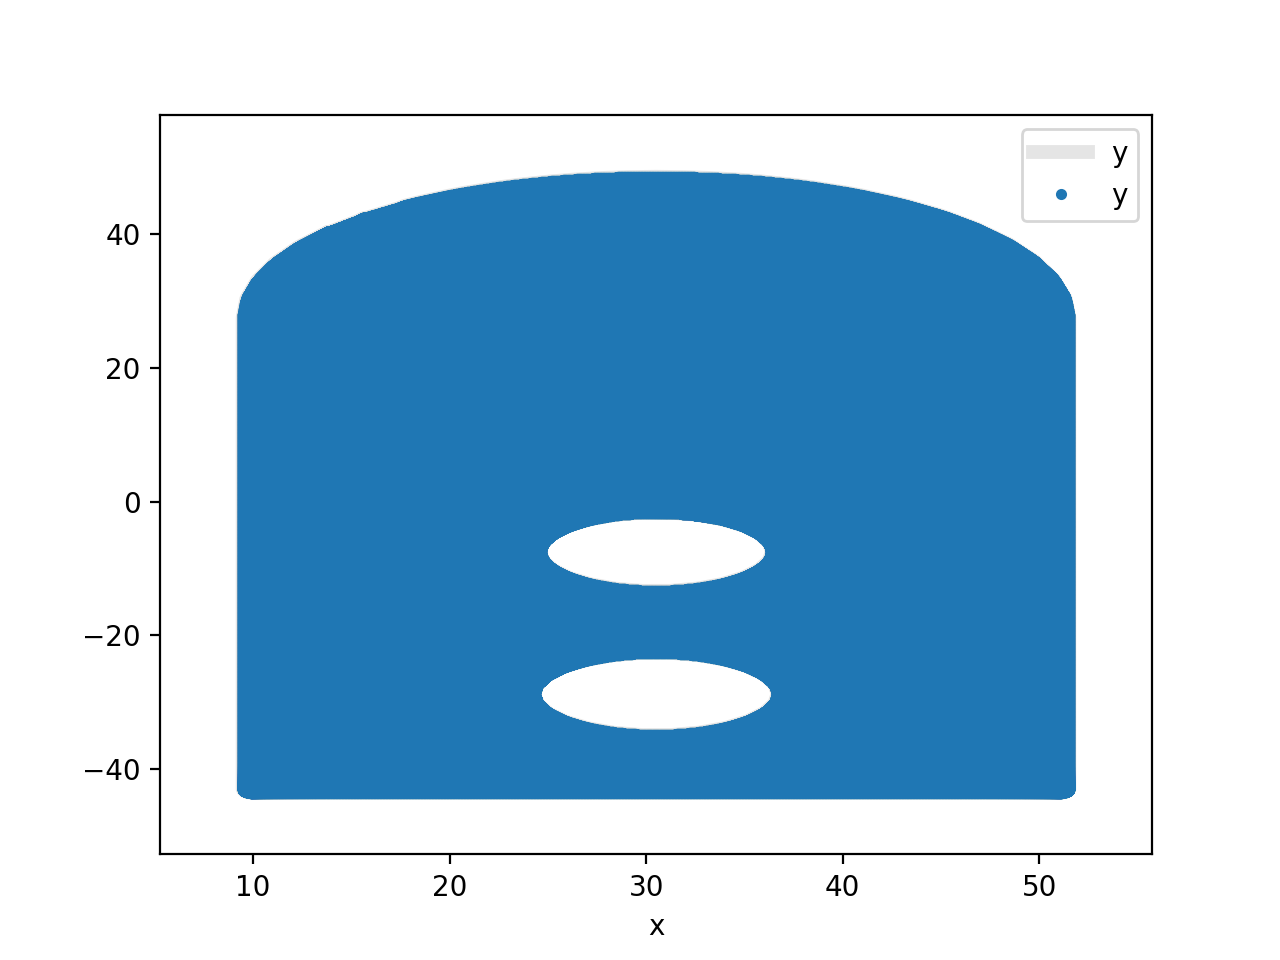

In [46]:
spm = 80
res["x"] = res["X_x"] / spm
res["y"] = res["Y_x"] / spm
res["xv"] = res["X_v"] * 65536 / 2**32 / spm * 50000000
res["yv"] = res["Y_v"] * 65536 / 2**32 / spm * 50000000
res[["x", "y", "xv", "yv", "ts"]]

lines = []
colors = []

i = 0
for index, row in all_segments.iterrows():
    i += 1
    lines.append(((row['x0'], row['y0']), (row['x1'], row['y1'])))
    st = row["seg_type"]
    if st == "start":
        colors.append((1,0,0,1))
    elif st == "end":
        colors.append((0,1,0,1))
    elif st == "short_plato":
        colors.append((0,0.3,1,1))
    elif st == "middle_plato":
        colors.append((0.8,0,0.8,1))
    elif st == "long_plato_main":
        colors.append((0.2,0.2,0.2,1))
    elif st == "long_plato_in":
        colors.append((1,0,0.8,1))
    elif st == "long_plato_out":
        colors.append((0,1,0.8,1))
    else:
        colors.append((1,1,0,1))
    
lc = LineCollection(lines, colors=colors, linewidths=1)
fig, ax = plt.subplots()

ax.add_collection(lc)

#path.iloc[limit:].plot(x="px", y="py", linewidth=3, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
full_path = pd.DataFrame()
full_path["x"] = path["px"]
full_path["y"] = path["py"]
last_x = path["x"].iloc[-1]
last_y = path["y"].iloc[-1]
full_path = full_path.append({"x": last_x, "y": last_y}, ignore_index=True)
full_path.plot(x="x", y="y", linewidth=5, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
res.plot(x="x", y="y", style=".", ax=ax)
    
ax.autoscale()
ax.margins(0.1)

<IPython.core.display.Javascript object>


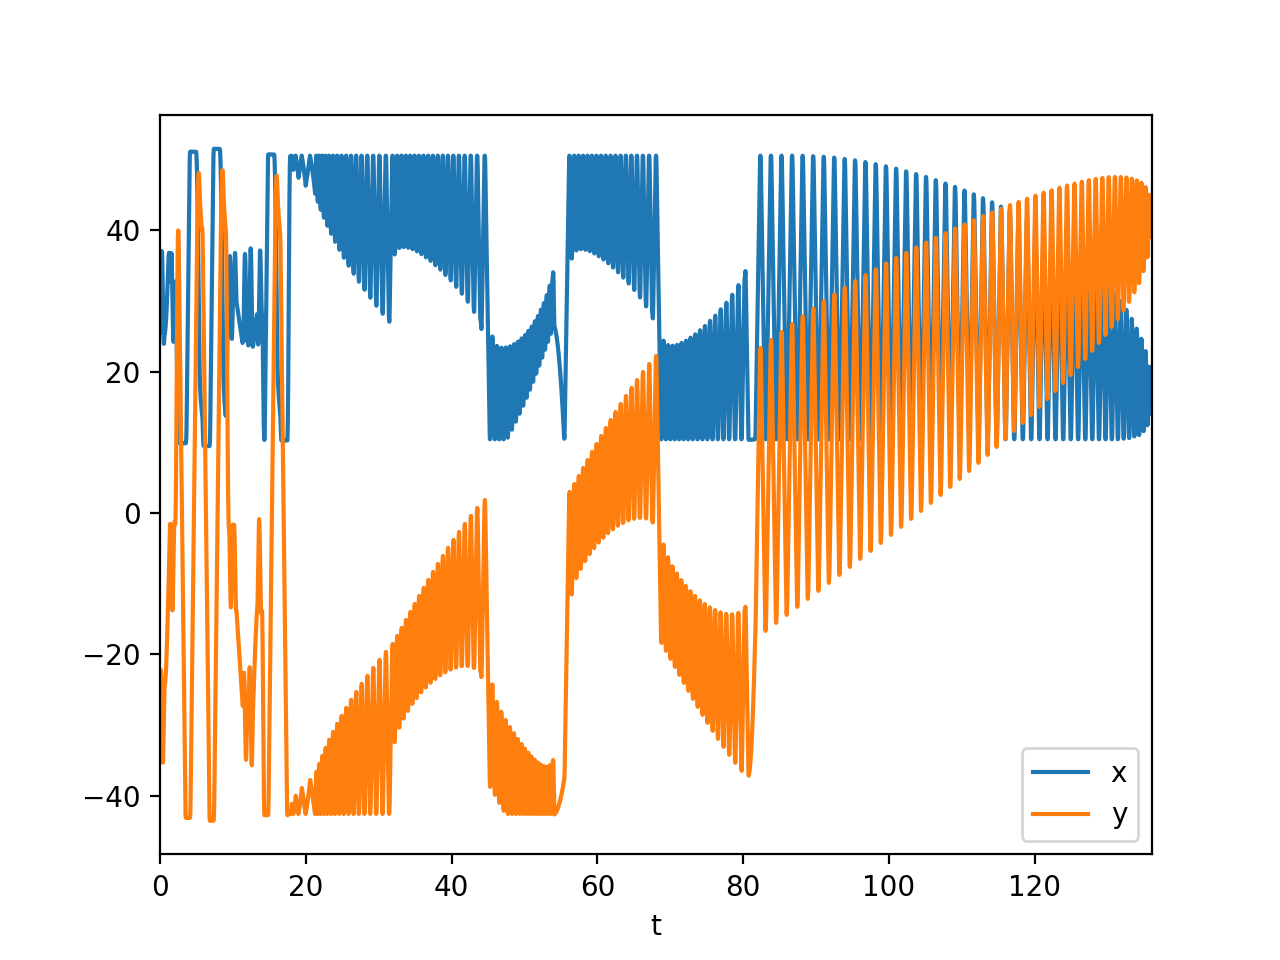

In [50]:
res.plot(x="t", y=["x", "y"])